In [1]:
import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Subset

from PIL import Image

import json
import time

In [2]:
data_dir = 'E:/Programming/FlowerApp/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# Define your transforms for the training and validation sets

# arrays to normalization
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])

data_transforms = {}

# transforms to train data set
data_transforms['train'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180),
        ]),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# transforms to valid data set
data_transforms['valid'] = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train_data'] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
valid_dataset_to_split = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid'])


# obtain validation and training datasets that will be used to evaluate the network
valid_data_index_list = []
test_data_index_list = []
for index in range(0, len(valid_dataset_to_split), 2):
    valid_data_index_list.append(index)
    test_data_index_list.append(index+1)

image_datasets['valid_data'] = Subset(valid_dataset_to_split, valid_data_index_list)
image_datasets['test_data'] = Subset(valid_dataset_to_split, test_data_index_list)

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {}
dataloaders['train_data'] = torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=32, shuffle=True, num_workers=3)
dataloaders['valid_data'] = torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=23, shuffle=False, num_workers=3)
dataloaders['test_data'] = torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=23, shuffle=False, num_workers=3)
print(f"Train data: {len(dataloaders['train_data'].dataset)} images / {len(dataloaders['train_data'])} batches")
print(f"Valid data: {len(dataloaders['valid_data'].dataset)} images / {len(dataloaders['valid_data'])} batches")
print(f"Test  data: {len(dataloaders['test_data'].dataset)} images / {len(dataloaders['test_data'])} batches")

Train data: 6552 images / 205 batches
Valid data: 409 images / 18 batches
Test  data: 409 images / 18 batches


In [4]:
with open('E:/Programming/FlowerApp/flower_data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
class_to_idx = image_datasets['train_data'].class_to_idx

cat_label_to_name = {}
for cat, label in class_to_idx.items():
    name = cat_to_name.get(cat)
    cat_label_to_name[label] = name

print(cat_label_to_name)

{0: 'pink primrose', 1: 'globe thistle', 2: 'blanket flower', 3: 'trumpet creeper', 4: 'blackberry lily', 5: 'snapdragon', 6: "colt's foot", 7: 'king protea', 8: 'spear thistle', 9: 'yellow iris', 10: 'globe-flower', 11: 'purple coneflower', 12: 'peruvian lily', 13: 'balloon flower', 14: 'hard-leaved pocket orchid', 15: 'giant white arum lily', 16: 'fire lily', 17: 'pincushion flower', 18: 'fritillary', 19: 'red ginger', 20: 'grape hyacinth', 21: 'corn poppy', 22: 'prince of wales feathers', 23: 'stemless gentian', 24: 'artichoke', 25: 'canterbury bells', 26: 'sweet william', 27: 'carnation', 28: 'garden phlox', 29: 'love in the mist', 30: 'mexican aster', 31: 'alpine sea holly', 32: 'ruby-lipped cattleya', 33: 'cape flower', 34: 'great masterwort', 35: 'siam tulip', 36: 'sweet pea', 37: 'lenten rose', 38: 'barbeton daisy', 39: 'daffodil', 40: 'sword lily', 41: 'poinsettia', 42: 'bolero deep blue', 43: 'wallflower', 44: 'marigold', 45: 'buttercup', 46: 'oxeye daisy', 47: 'english marig

In [5]:
def imgview(img, title, ax):
    # un-normalize
    for i in range(img.shape[0]):
        img[i] = img[i] * normalize_std[i] + normalize_mean[i]
        
    # convert from TRensor image
    ax.imshow(np.transpose(img, (1, 2, 0)))
    
    ax.set_title(title)

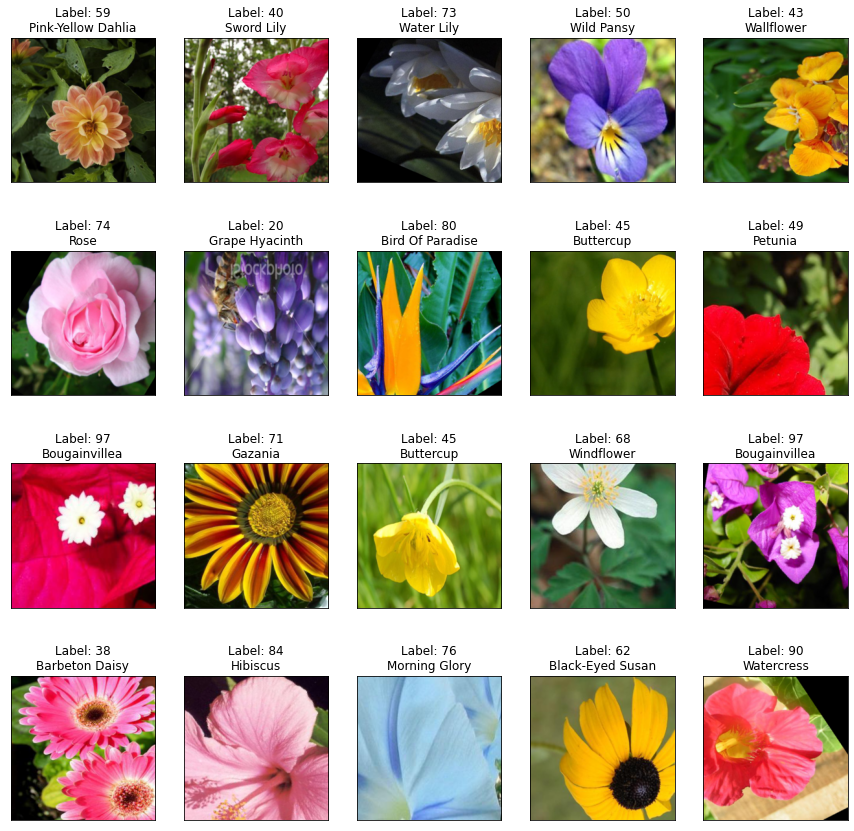

In [6]:
# obtain one batch of training images
dataiter = iter(dataloaders['train_data'])
images, labels = dataiter.next()

images = images.numpy() # convert images to numpy for display

# show some test images
fig = plt.figure(figsize=(15, 15))
fig_rows, fig_cols = 4, 5
for index in np.arange(fig_rows*fig_cols):

    img = images[index]

    label = labels[index].item()
    title = f'Label: {label}\n{cat_label_to_name[label].title()}'

    ax = fig.add_subplot(fig_rows, fig_cols, index+1, xticks=[], yticks=[])

    imgview(img, title, ax)


In [7]:
# Freeze parameters so we don't backprop through them
def freeze_parameters(root, freeze=True):
    [param.requires_grad_(not freeze) for param in root.parameters()]

In [8]:
# Create a new classifier
def create_classifier(input_size, output_size, hidden_layers=[], dropout=0.5,
                      activation=nn.RReLU(), output_function=nn.LogSoftmax(dim=1)):
    dict = OrderedDict()
    
    if len(hidden_layers) == 0:
        dict['layer0'] = nn.Linear(input_size, output_size)

    else:
        
        dict['layer0'] = nn.Linear(input_size, hidden_layers[0])
        if activation:
            dict['activ0'] = activation
        if dropout:
            dict['drop_0'] = nn.Dropout(dropout)
        
        #for layer_in, layer_out in range(len(hidden_layers)):
        for layer, layer_in in enumerate(zip(hidden_layers[:-1],hidden_layers[1:])):
            dict['layer'+str(layer+1)] = nn.Linear(layer_in[0],layer_in[1])
            if activation:
                dict['activ'+str(layer+1)] = activation
            if dropout:
                dict['drop_'+str(layer+1)] = nn.Dropout(dropout)
            
        dict['output'] = nn.Linear(hidden_layers[-1], output_size)

    if output_function:
        dict['output_function'] = output_function
    
    return nn.Sequential(dict)

In [9]:
# check if CUDA is available
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running on: {str(device).upper()}')


Running on: CUDA


In [10]:
def train(epochs, model, optimizers, lr_scheduler=None,
          dataloaders=dataloaders, state_dict=None,
          checkpoint_path="checkpoint.pt", accuracy_target=None,
          show_graphs=True):

    if state_dict == None:
        state_dict = {
            'elapsed_time': 0,
            'trace_log': [],
            'trace_train_loss': [],
            'trace_train_lr': [],
            'valid_loss_min': np.Inf,
            'trace_valid_loss': [],
            'trace_accuracy': [],
            'epochs_trained': 0}
        state_dict['trace_log'].append('PHASE ONE')


    for epoch in range(1,epochs+1):
        
        try:
            lr_scheduler.step() # if instance of _LRScheduler
        except TypeError:
            try:
                if lr_scheduler.min_lrs[0] == lr_scheduler.optimizer.param_groups[0]['lr']:
                    break
                lr_scheduler.step(valid_loss) # if instance of ReduceLROnPlateau
            except NameError: # valid_loss is not defined yet
                lr_scheduler.step(np.Inf)
        except:
            pass # do nothing

        epoch_start_time = time.time()
        #####################
        #       TRAIN       #
        #####################
        train_loss = 0
        model.train()
        for images, labels in dataloaders['train_data']:
            # Move tensors to device
            images, labels = images.to(device), labels.to(device)

            # Clear optimizers
            [opt.zero_grad() for opt in optimizers]

            # Pass train batch through model feed-forward
            output = model(images)

            # Calculate loss for this train batch
            batch_loss = criterion(output, labels)
            # Do the backpropagation
            batch_loss.backward()

            # Optimize parameters
            [opt.step() for opt in optimizers]

            # Track train loss
            train_loss += batch_loss.item()*len(images)

        # Track how many epochs has already run
        state_dict['elapsed_time'] += time.time()-epoch_start_time
        state_dict['epochs_trained'] += 1

        #####################
        #      VALIDATE     #
        #####################
        valid_loss = 0
        accuracy = 0
        top_class_graph = []
        labels_graph = []
        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['valid_data']:
                labels_graph.extend( labels )

                # Move tensors to device
                images, labels = images.to(device), labels.to(device)

                # Get predictions for this validation batch
                output = model(images)

                # Calculate loss for this validation batch
                batch_loss = criterion(output, labels)
                # Track validation loss
                valid_loss += batch_loss.item()*len(images)

                # Calculate accuracy
                output = torch.exp(output)
                top_ps, top_class = output.topk(1, dim=1)
                top_class_graph.extend( top_class.view(-1).to('cpu').numpy() )
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*len(images)

        #####################
        #     PRINT LOG     #
        #####################
        
        # calculate average losses
        train_loss = train_loss/len(dataloaders['train_data'].dataset)
        valid_loss = valid_loss/len(dataloaders['valid_data'].dataset)
        accuracy = accuracy/len(dataloaders['valid_data'].dataset)

        state_dict['trace_train_loss'].append(train_loss)
        try:
            state_dict['trace_train_lr'].append(lr_scheduler.get_lr()[0])
        except:
            state_dict['trace_train_lr'].append(
                optimizers[0].state_dict()['param_groups'][0]['lr'])
        state_dict['trace_valid_loss'].append(valid_loss)
        state_dict['trace_accuracy'].append(accuracy)

        # print training/validation statistics 
        log = 'Epoch: {}: \
               lr: {:.8f}\t\
               Training Loss: {:.6f}\t\
               Validation Loss: {:.6f}\t\
               Validation accuracy: {:.2f}%\t\
               Elapsed time: {:.2f}'.format(
                    state_dict['epochs_trained'],
                    state_dict['trace_train_lr'][-1],
                    train_loss,
                    valid_loss,
                    accuracy*100,
                    state_dict['elapsed_time']
                    )
        state_dict['trace_log'].append(log)
        print(log)

        # save model if validation loss has decreased
        if valid_loss <= state_dict['valid_loss_min']:
            print('Validation loss decreased: \
                  ({:.6f} --> {:.6f}).   Saving model ...'
                  .format(state_dict['valid_loss_min'],valid_loss))

            checkpoint = {'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizers[0].state_dict(),
                          'training_state_dict': state_dict}
            if lr_scheduler:
                checkpoint['lr_scheduler_state_dict'] = lr_scheduler.state_dict()

            torch.save(checkpoint, checkpoint_path)
            state_dict['valid_loss_min'] = valid_loss

        if show_graphs:
            plt.figure(figsize=(25,8))
            plt.plot(np.array(labels_graph), 'k.')
            plt.plot(np.array(top_class_graph), 'r.')
            plt.show()

            plt.figure(figsize=(25,5))
            plt.subplot(1,2,1)
            plt.plot(np.array(state_dict['trace_train_loss']), 'b', label='train loss')
            plt.plot(np.array(state_dict['trace_valid_loss']), 'r', label='validation loss')
            plt.plot(np.array(state_dict['trace_accuracy']), 'g', label='accuracy')

            plt.subplot(1,2,2)
            plt.plot(np.array(state_dict['trace_train_lr']), 'b', label='train loss')

            plt.show()


        # stop training loop if accuracy_target has been reached
        if accuracy_target and state_dict['trace_accuracy'][-1] >= accuracy_target:
            break

    return state_dict
# Build and train your network
def create_network(model_name='resnet50', output_size=102, hidden_layers=[1000]):
    if model_name == 'resnet50':
        # Download the model
        model = models.resnet50(pretrained=True)
        # Replace the model classifier
        model.fc = create_classifier(2048, output_size, hidden_layers)
        
        return model
        
    if model_name == 'resnet152':
        # Download the model
        model = models.resnet152(pretrained=True)
        # Replace the model classifier
        model.fc = create_classifier(2048, output_size, hidden_layers)
        
        return model
        
    return None

In [11]:
# Define hyperparameters
model_name = 'resnet50'
output_size = 102
hidden_layers = [1000]

model = create_network(model_name, output_size, hidden_layers)

# Move model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
def test_model(dataloader=dataloaders['test_data'], show_graphs=True):
    #####################
    #       TEST        #
    #####################
    criterion = nn.NLLLoss()
    test_loss = 0
    accuracy = 0
    top_class_graph = []
    labels_graph = []
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            labels_graph.extend( labels )

            # Move tensors to device
            images, labels = images.to(device), labels.to(device)

            # Get predictions for this test batch
            output = model(images)

            # Calculate loss for this test batch
            batch_loss = criterion(output, labels)
            # Track validation loss
            test_loss += batch_loss.item()*len(images)

            # Calculate accuracy
            output = torch.exp(output)
            top_ps, top_class = output.topk(1, dim=1)
            top_class_graph.extend( top_class.view(-1).to('cpu').numpy() )
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item()

    #####################
    #     PRINT LOG     #
    #####################

    # calculate average losses
    test_loss = test_loss/len(dataloader.dataset)
    accuracy = accuracy/len(dataloader.dataset)

    # print training/validation statistics 
    log = f'Test Loss: {test_loss:.6f}\t\
           Test accuracy: {(accuracy*100):.2f}%'
    print(log)

    if show_graphs:
        plt.figure(figsize=(25,13))
        plt.plot(np.array(labels_graph), 'k.')
        plt.plot(np.array(top_class_graph), 'r.')
        plt.show()

        plt.show()


In [13]:
def load_model(checkpoint_path, state_dict):
    try:
        checkpoint = torch.load(checkpoint_path)
        state_dict = checkpoint['training_state_dict']
        model.load_state_dict(checkpoint['model_state_dict'])
        fc_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        pass

    return state_dict

E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1:                lr: 0.01000000	               Training Loss: 4.260430	               Validation Loss: 1.019443	               Validation accuracy: 73.35%	               Elapsed time: 124.77
Validation loss decreased:                   (inf --> 1.019443).   Saving model ...


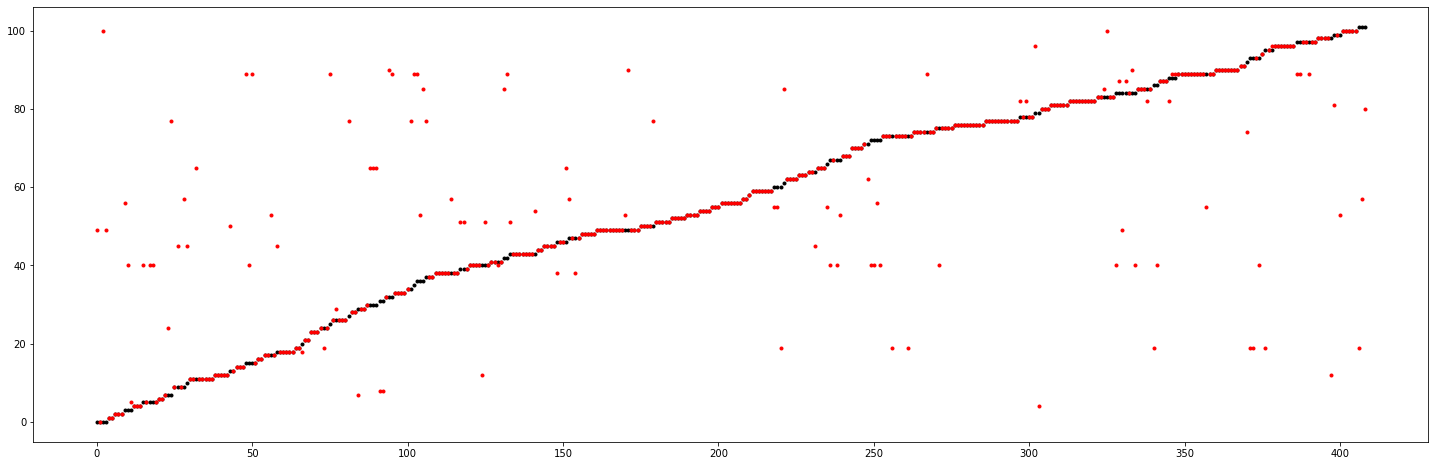

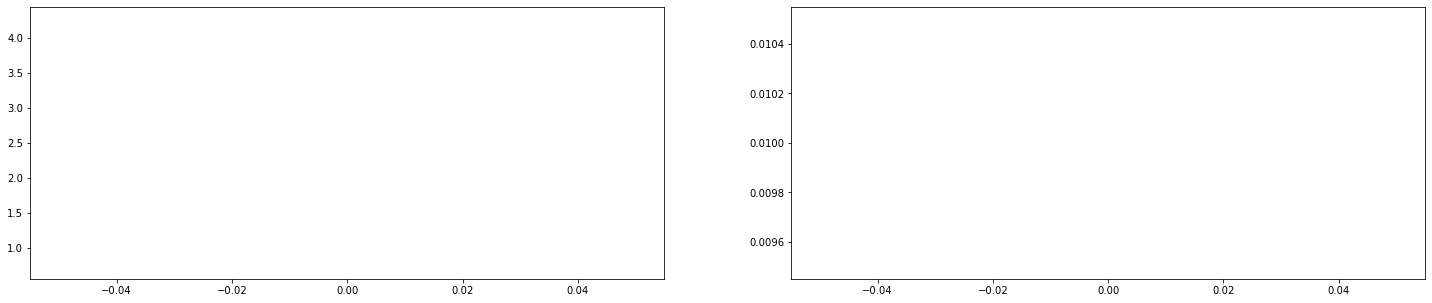

Epoch: 2:                lr: 0.01000000	               Training Loss: 1.358664	               Validation Loss: 0.638249	               Validation accuracy: 83.37%	               Elapsed time: 151.39
Validation loss decreased:                   (1.019443 --> 0.638249).   Saving model ...


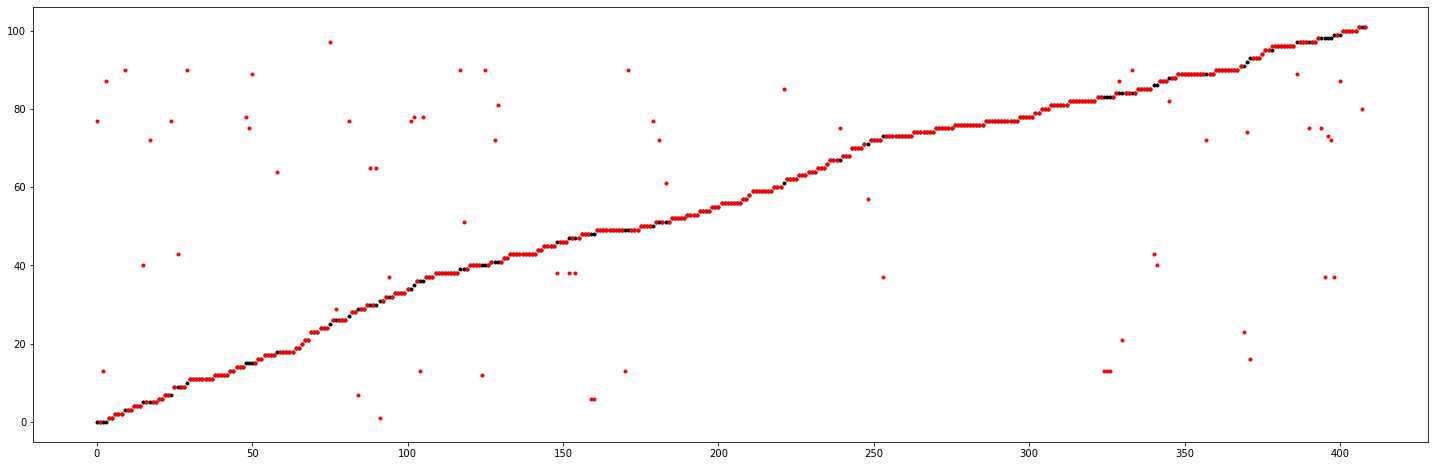

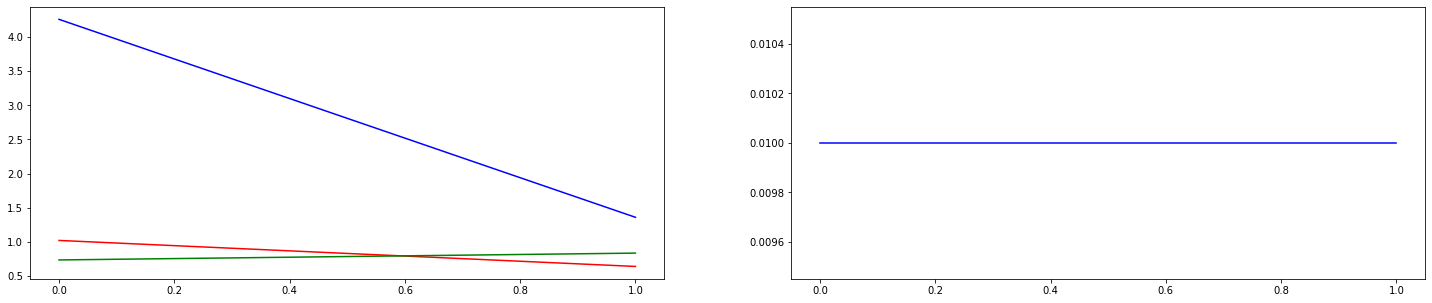

Epoch: 3:                lr: 0.01000000	               Training Loss: 1.030567	               Validation Loss: 0.482966	               Validation accuracy: 87.29%	               Elapsed time: 176.04
Validation loss decreased:                   (0.638249 --> 0.482966).   Saving model ...


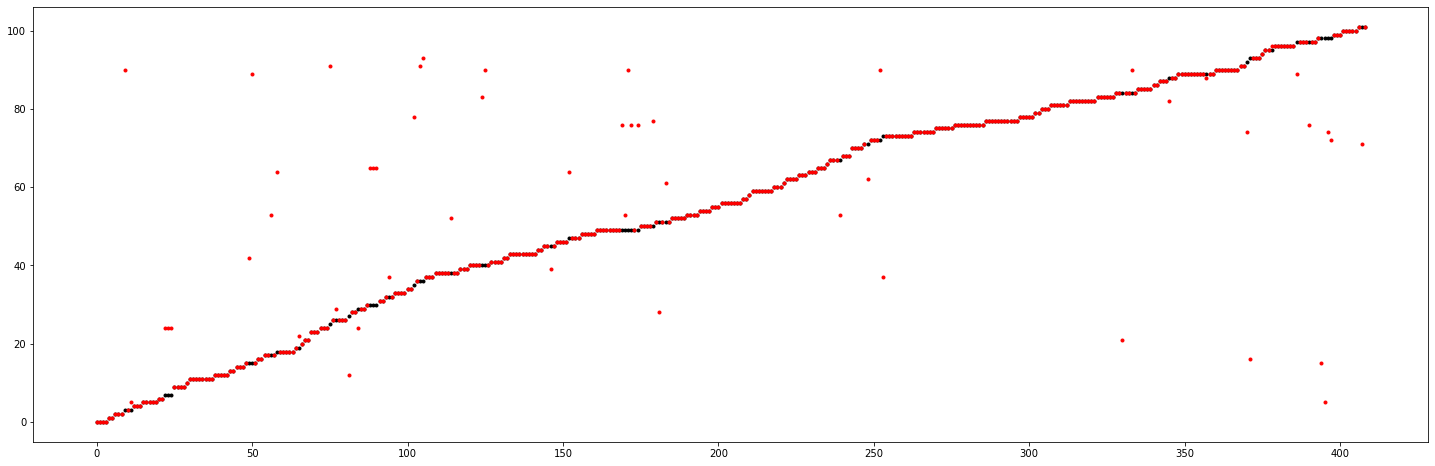

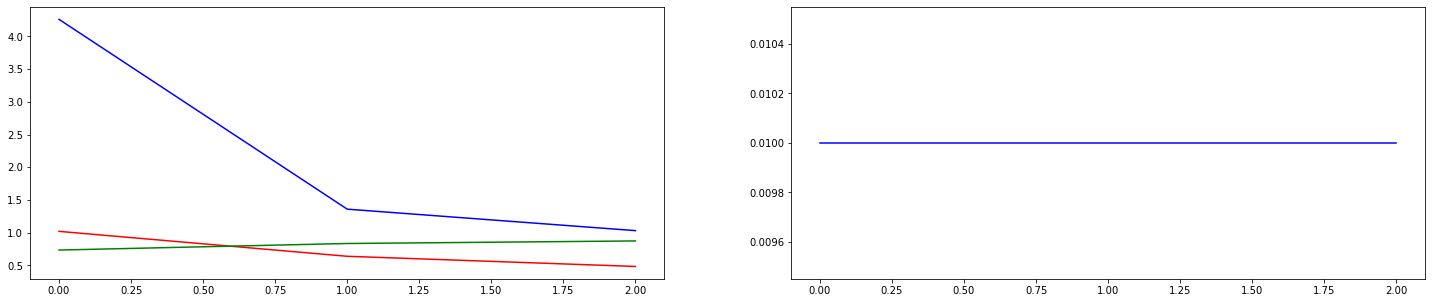

Epoch: 4:                lr: 0.01000000	               Training Loss: 0.865001	               Validation Loss: 0.410841	               Validation accuracy: 89.00%	               Elapsed time: 217.54
Validation loss decreased:                   (0.482966 --> 0.410841).   Saving model ...


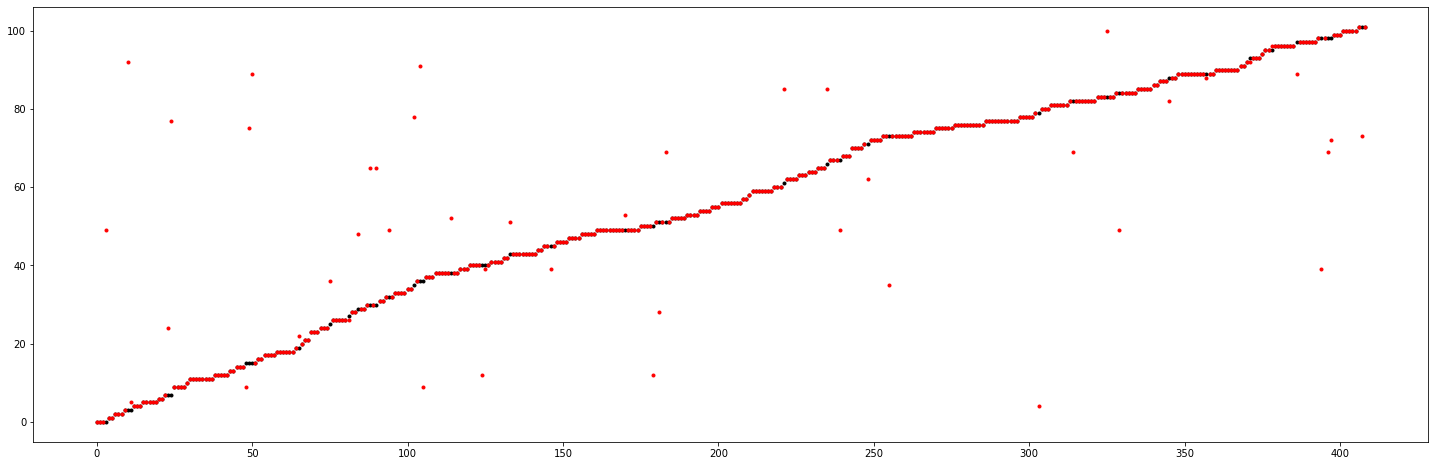

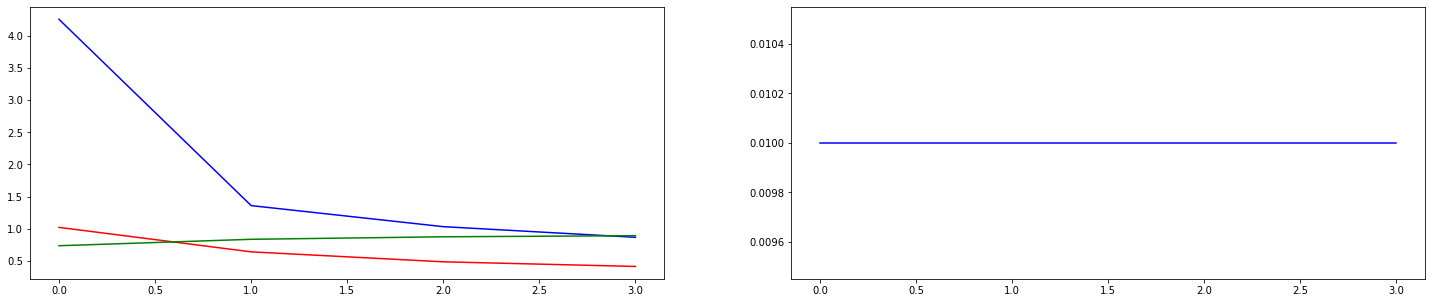

Epoch: 5:                lr: 0.01000000	               Training Loss: 0.762243	               Validation Loss: 0.347781	               Validation accuracy: 91.44%	               Elapsed time: 243.92
Validation loss decreased:                   (0.410841 --> 0.347781).   Saving model ...


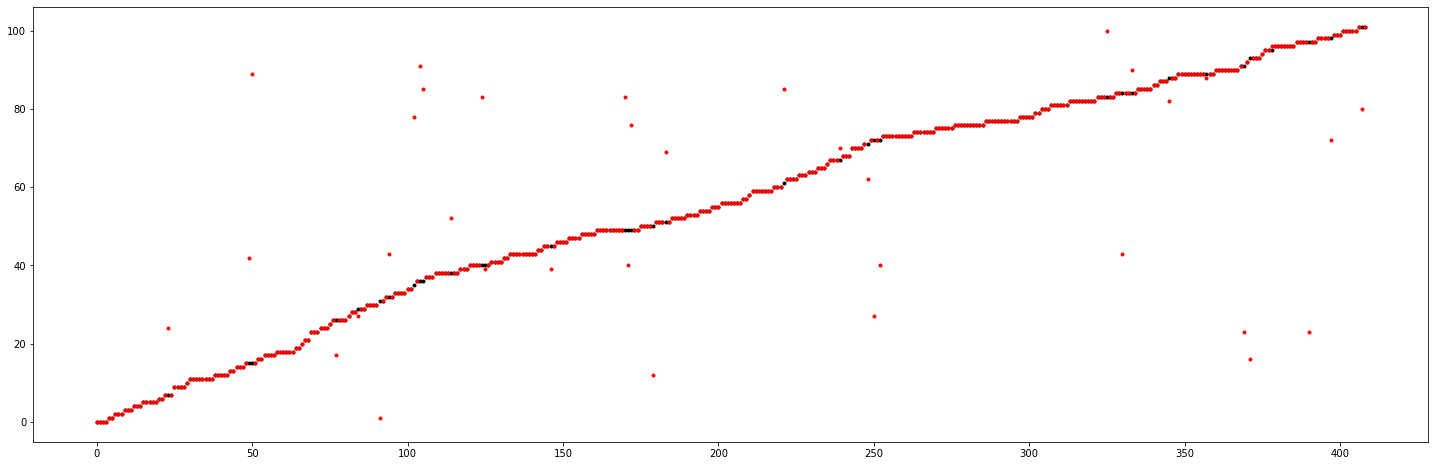

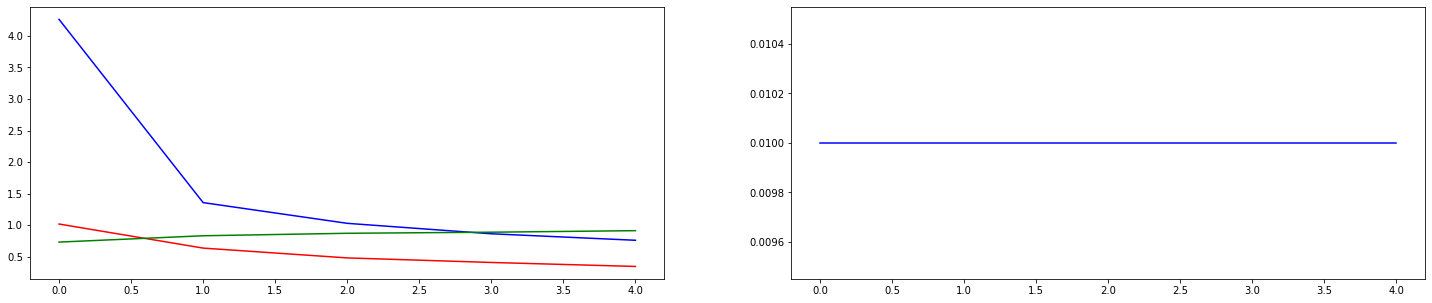

Epoch: 6:                lr: 0.01000000	               Training Loss: 0.750849	               Validation Loss: 0.322943	               Validation accuracy: 92.67%	               Elapsed time: 267.70
Validation loss decreased:                   (0.347781 --> 0.322943).   Saving model ...


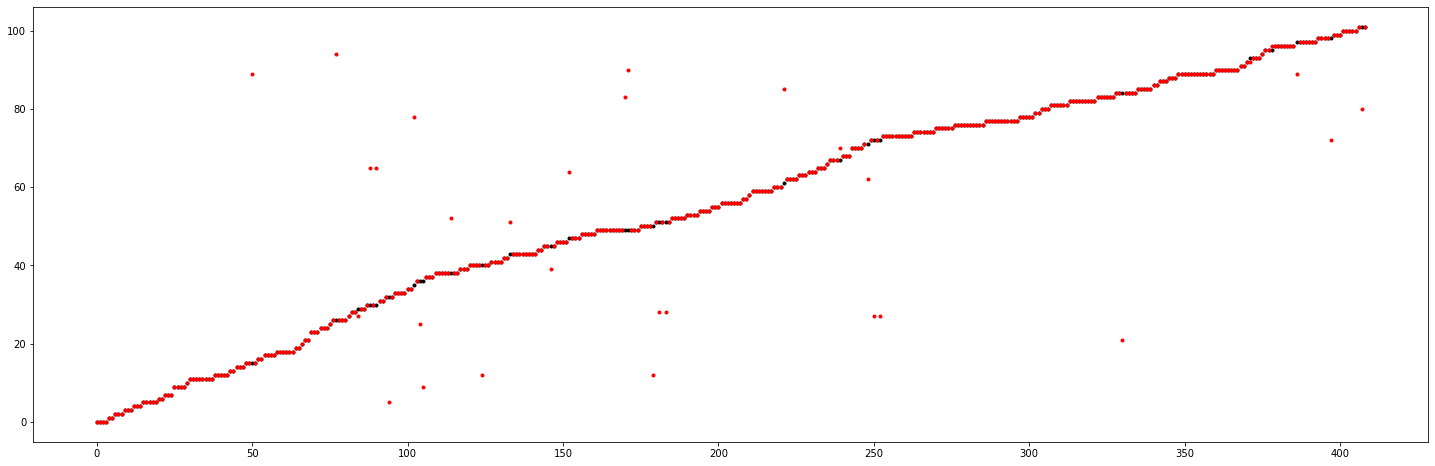

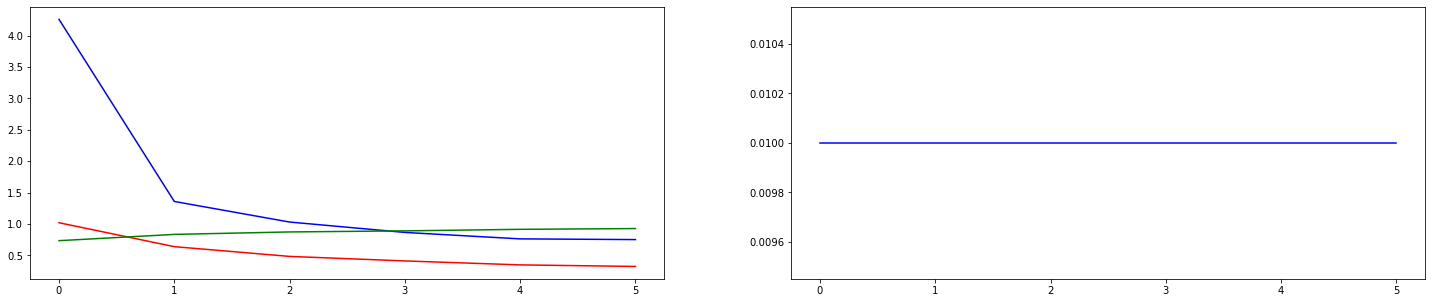

Epoch: 7:                lr: 0.01000000	               Training Loss: 0.685111	               Validation Loss: 0.347518	               Validation accuracy: 91.44%	               Elapsed time: 293.31


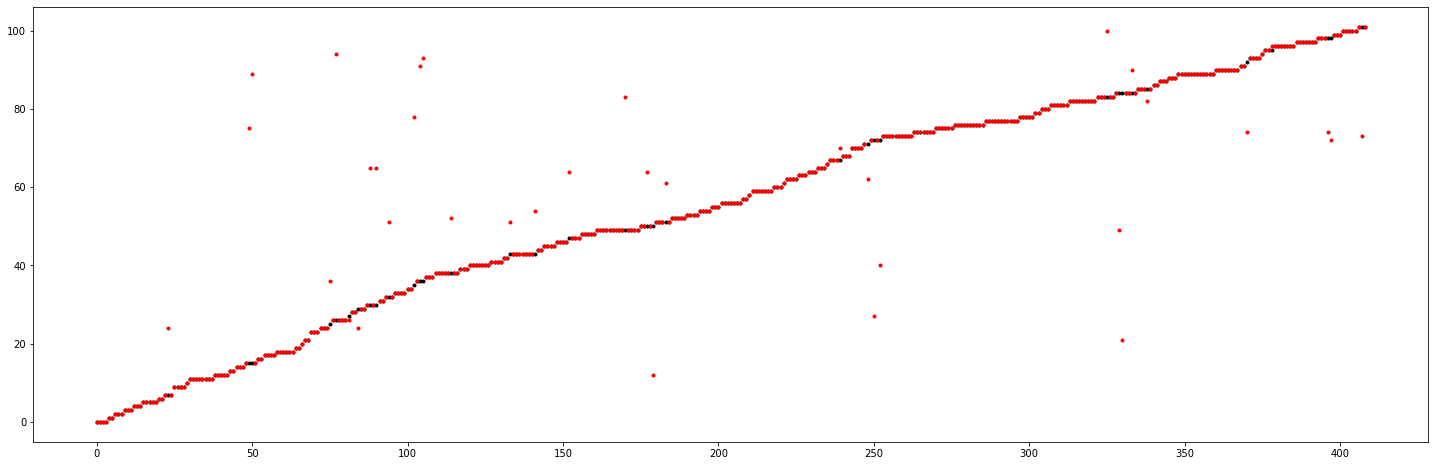

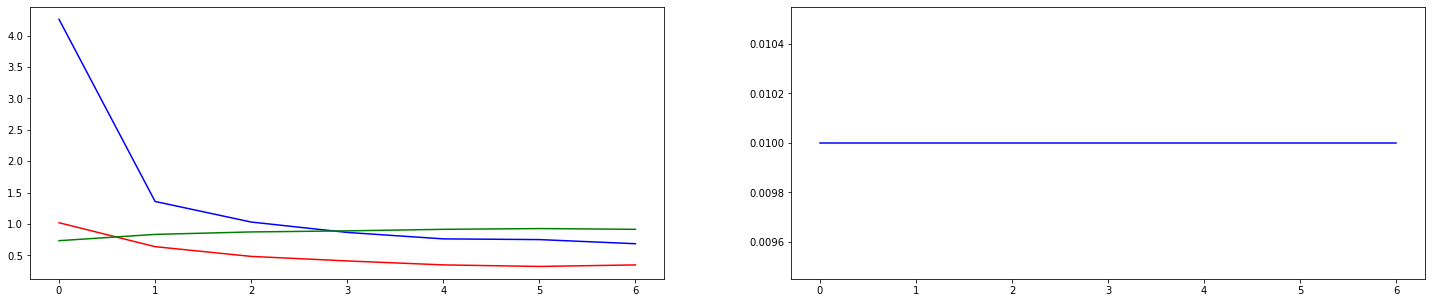

Epoch: 8:                lr: 0.01000000	               Training Loss: 0.650816	               Validation Loss: 0.327176	               Validation accuracy: 92.67%	               Elapsed time: 319.91


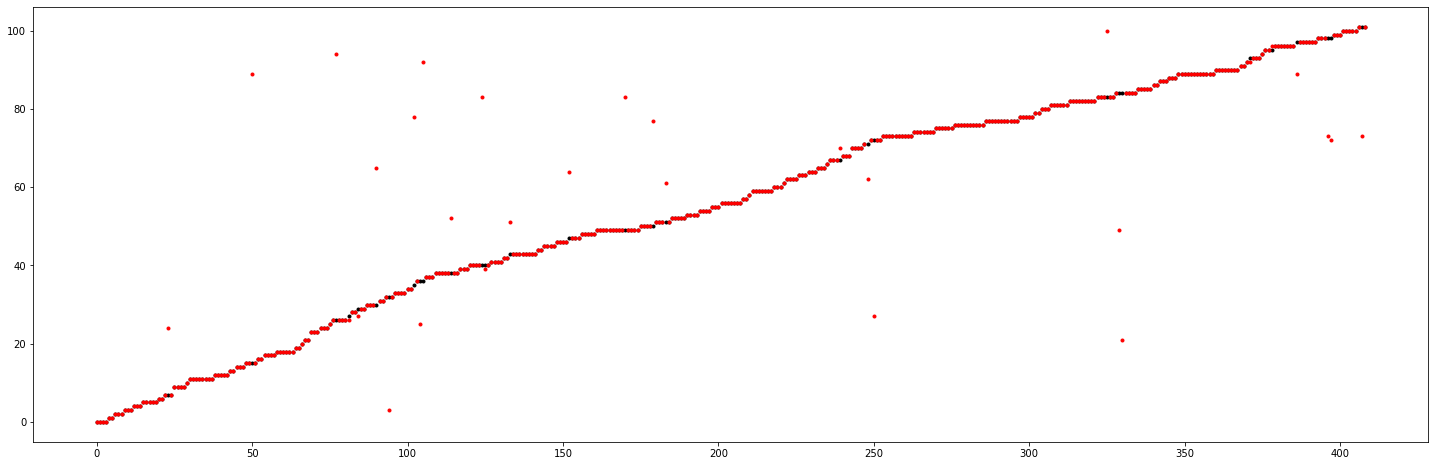

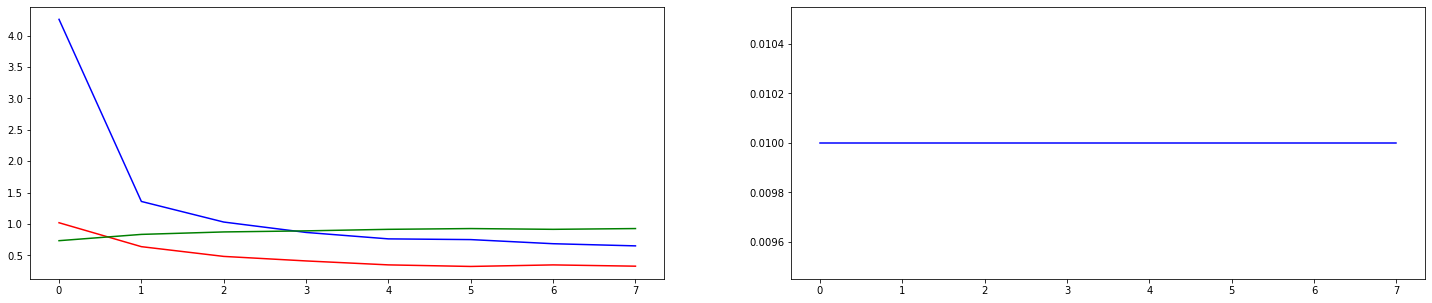

Epoch: 9:                lr: 0.01000000	               Training Loss: 0.625757	               Validation Loss: 0.335202	               Validation accuracy: 90.46%	               Elapsed time: 345.61


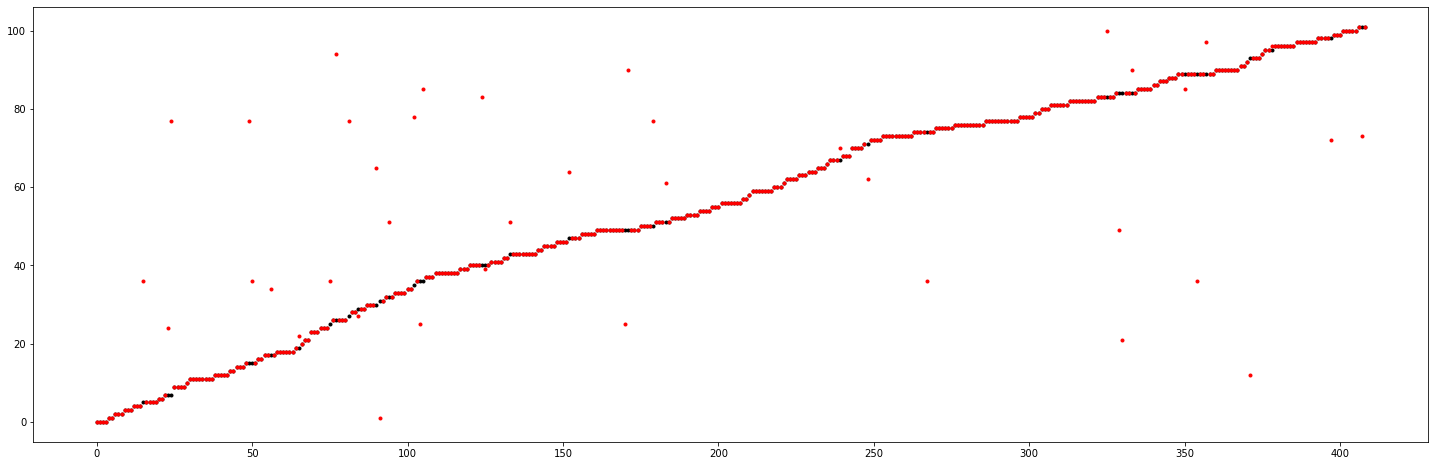

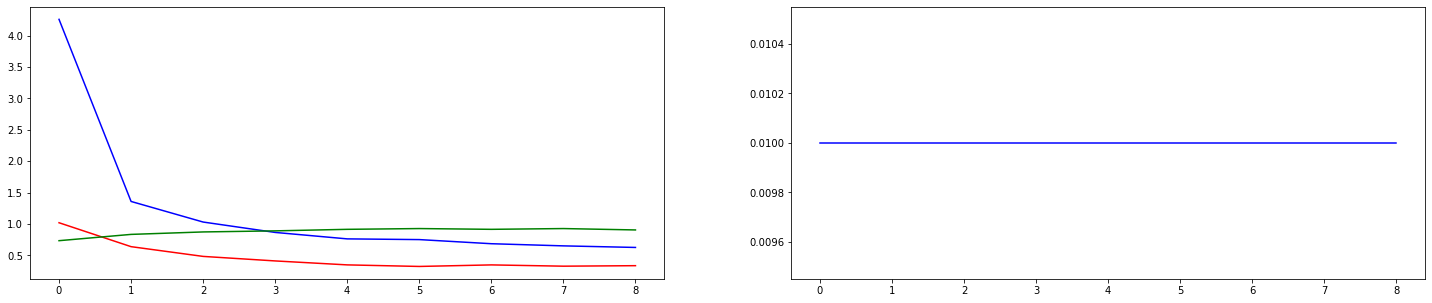

Epoch: 10:                lr: 0.01000000	               Training Loss: 0.613206	               Validation Loss: 0.315188	               Validation accuracy: 92.67%	               Elapsed time: 369.51
Validation loss decreased:                   (0.322943 --> 0.315188).   Saving model ...


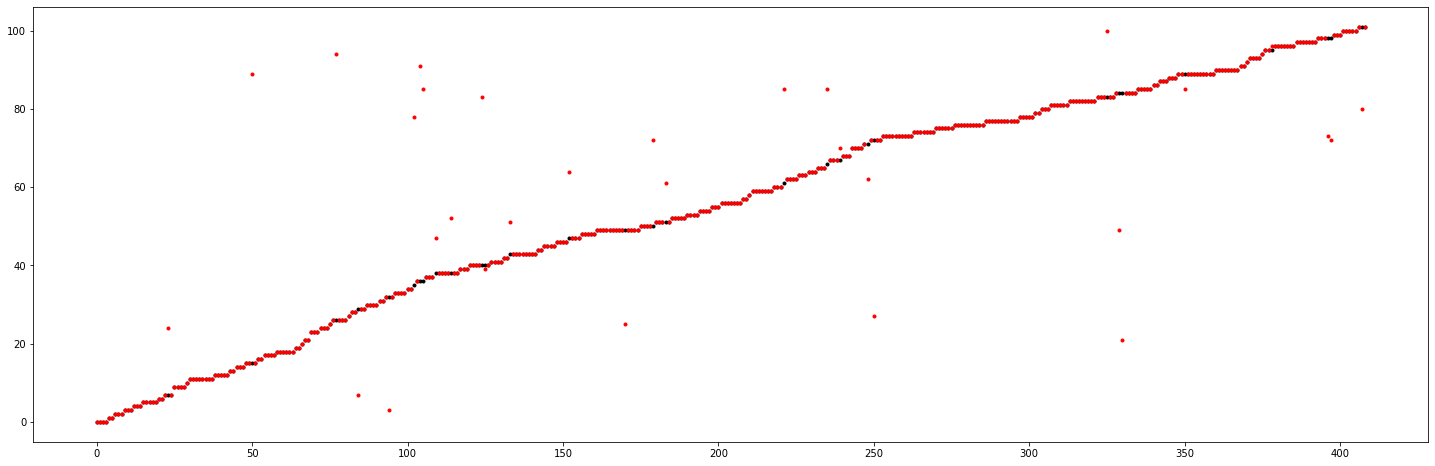

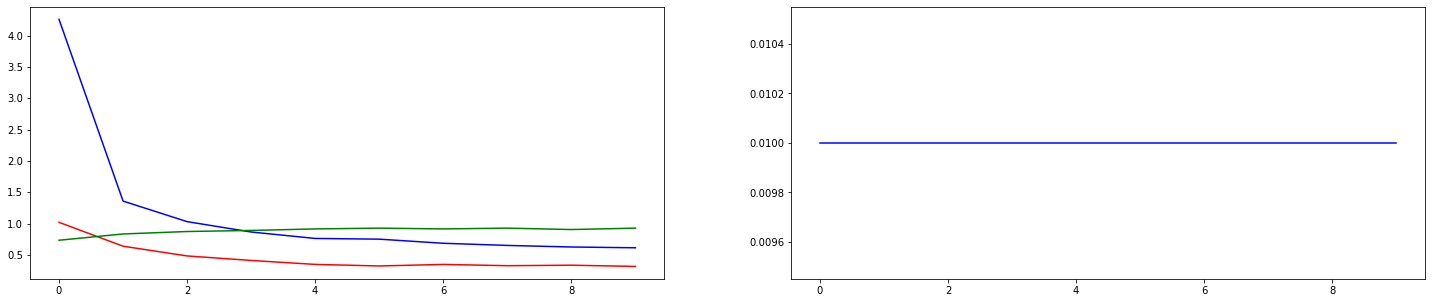

Epoch: 11:                lr: 0.01000000	               Training Loss: 0.592633	               Validation Loss: 0.292349	               Validation accuracy: 94.13%	               Elapsed time: 396.61
Validation loss decreased:                   (0.315188 --> 0.292349).   Saving model ...


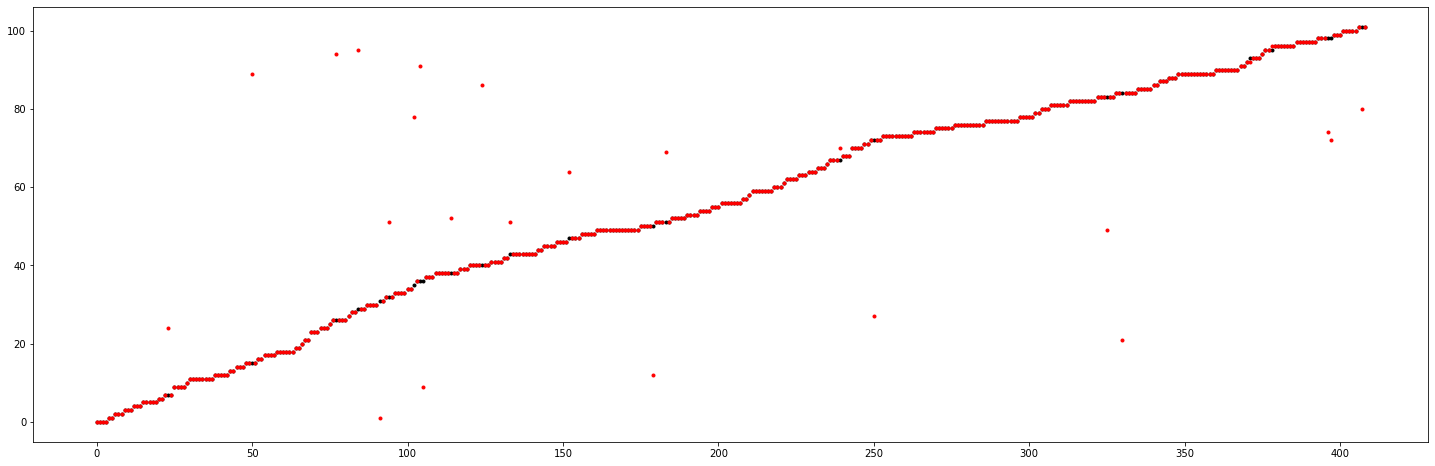

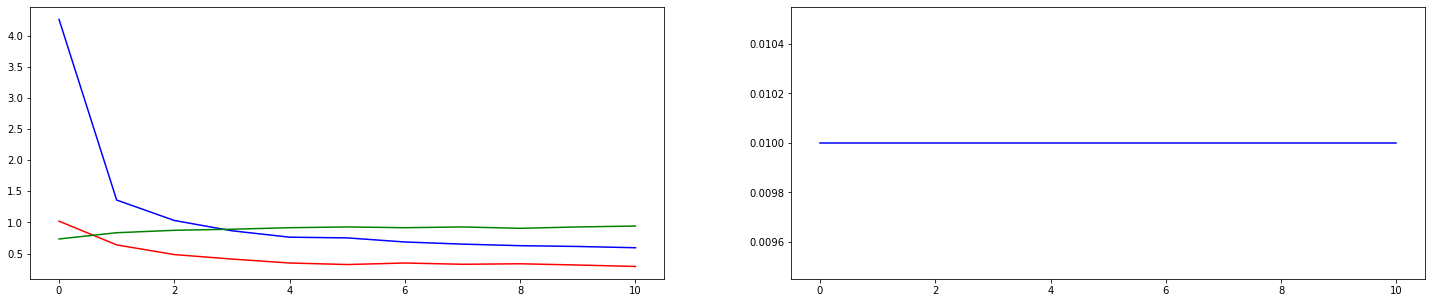

Epoch: 12:                lr: 0.01000000	               Training Loss: 0.575225	               Validation Loss: 0.300473	               Validation accuracy: 93.15%	               Elapsed time: 419.81


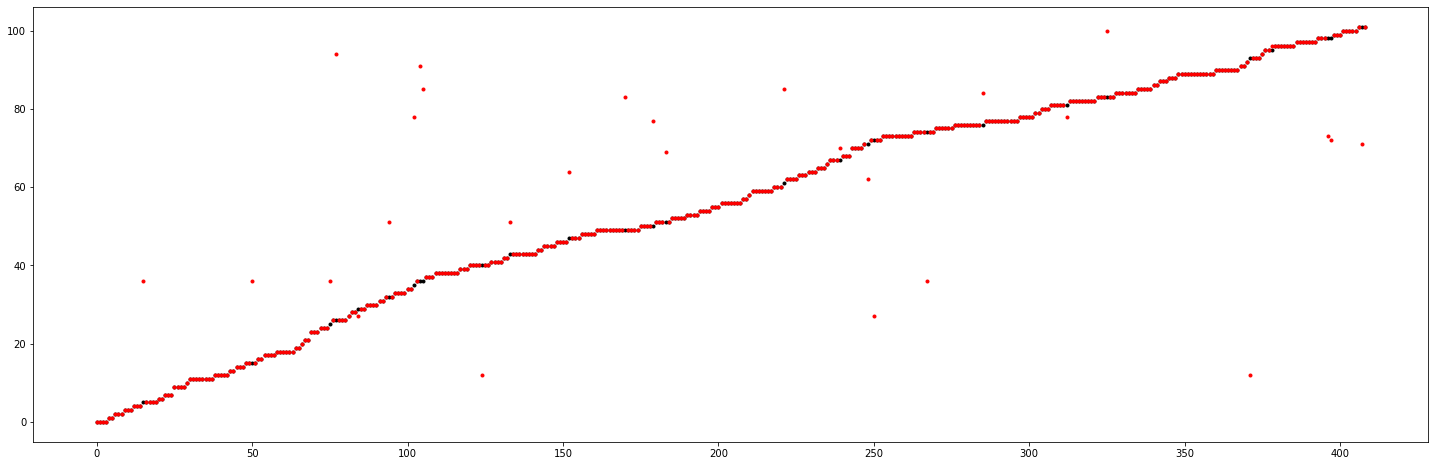

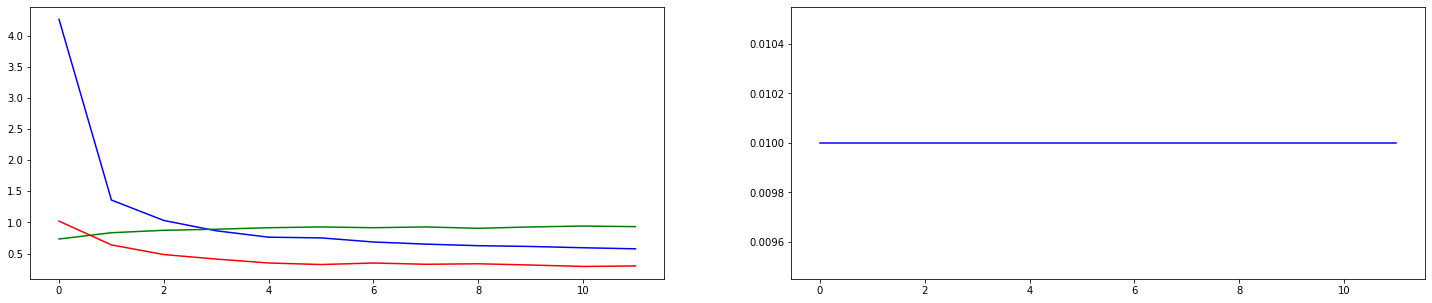

Epoch: 13:                lr: 0.01000000	               Training Loss: 0.585358	               Validation Loss: 0.286317	               Validation accuracy: 93.15%	               Elapsed time: 443.21
Validation loss decreased:                   (0.292349 --> 0.286317).   Saving model ...


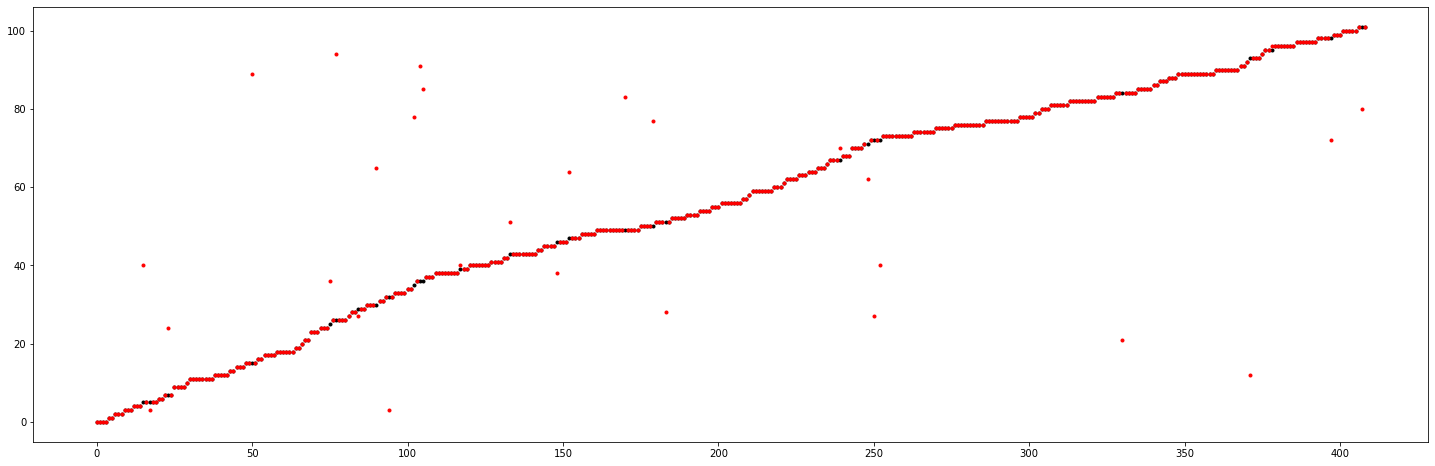

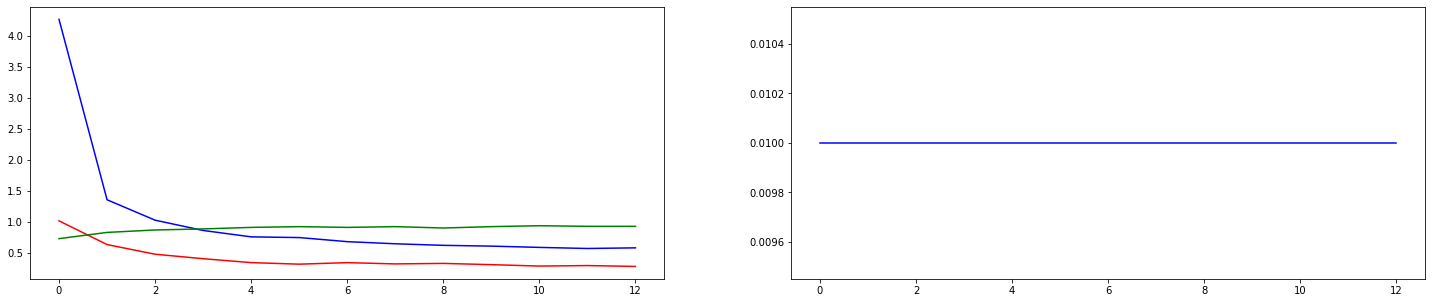

Epoch: 14:                lr: 0.01000000	               Training Loss: 0.573708	               Validation Loss: 0.274110	               Validation accuracy: 93.64%	               Elapsed time: 467.27
Validation loss decreased:                   (0.286317 --> 0.274110).   Saving model ...


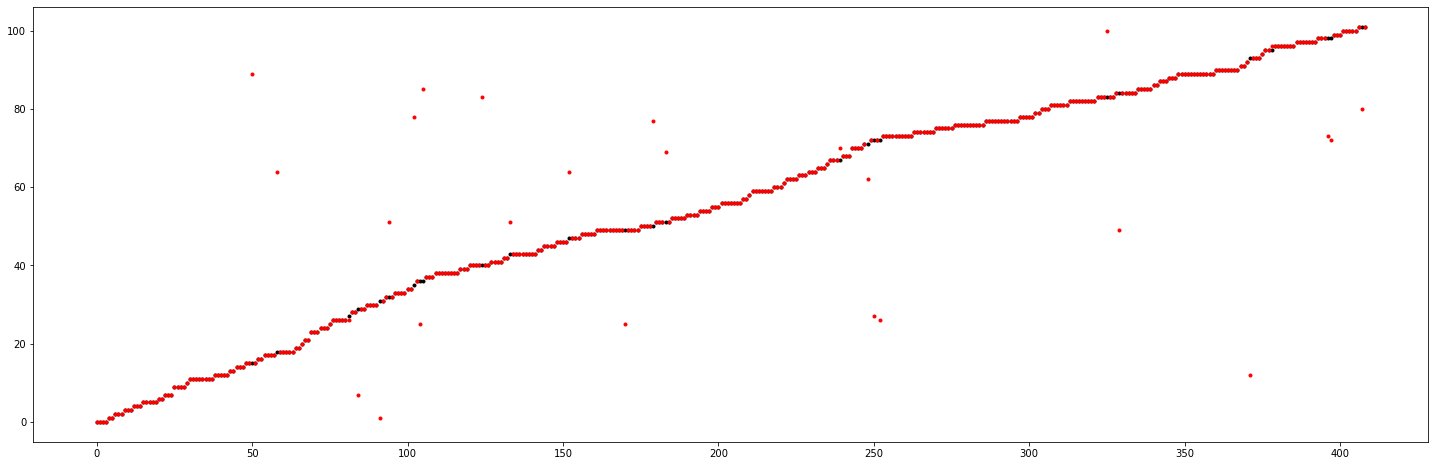

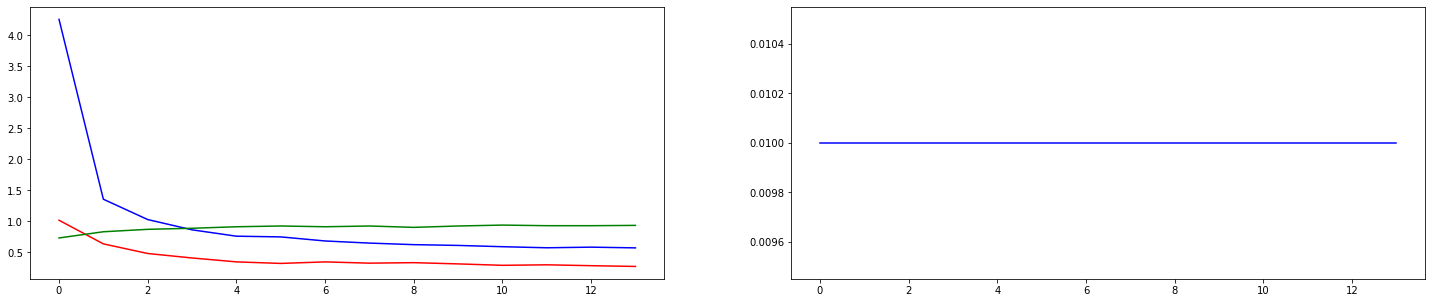

Epoch: 15:                lr: 0.01000000	               Training Loss: 0.557333	               Validation Loss: 0.282672	               Validation accuracy: 94.38%	               Elapsed time: 489.89


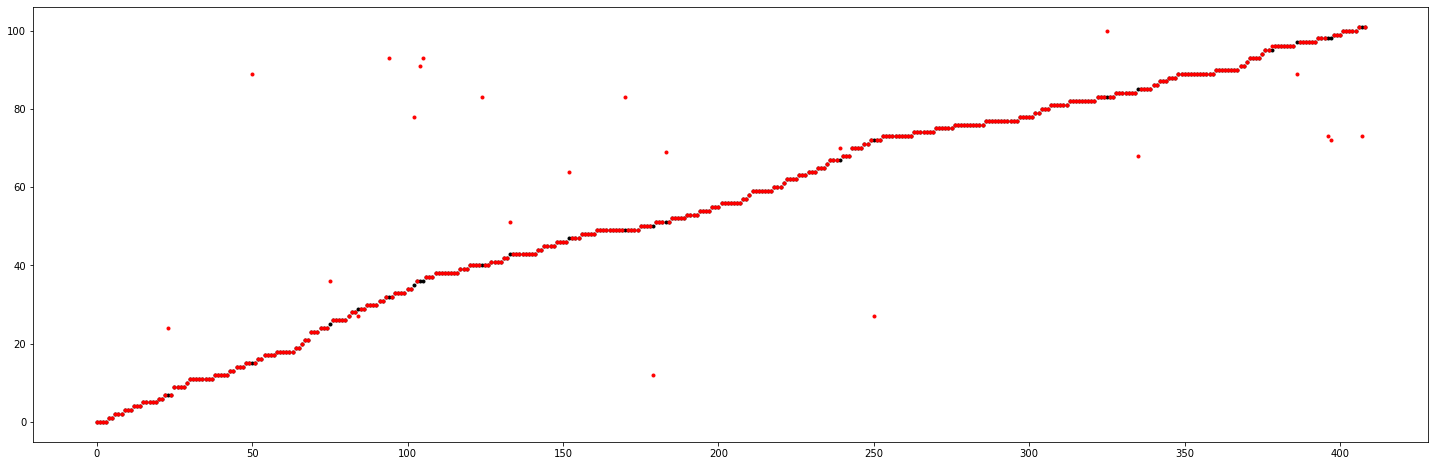

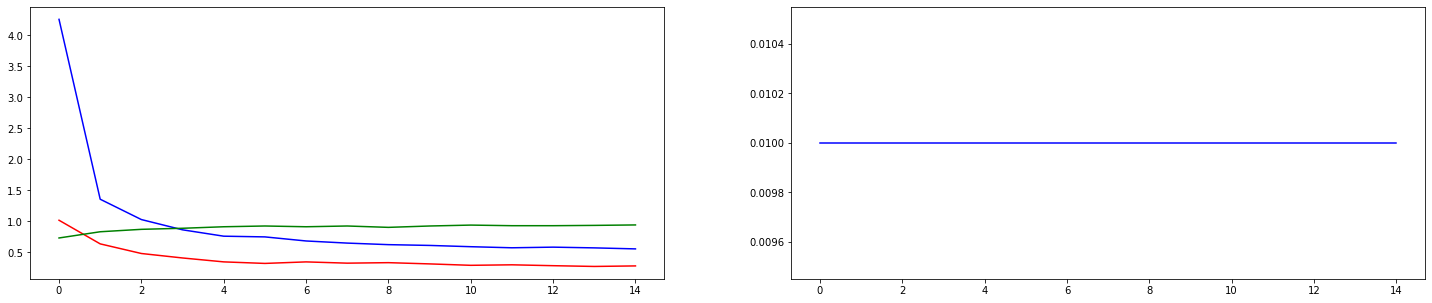

Epoch: 16:                lr: 0.01000000	               Training Loss: 0.521921	               Validation Loss: 0.292063	               Validation accuracy: 92.91%	               Elapsed time: 512.81


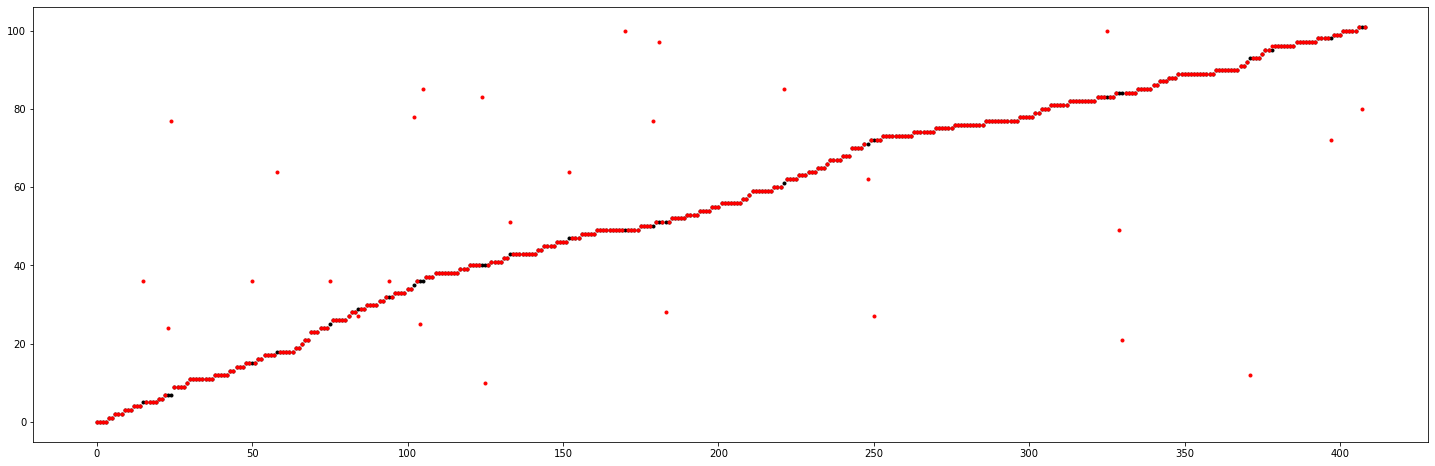

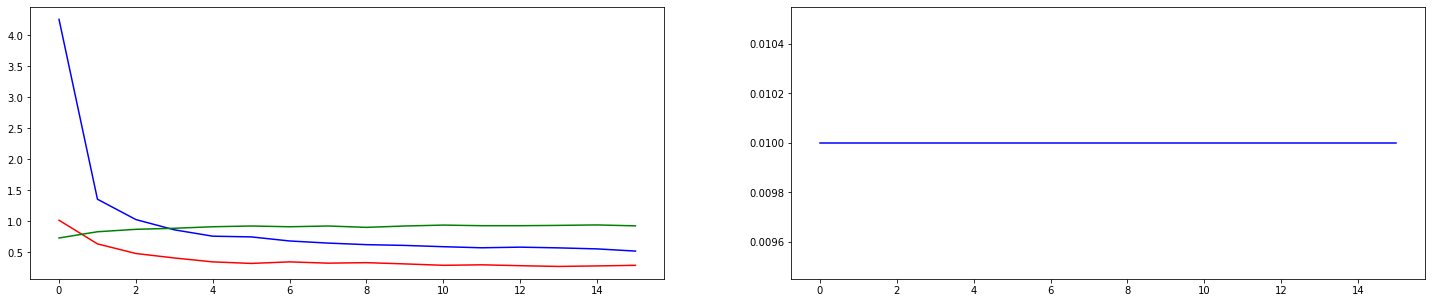

Epoch: 17:                lr: 0.01000000	               Training Loss: 0.520593	               Validation Loss: 0.261046	               Validation accuracy: 93.64%	               Elapsed time: 536.29
Validation loss decreased:                   (0.274110 --> 0.261046).   Saving model ...


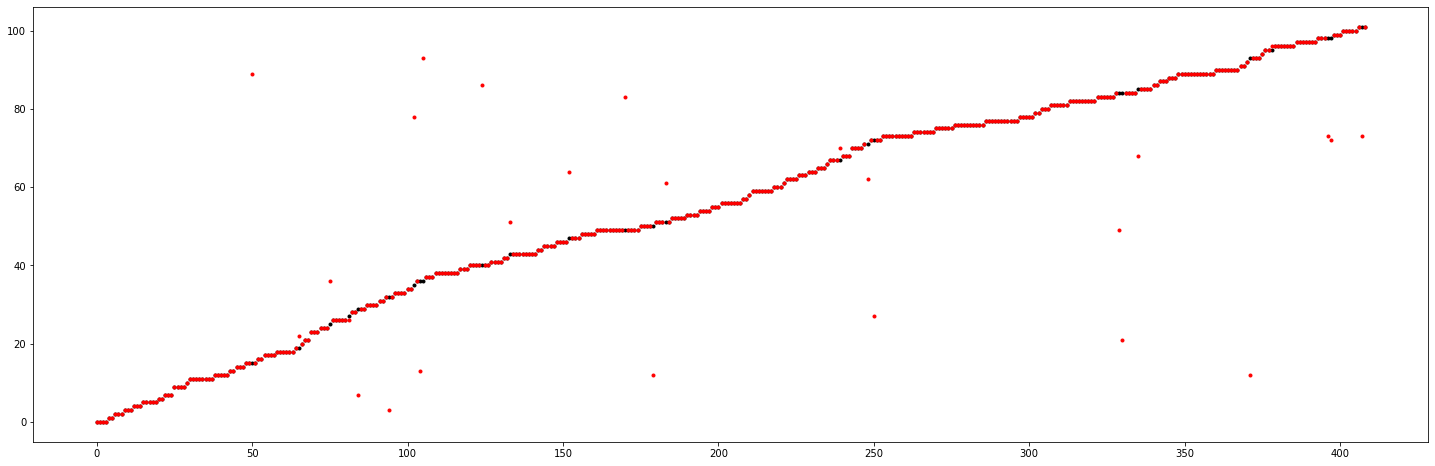

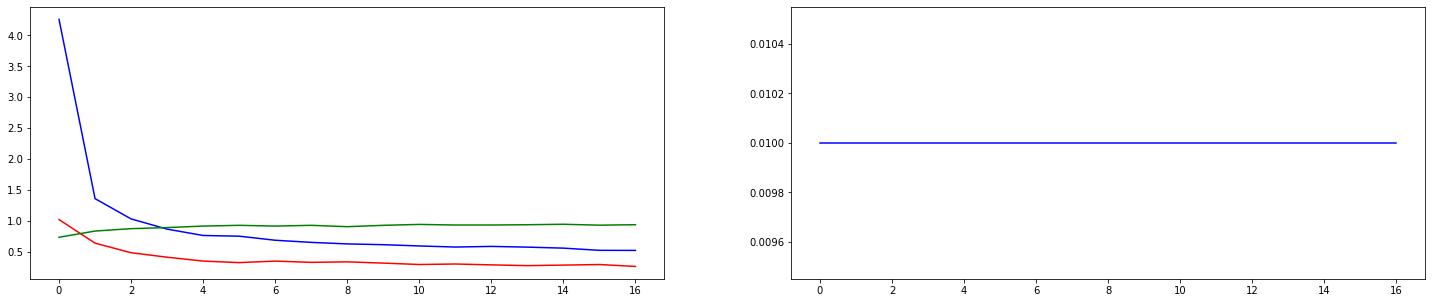

Epoch: 18:                lr: 0.01000000	               Training Loss: 0.507978	               Validation Loss: 0.299460	               Validation accuracy: 92.67%	               Elapsed time: 561.44


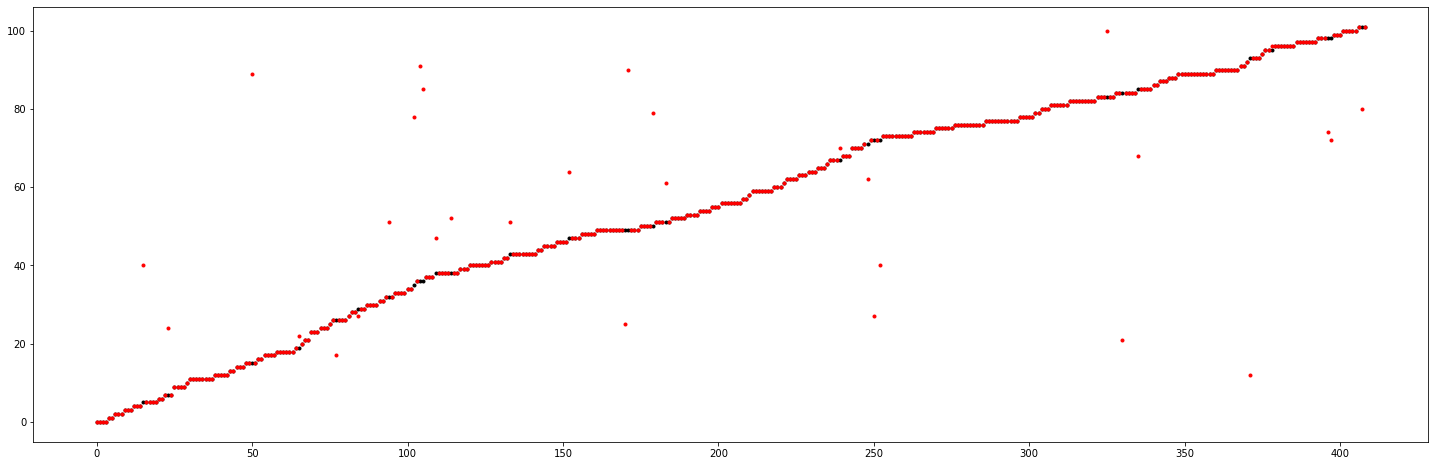

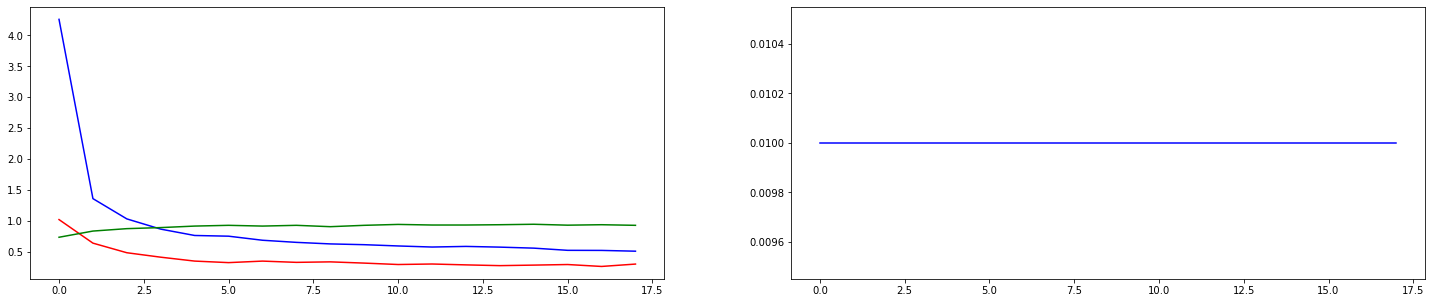

Epoch: 19:                lr: 0.01000000	               Training Loss: 0.526092	               Validation Loss: 0.292136	               Validation accuracy: 93.15%	               Elapsed time: 587.28


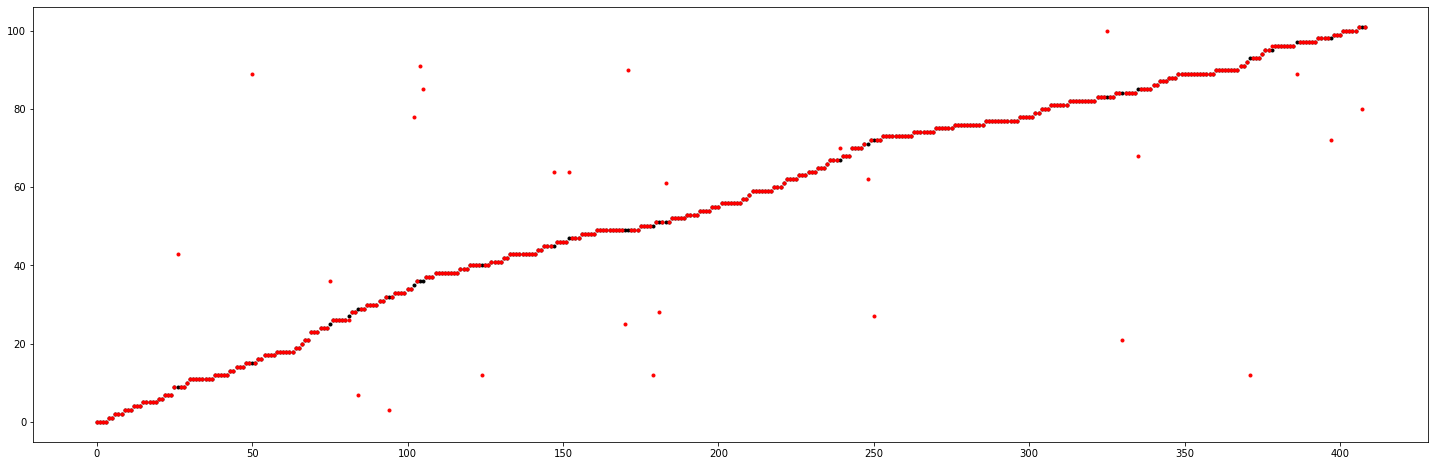

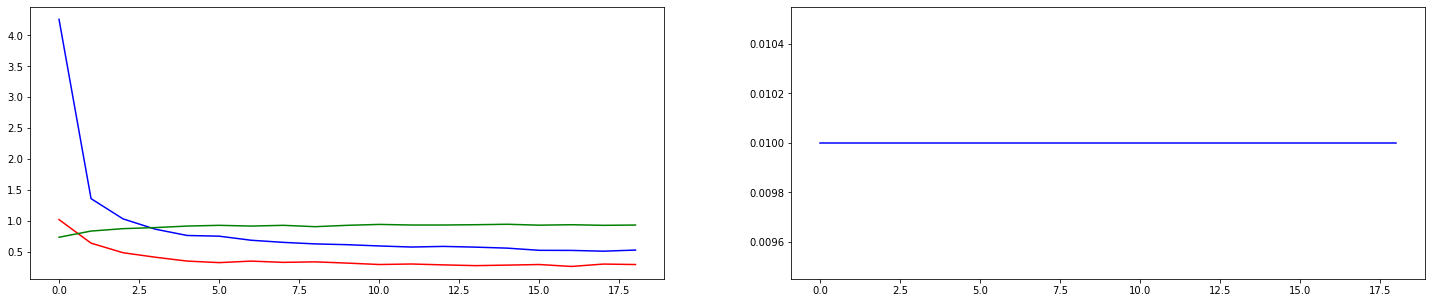

Epoch: 20:                lr: 0.01000000	               Training Loss: 0.509728	               Validation Loss: 0.266358	               Validation accuracy: 94.13%	               Elapsed time: 610.31


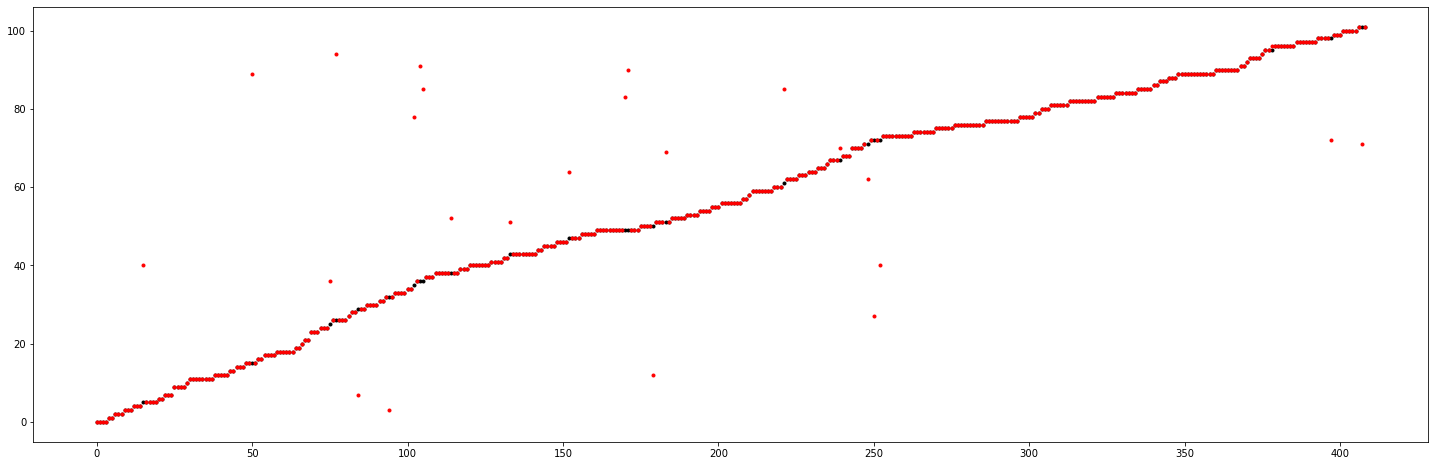

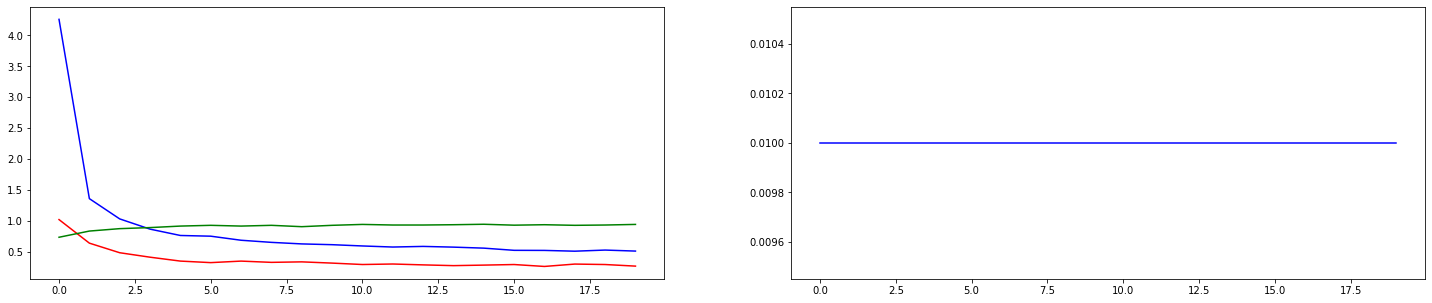

Epoch: 21:                lr: 0.01000000	               Training Loss: 0.477343	               Validation Loss: 0.282585	               Validation accuracy: 93.15%	               Elapsed time: 634.42


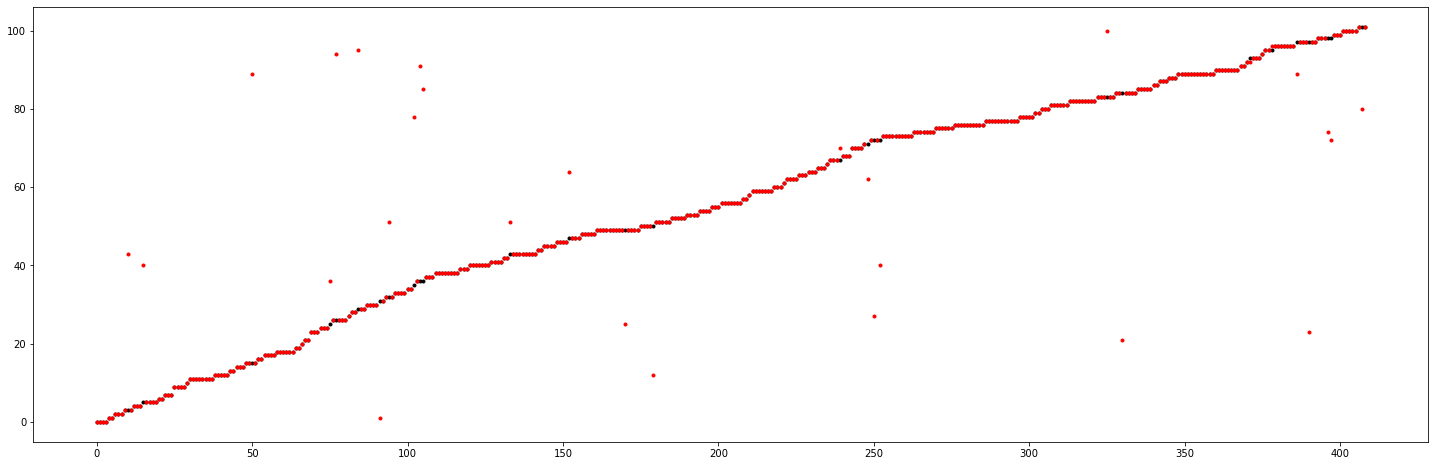

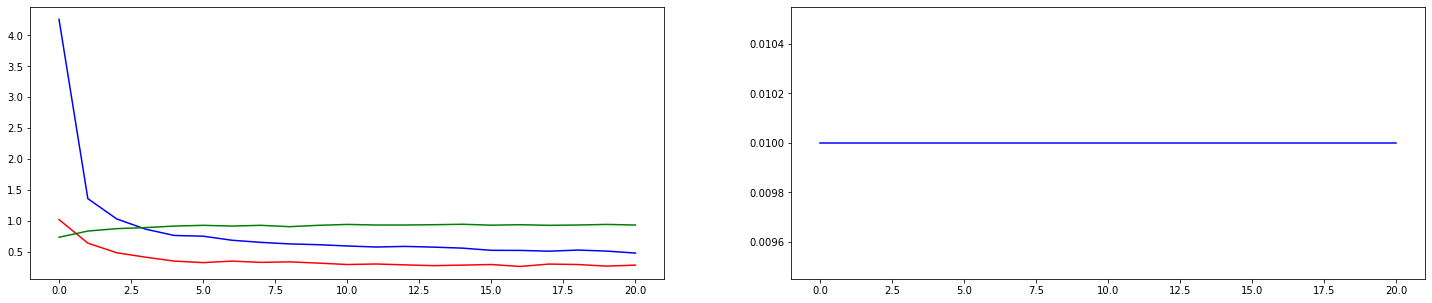

Epoch: 22:                lr: 0.01000000	               Training Loss: 0.483131	               Validation Loss: 0.290776	               Validation accuracy: 92.18%	               Elapsed time: 660.27


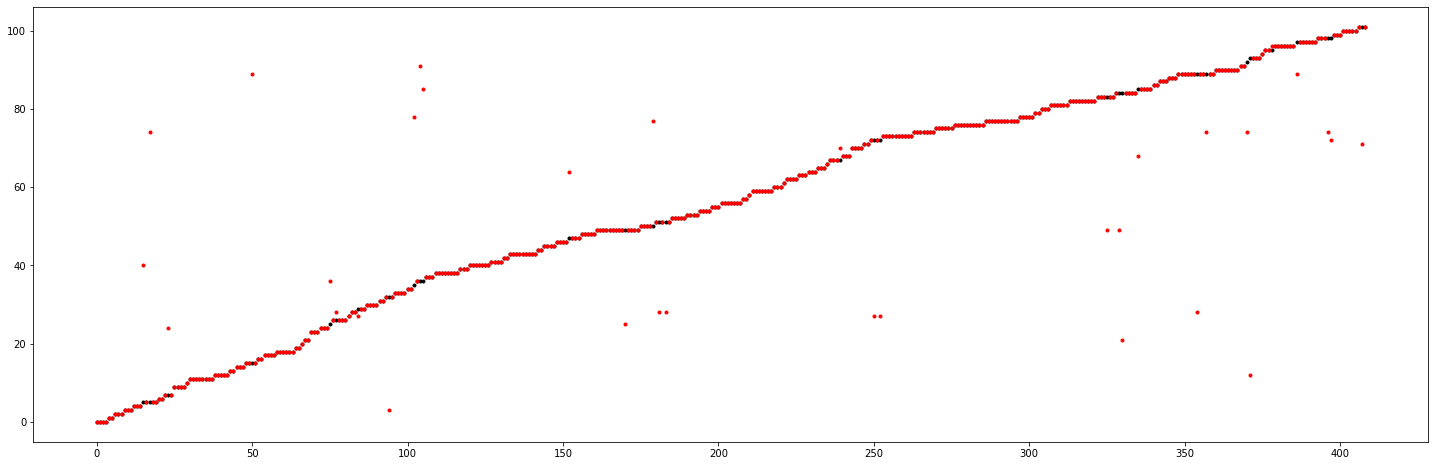

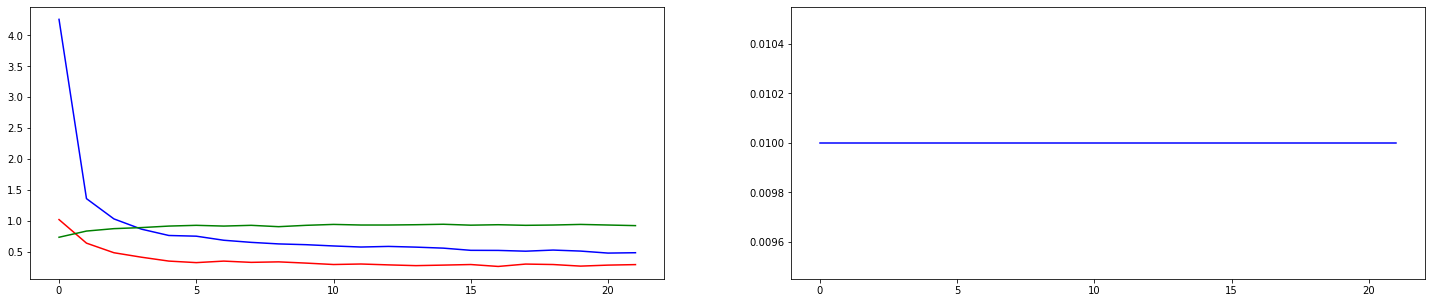

Epoch: 23:                lr: 0.01000000	               Training Loss: 0.471507	               Validation Loss: 0.250918	               Validation accuracy: 94.13%	               Elapsed time: 683.34
Validation loss decreased:                   (0.261046 --> 0.250918).   Saving model ...


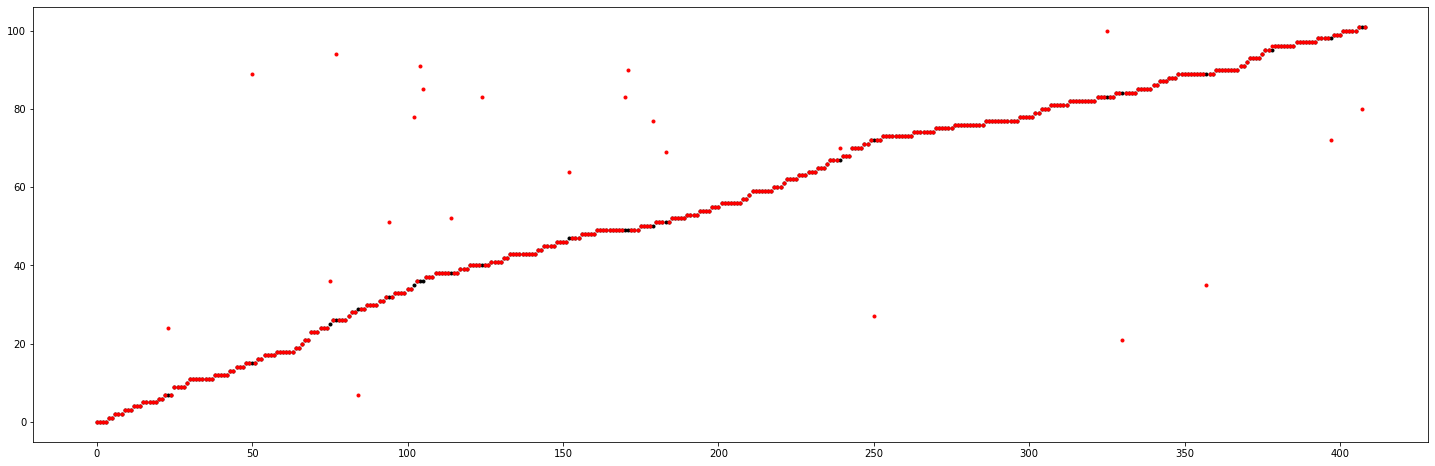

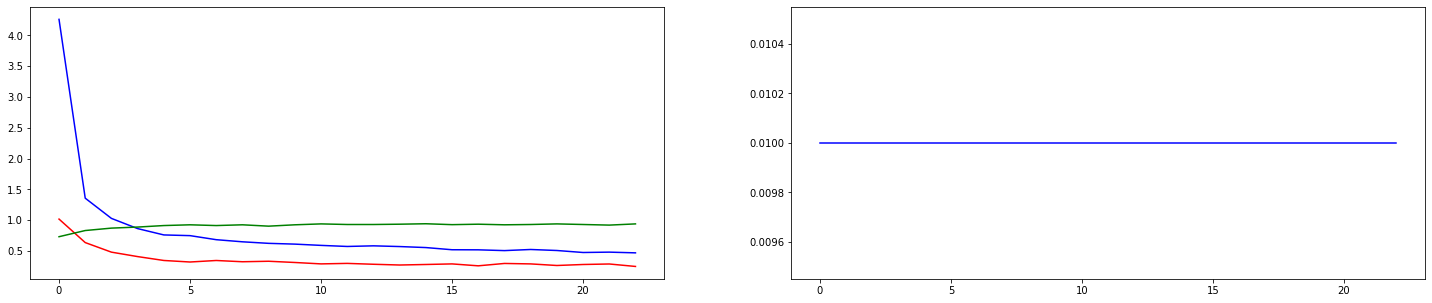

Epoch: 24:                lr: 0.01000000	               Training Loss: 0.480284	               Validation Loss: 0.262880	               Validation accuracy: 93.15%	               Elapsed time: 705.68


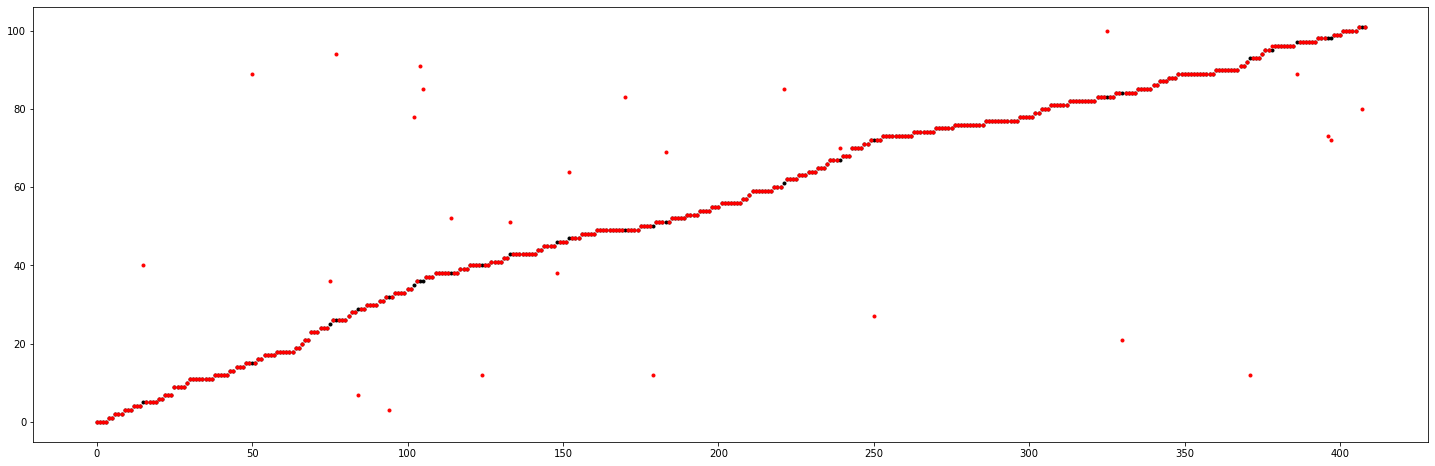

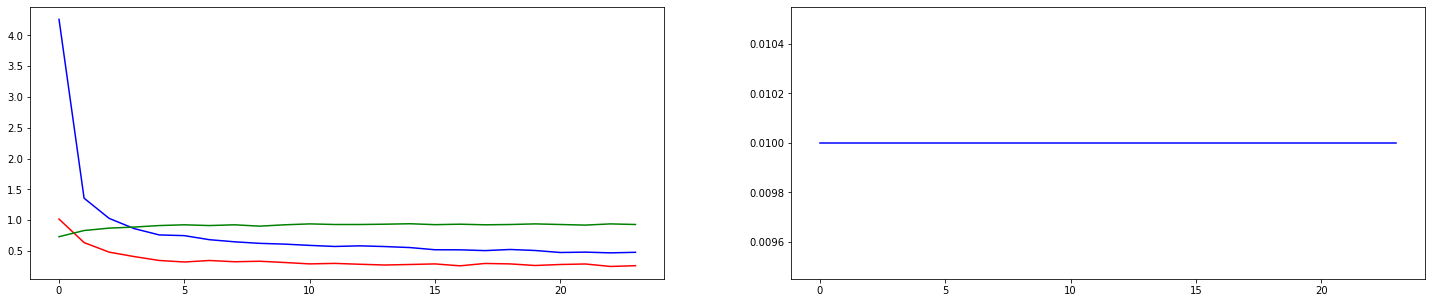

Epoch: 25:                lr: 0.01000000	               Training Loss: 0.482367	               Validation Loss: 0.235150	               Validation accuracy: 93.89%	               Elapsed time: 727.32
Validation loss decreased:                   (0.250918 --> 0.235150).   Saving model ...


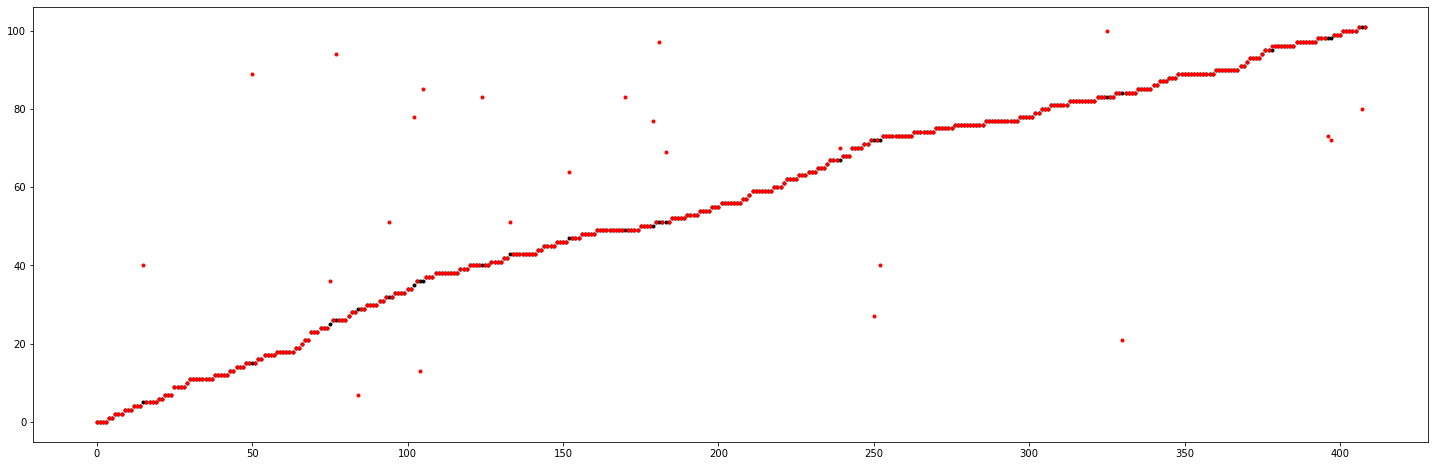

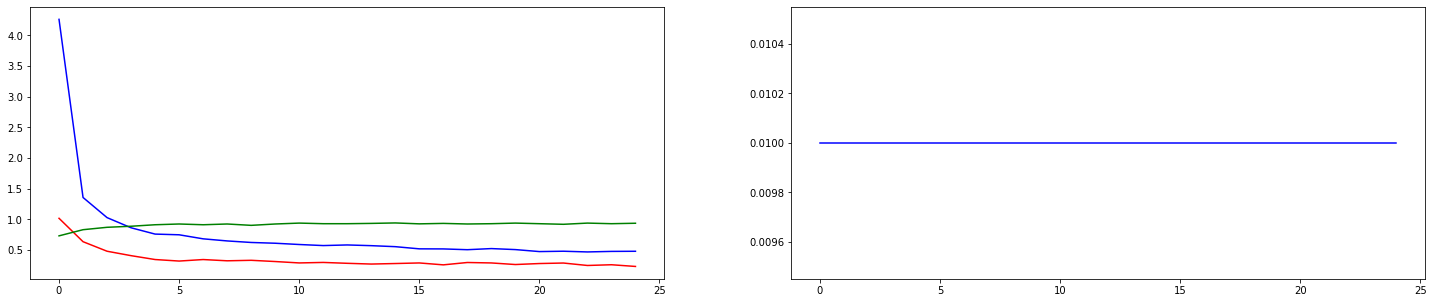

Epoch: 26:                lr: 0.01000000	               Training Loss: 0.468804	               Validation Loss: 0.255410	               Validation accuracy: 93.40%	               Elapsed time: 748.72


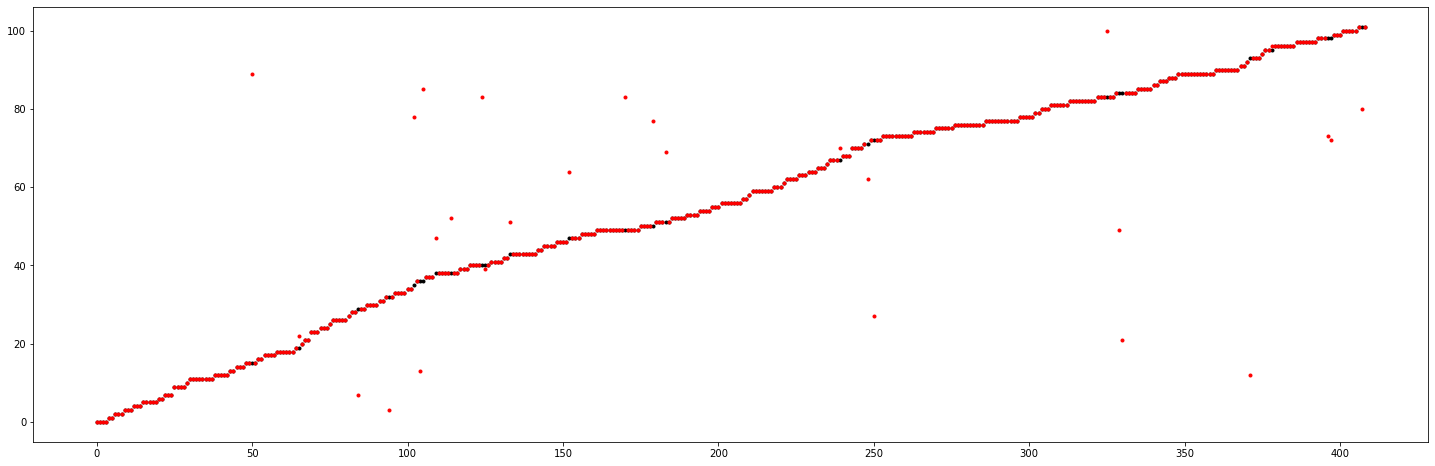

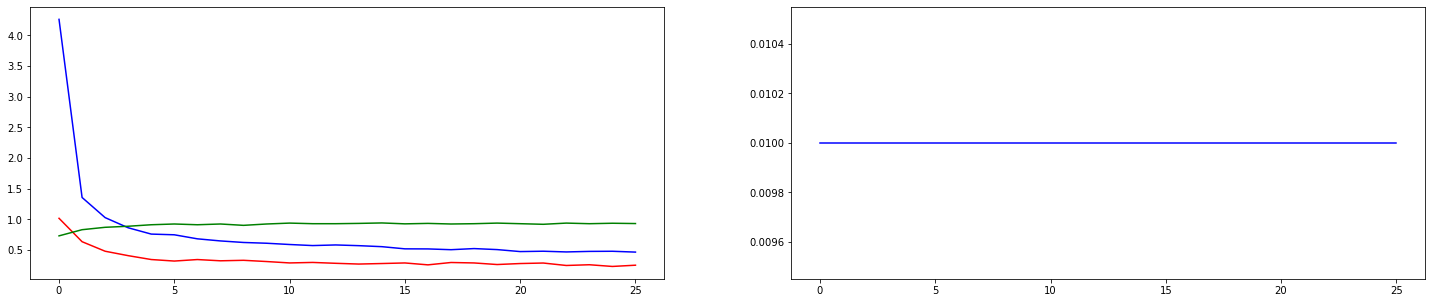

Epoch: 27:                lr: 0.01000000	               Training Loss: 0.459971	               Validation Loss: 0.254609	               Validation accuracy: 93.64%	               Elapsed time: 770.32


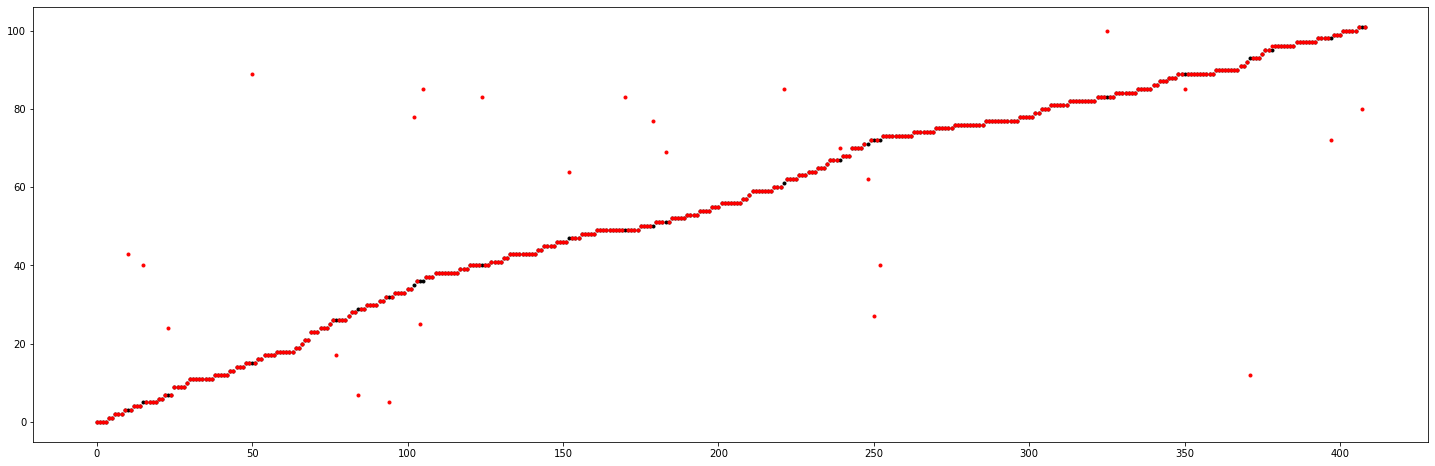

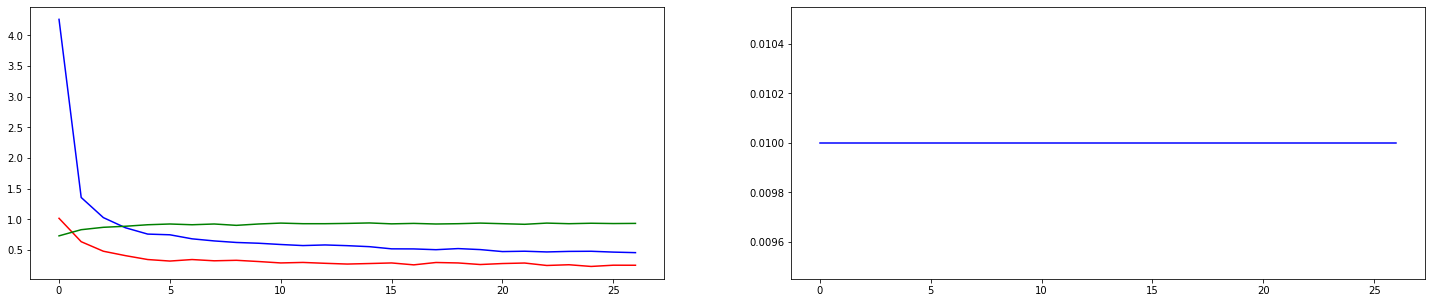

Epoch: 28:                lr: 0.01000000	               Training Loss: 0.472187	               Validation Loss: 0.255950	               Validation accuracy: 93.89%	               Elapsed time: 793.05


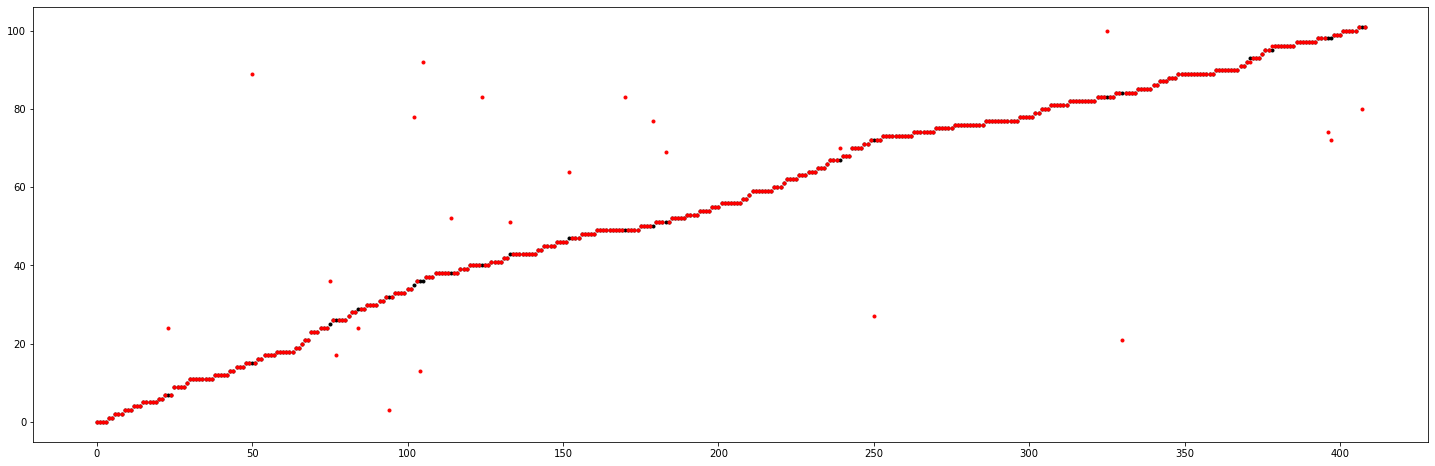

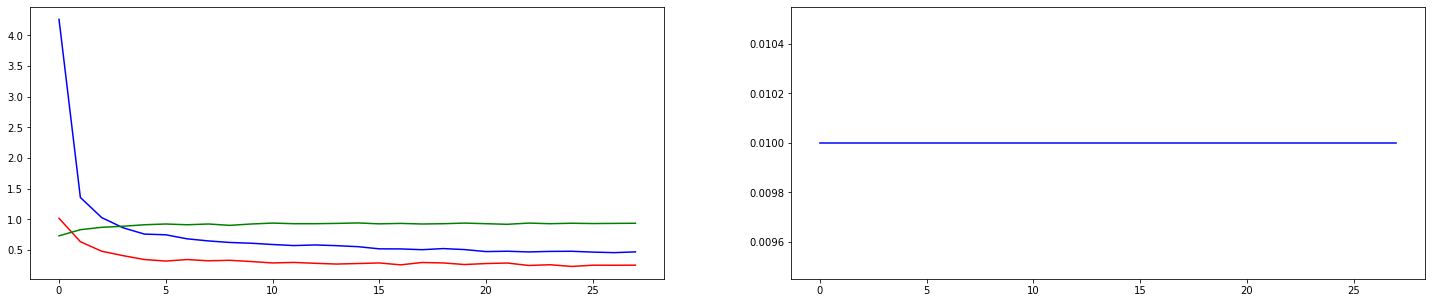

Epoch: 29:                lr: 0.01000000	               Training Loss: 0.460354	               Validation Loss: 0.250402	               Validation accuracy: 94.62%	               Elapsed time: 819.44


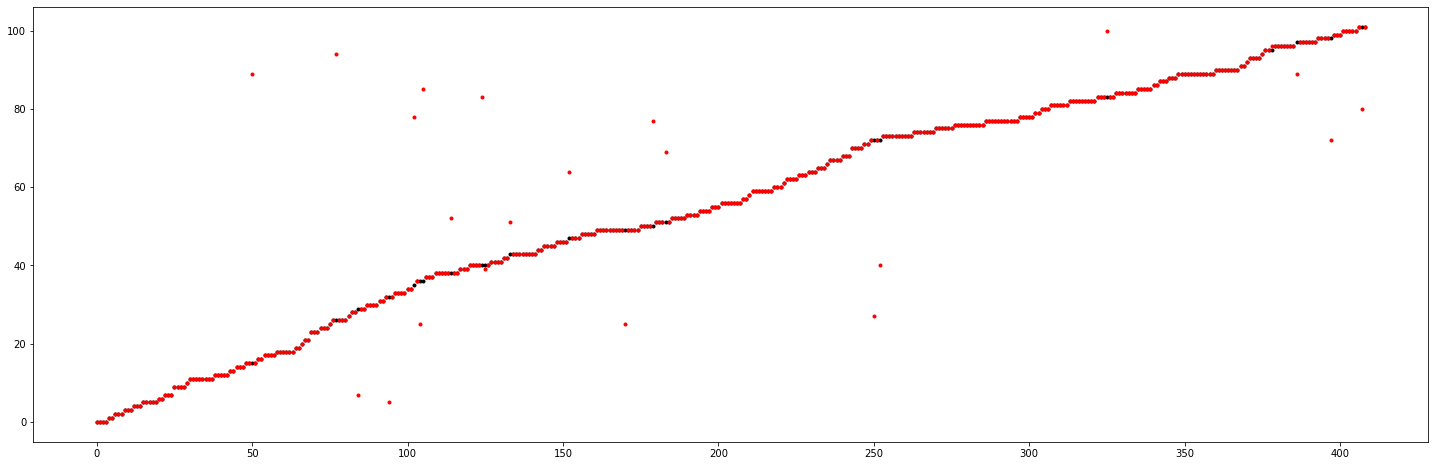

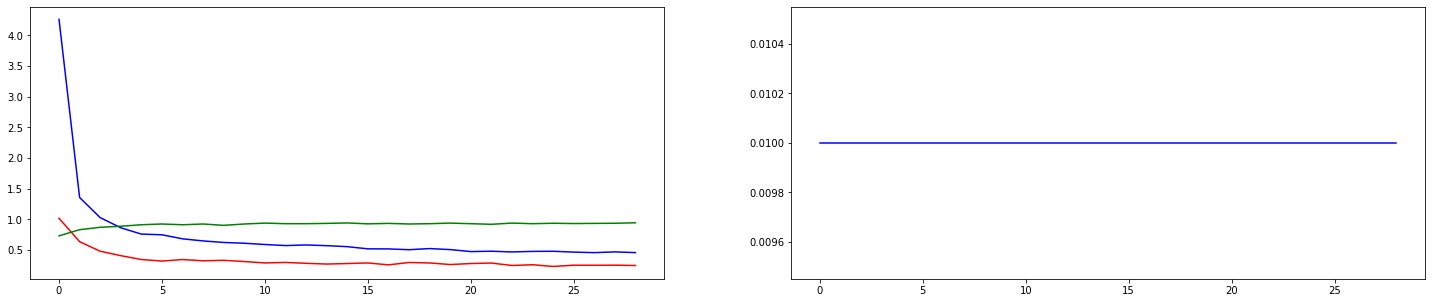

Epoch: 30:                lr: 0.01000000	               Training Loss: 0.475580	               Validation Loss: 0.247655	               Validation accuracy: 94.38%	               Elapsed time: 843.52


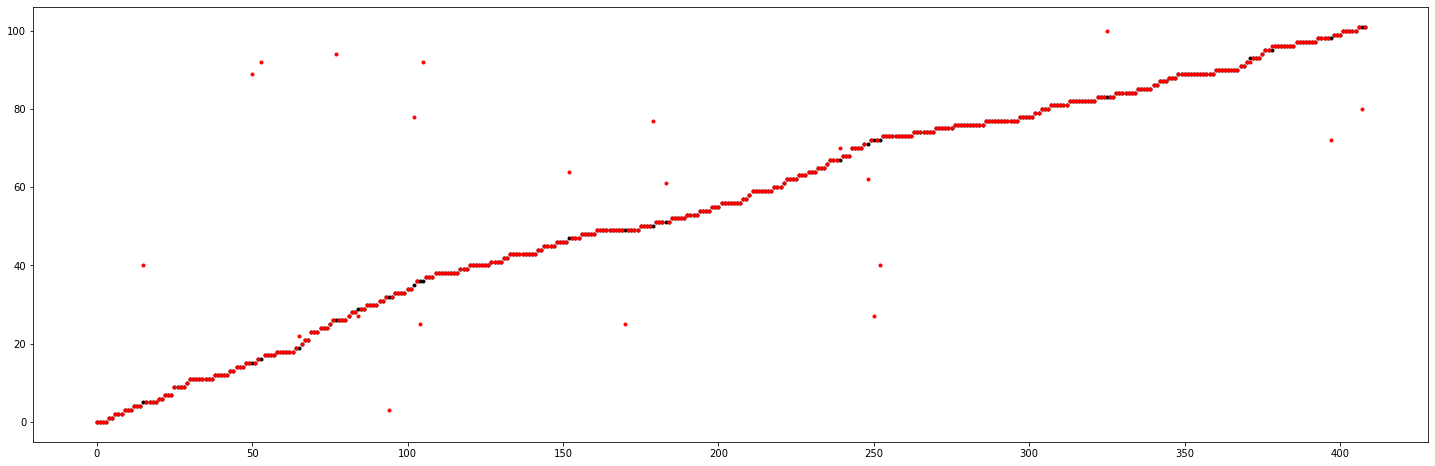

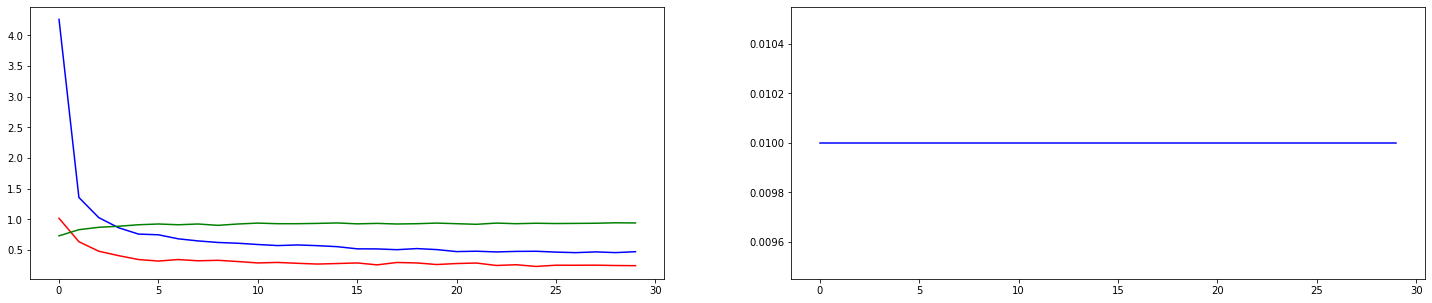

Epoch: 31:                lr: 0.01000000	               Training Loss: 0.437924	               Validation Loss: 0.264445	               Validation accuracy: 93.64%	               Elapsed time: 867.66


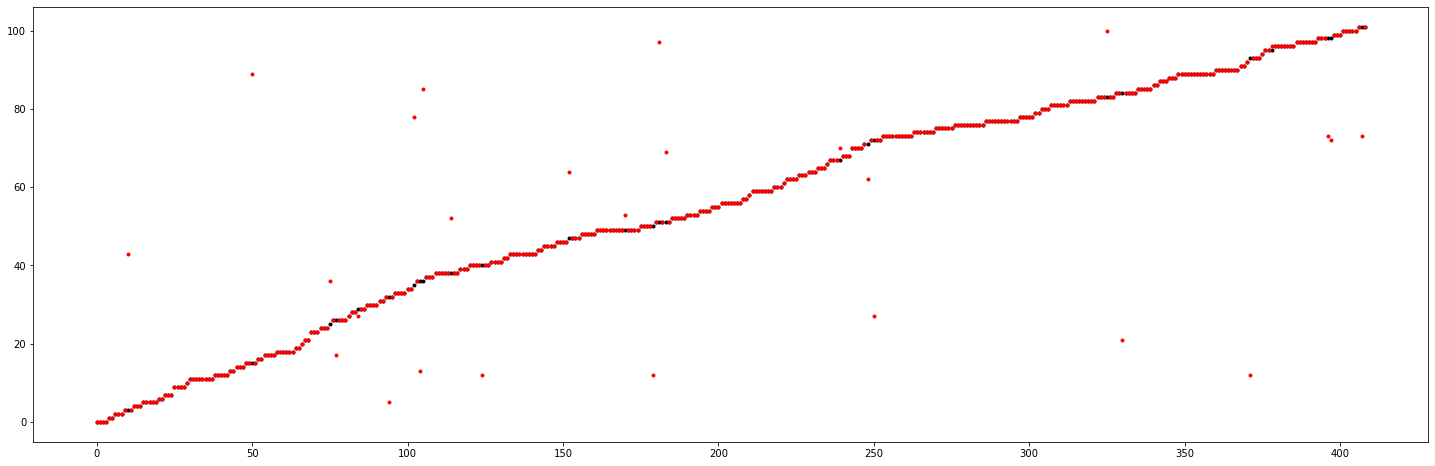

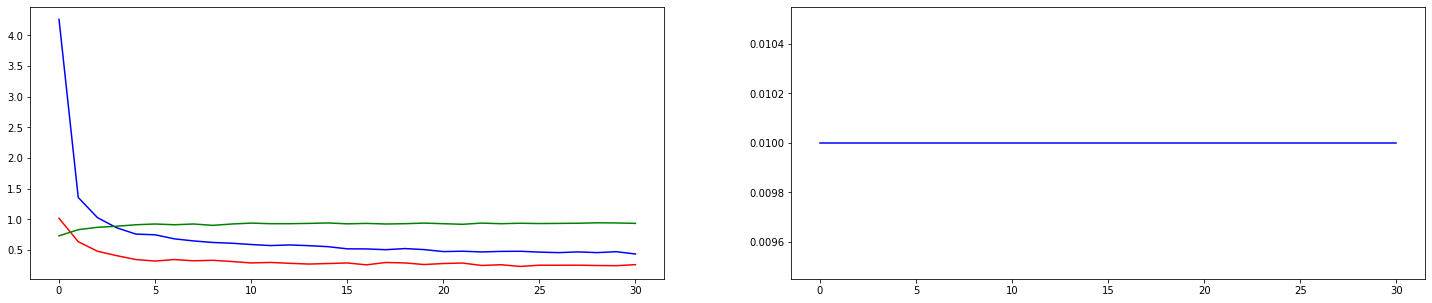

Epoch: 32:                lr: 0.00100000	               Training Loss: 0.438469	               Validation Loss: 0.245045	               Validation accuracy: 94.13%	               Elapsed time: 891.01


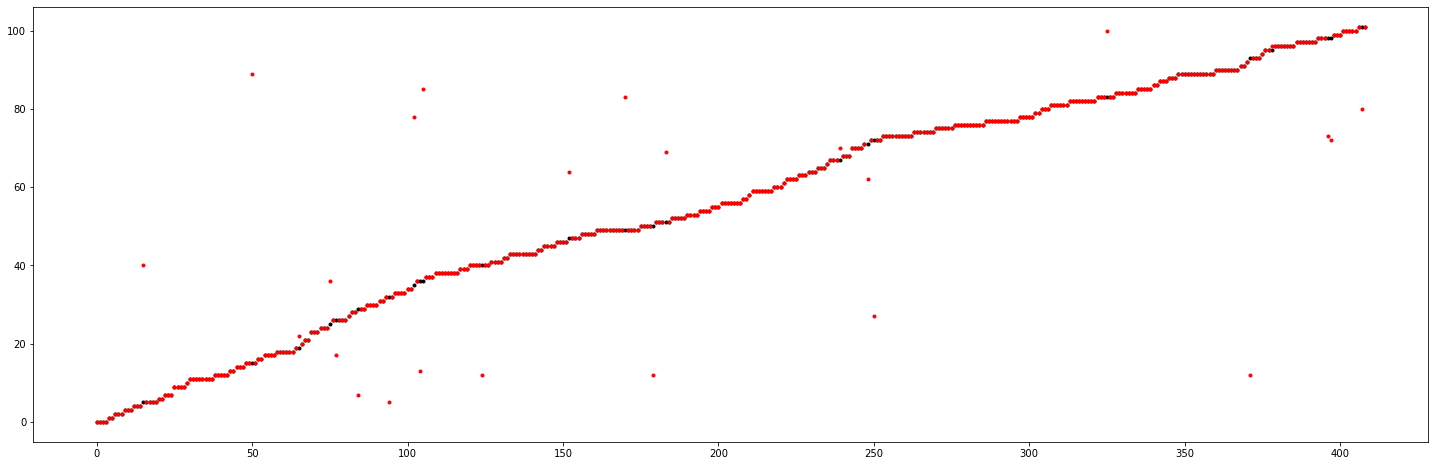

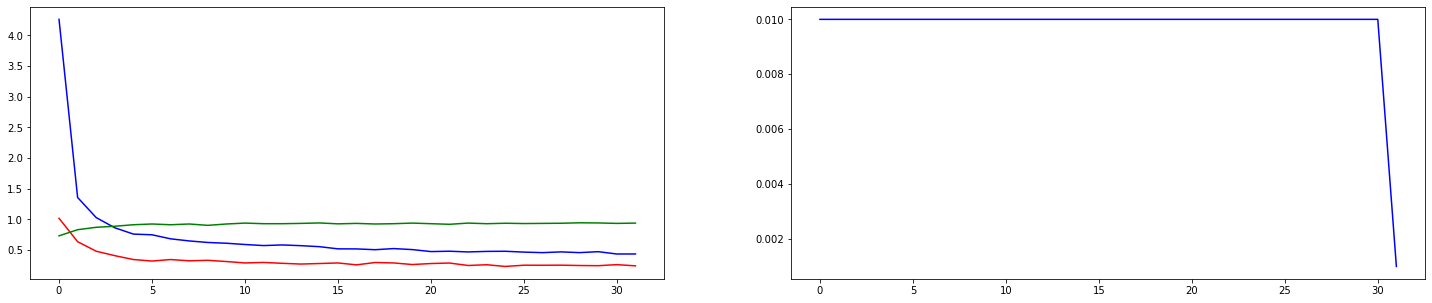

Epoch: 33:                lr: 0.00100000	               Training Loss: 0.416349	               Validation Loss: 0.241775	               Validation accuracy: 94.62%	               Elapsed time: 914.68


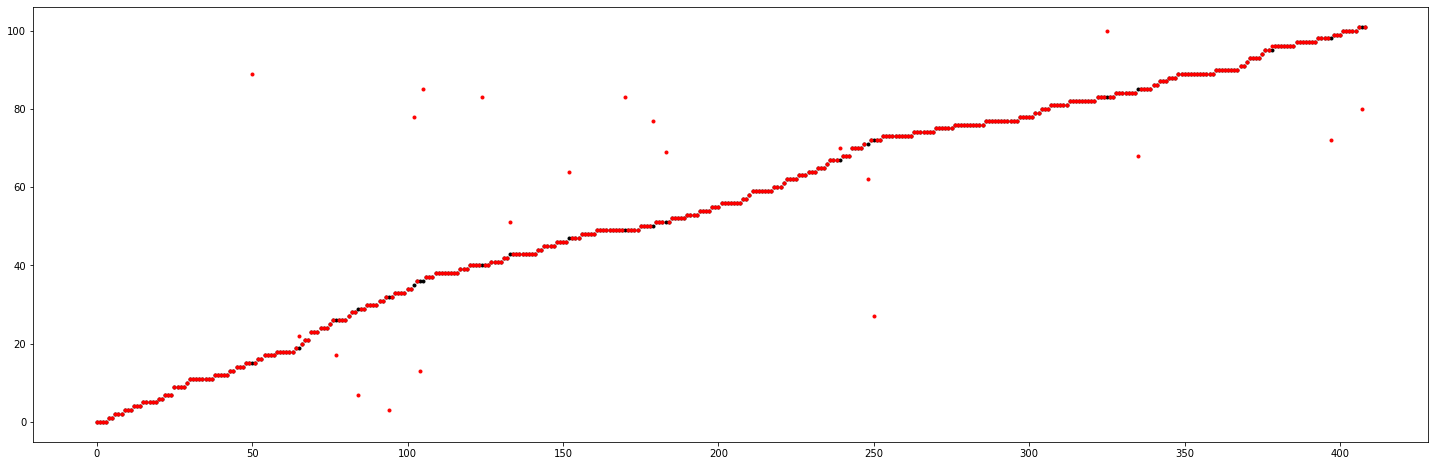

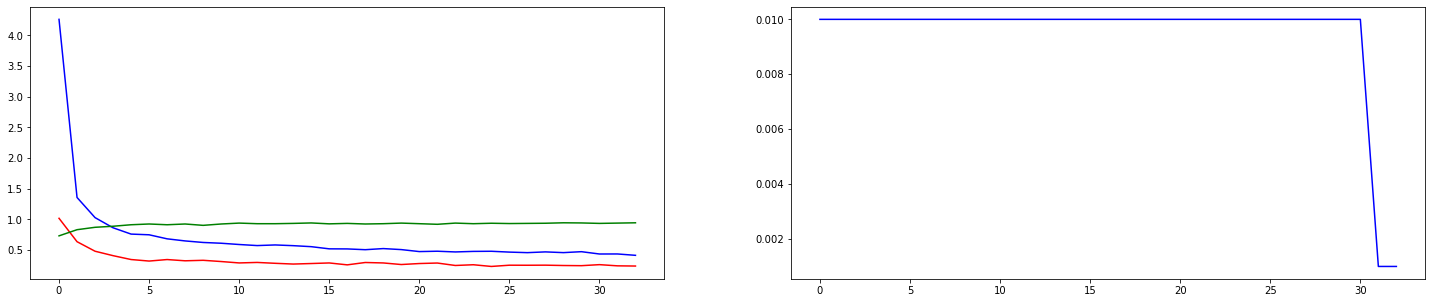

Epoch: 34:                lr: 0.00100000	               Training Loss: 0.376642	               Validation Loss: 0.235635	               Validation accuracy: 94.87%	               Elapsed time: 937.60


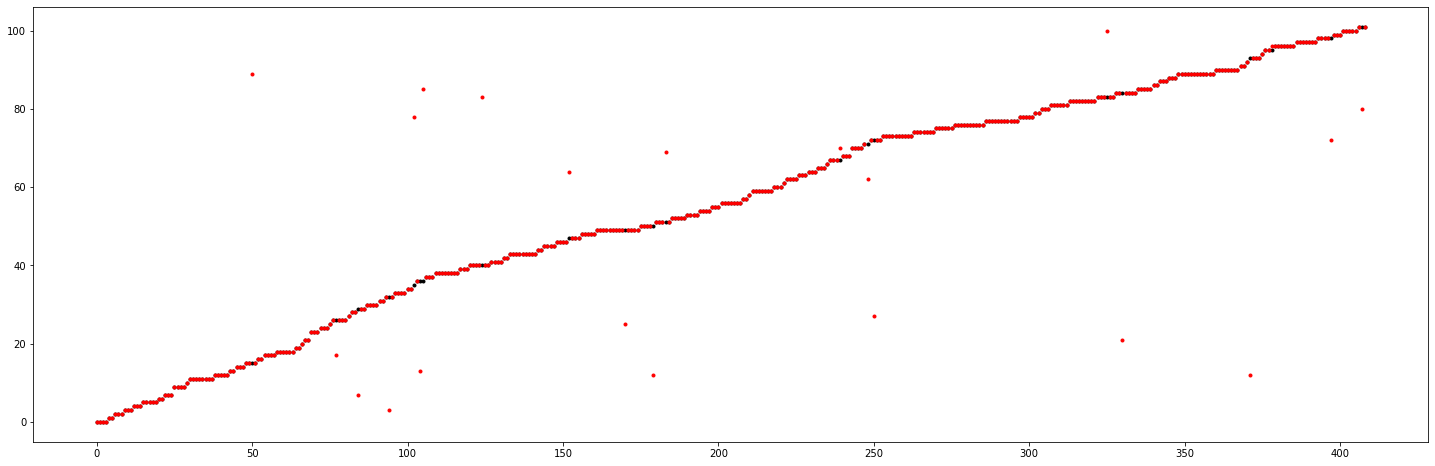

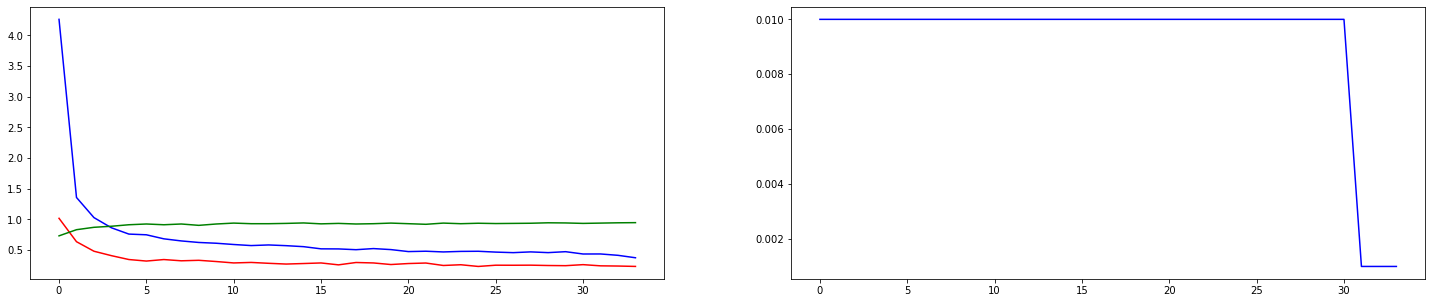

Epoch: 35:                lr: 0.00100000	               Training Loss: 0.400250	               Validation Loss: 0.237202	               Validation accuracy: 94.62%	               Elapsed time: 960.94


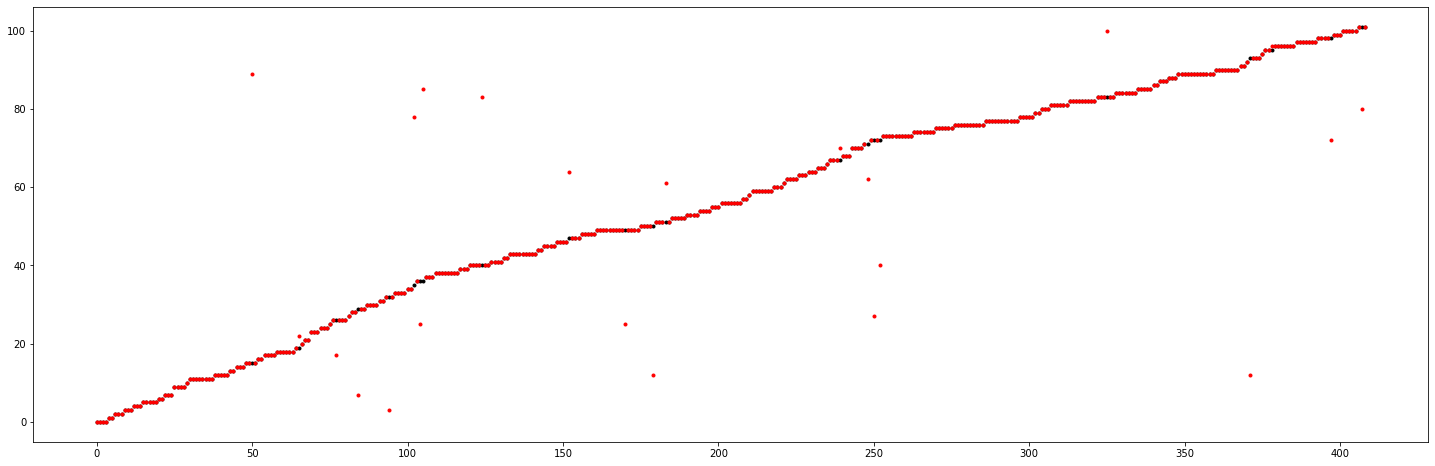

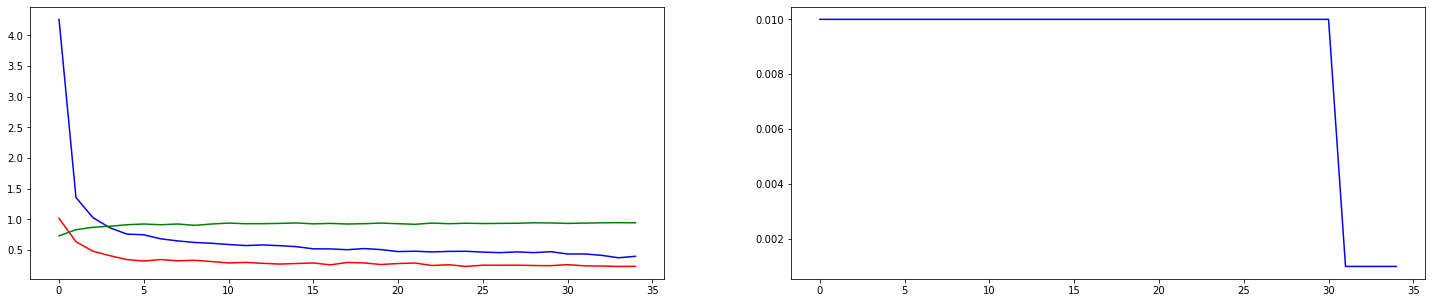

Epoch: 36:                lr: 0.00100000	               Training Loss: 0.412148	               Validation Loss: 0.234960	               Validation accuracy: 94.38%	               Elapsed time: 985.85
Validation loss decreased:                   (0.235150 --> 0.234960).   Saving model ...


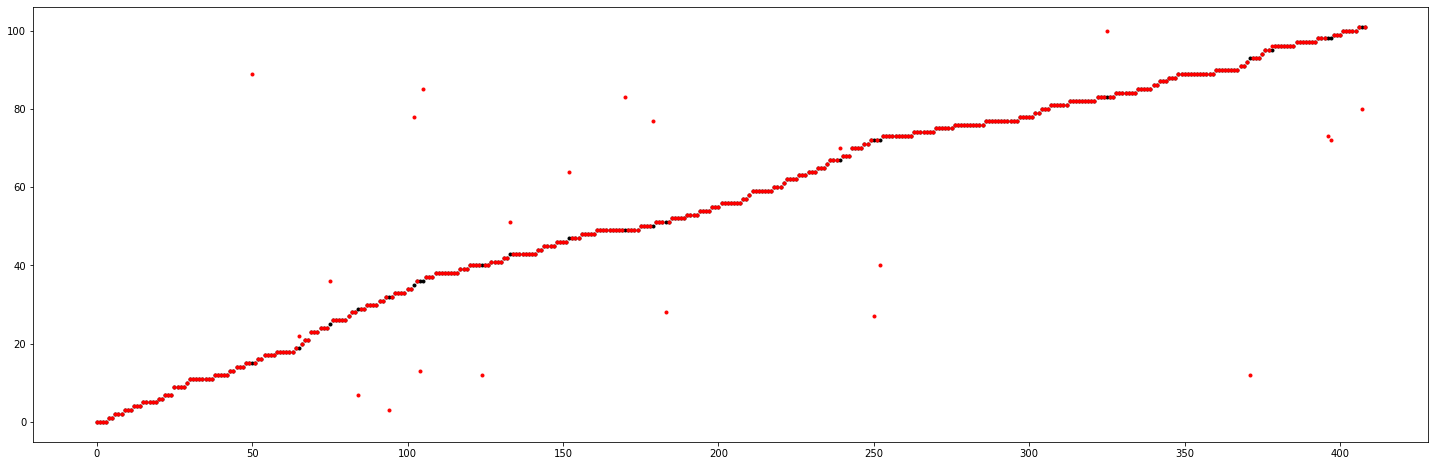

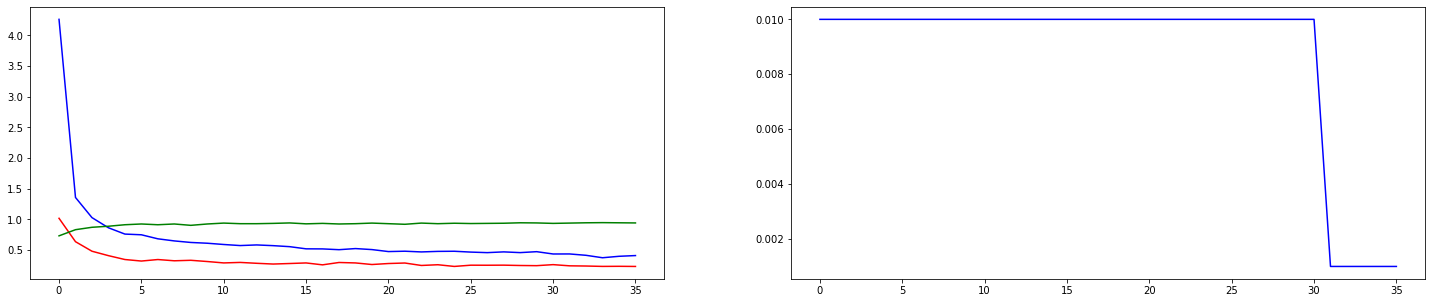

Epoch: 37:                lr: 0.00100000	               Training Loss: 0.381974	               Validation Loss: 0.236641	               Validation accuracy: 93.89%	               Elapsed time: 1013.43


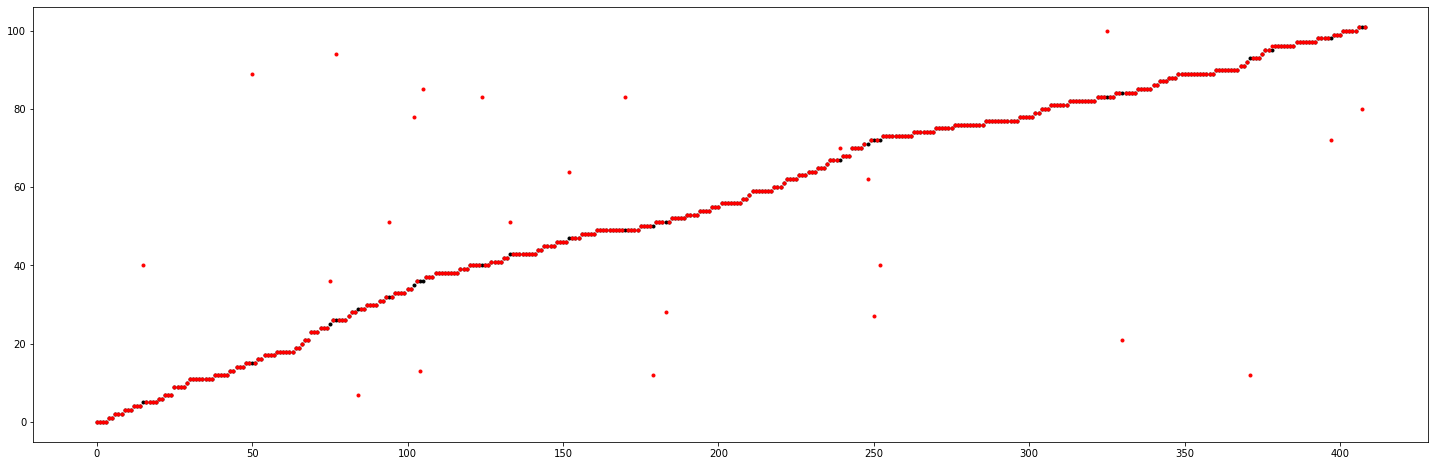

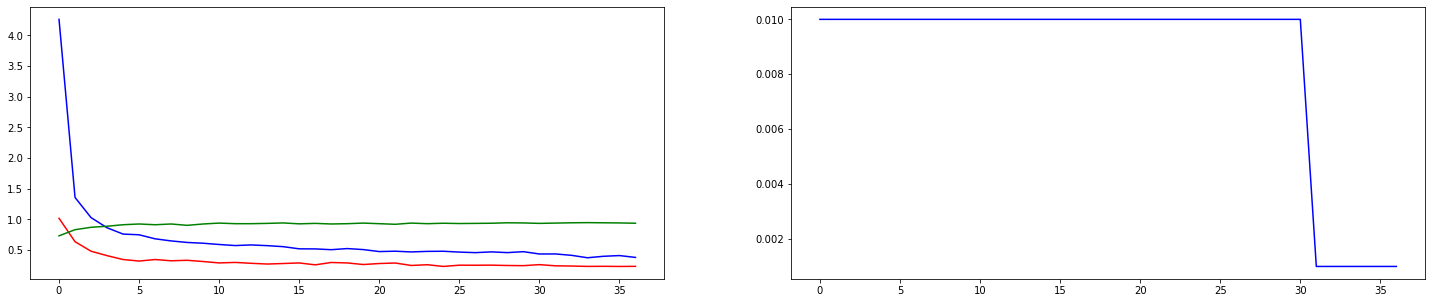

Epoch: 38:                lr: 0.00010000	               Training Loss: 0.403761	               Validation Loss: 0.239403	               Validation accuracy: 94.38%	               Elapsed time: 1037.13


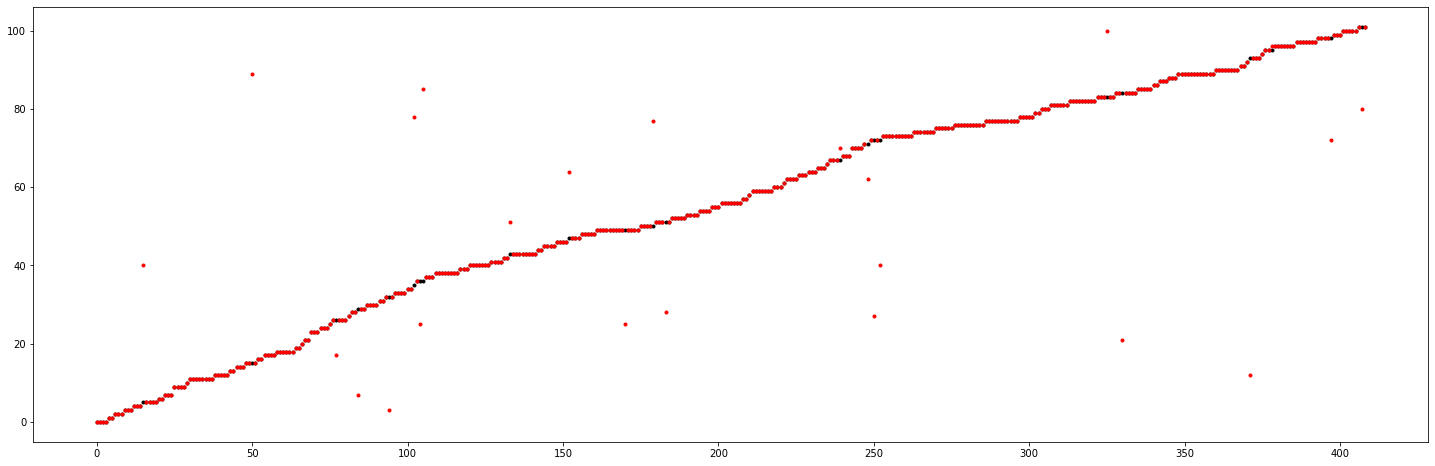

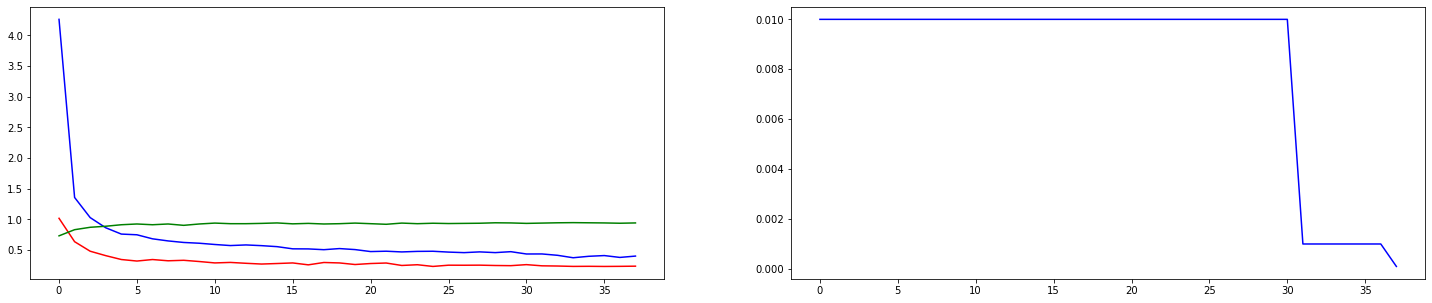

Epoch: 39:                lr: 0.00010000	               Training Loss: 0.400991	               Validation Loss: 0.240298	               Validation accuracy: 94.13%	               Elapsed time: 1060.43


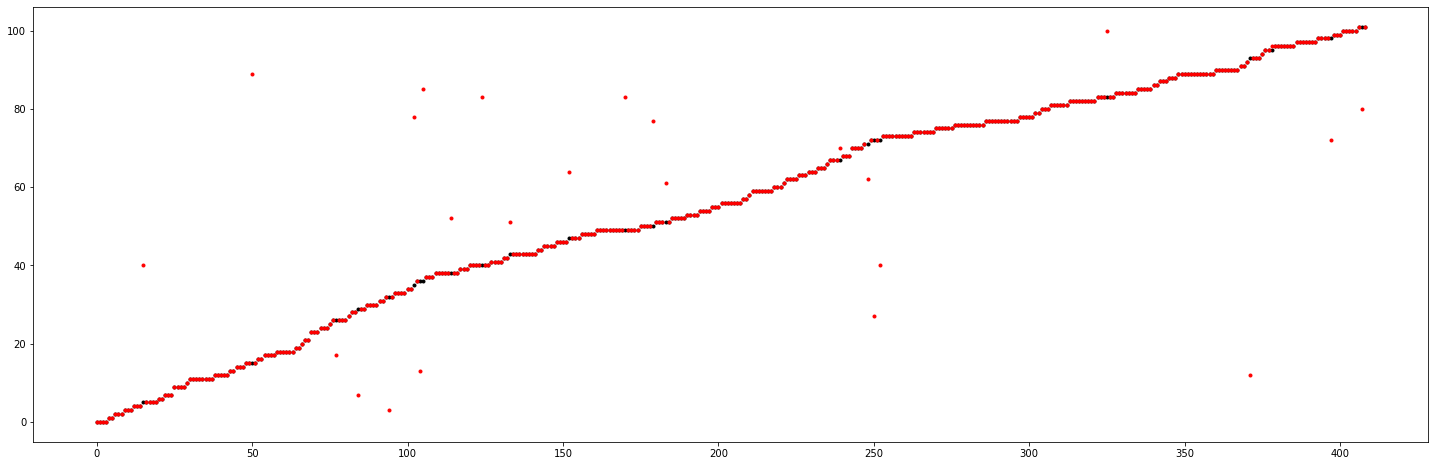

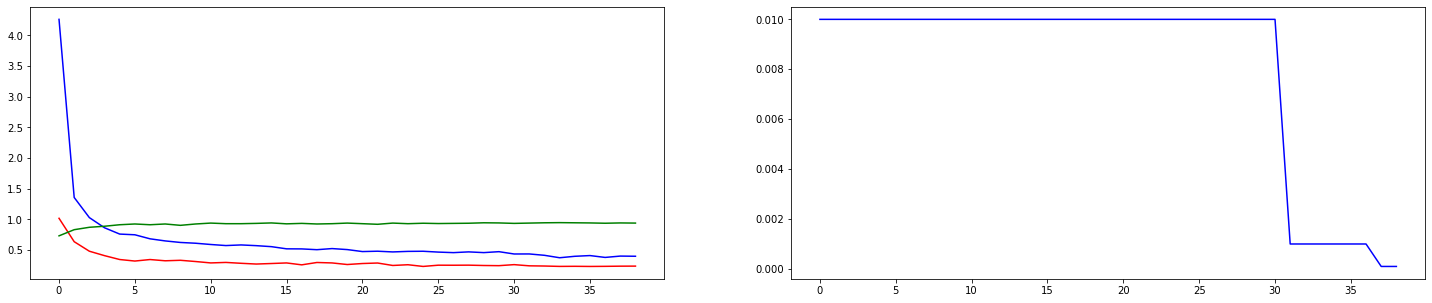

Epoch: 40:                lr: 0.00010000	               Training Loss: 0.369990	               Validation Loss: 0.238797	               Validation accuracy: 94.38%	               Elapsed time: 1085.24


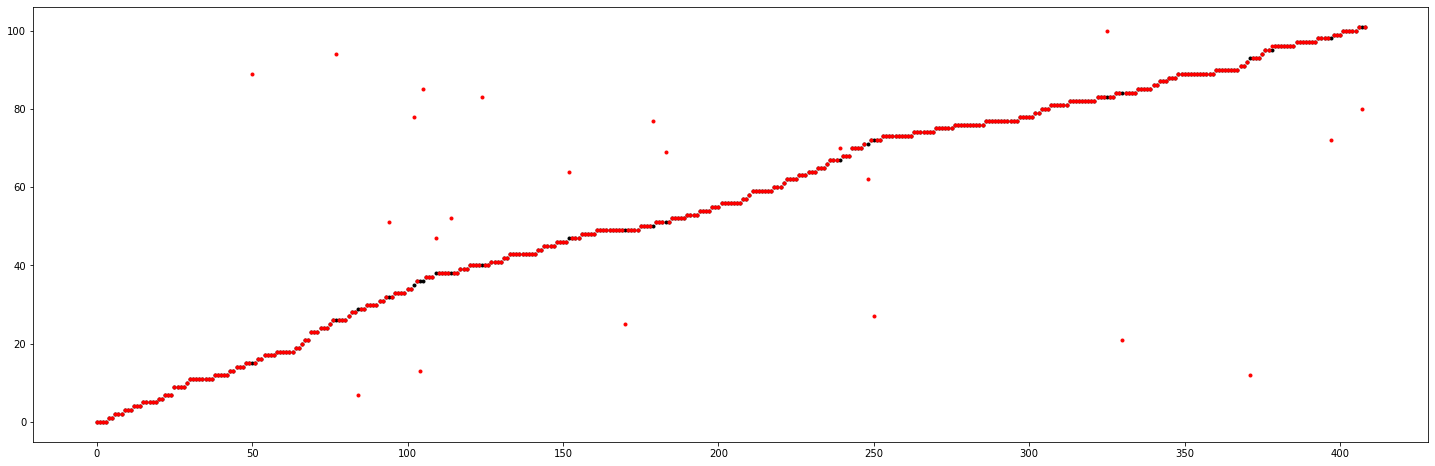

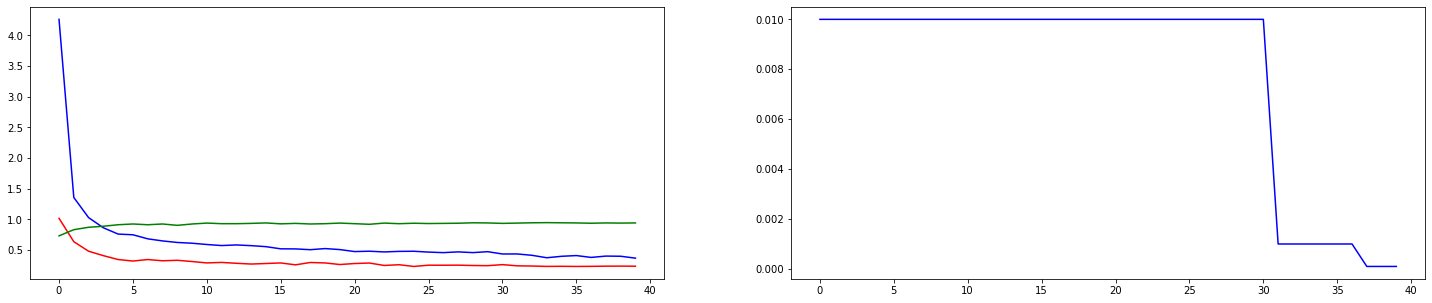

Epoch: 41:                lr: 0.00010000	               Training Loss: 0.379665	               Validation Loss: 0.242179	               Validation accuracy: 94.38%	               Elapsed time: 1109.58


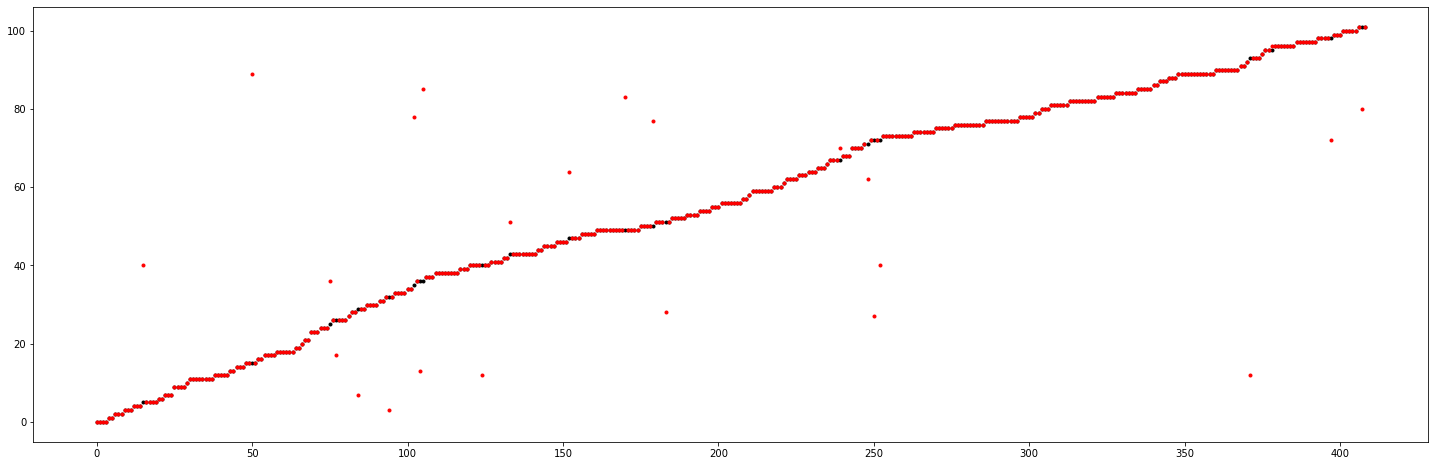

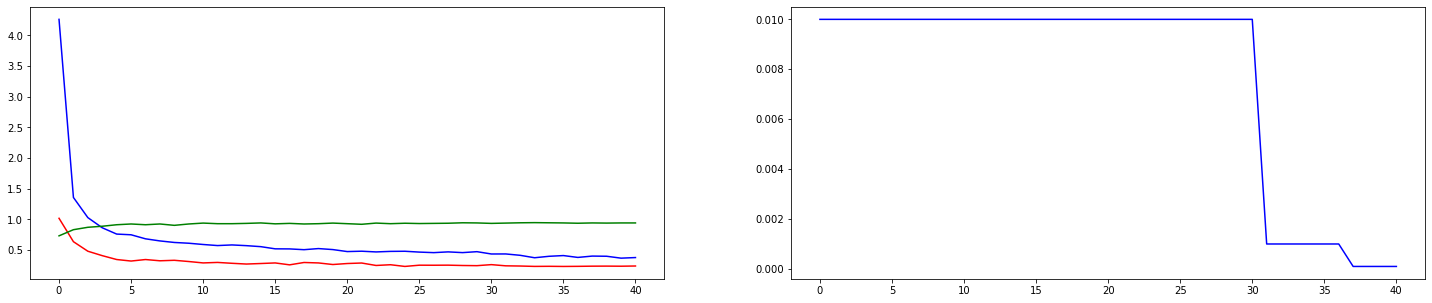

Epoch: 42:                lr: 0.00010000	               Training Loss: 0.372928	               Validation Loss: 0.243696	               Validation accuracy: 93.89%	               Elapsed time: 1134.44


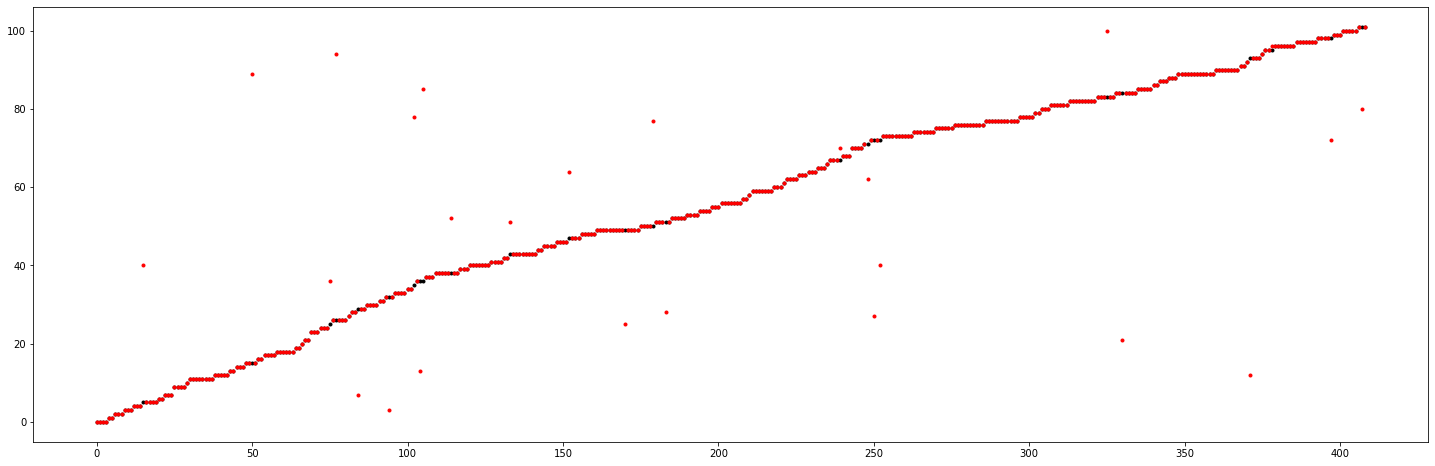

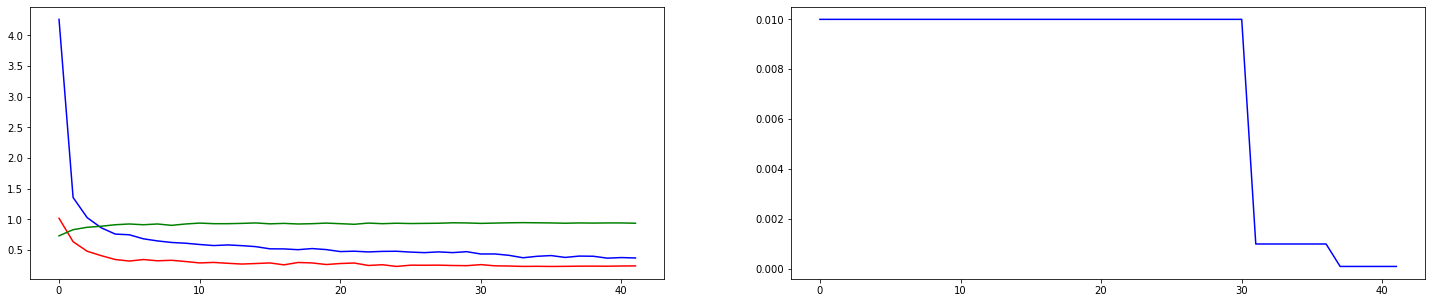

Epoch: 43:                lr: 0.00010000	               Training Loss: 0.383178	               Validation Loss: 0.227177	               Validation accuracy: 95.11%	               Elapsed time: 1156.64
Validation loss decreased:                   (0.234960 --> 0.227177).   Saving model ...


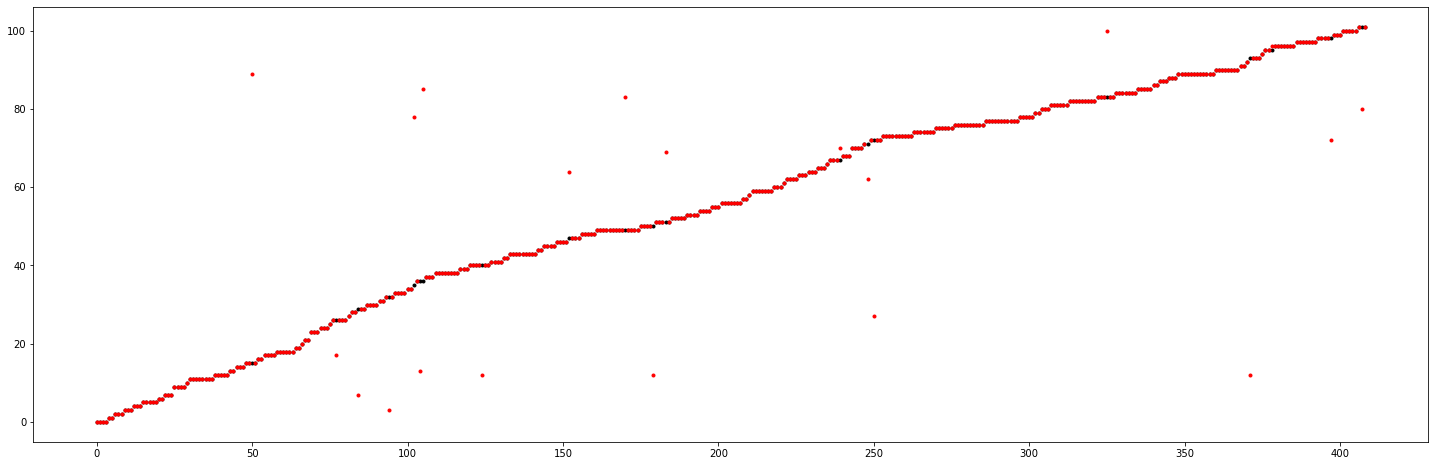

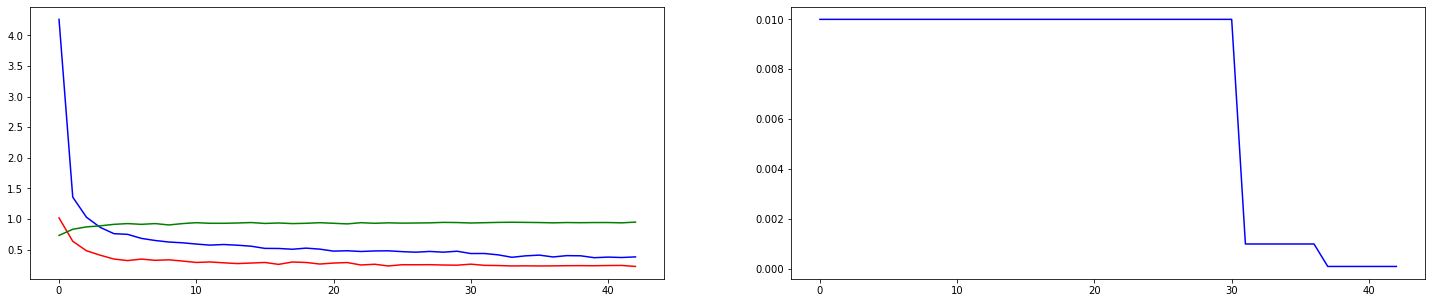

Epoch: 44:                lr: 0.00010000	               Training Loss: 0.386886	               Validation Loss: 0.245966	               Validation accuracy: 94.13%	               Elapsed time: 1178.98


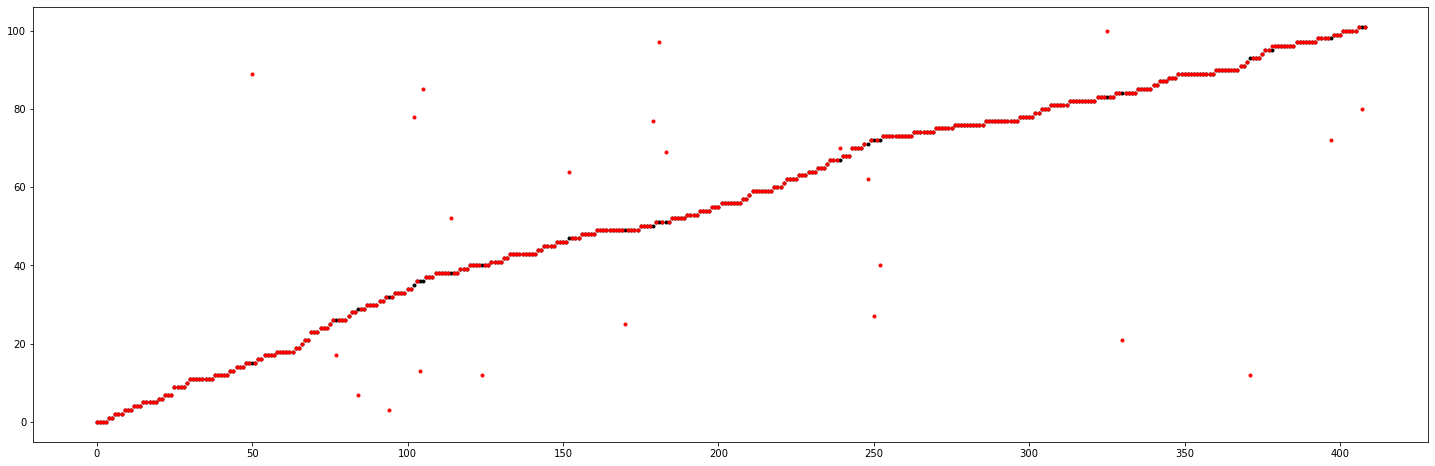

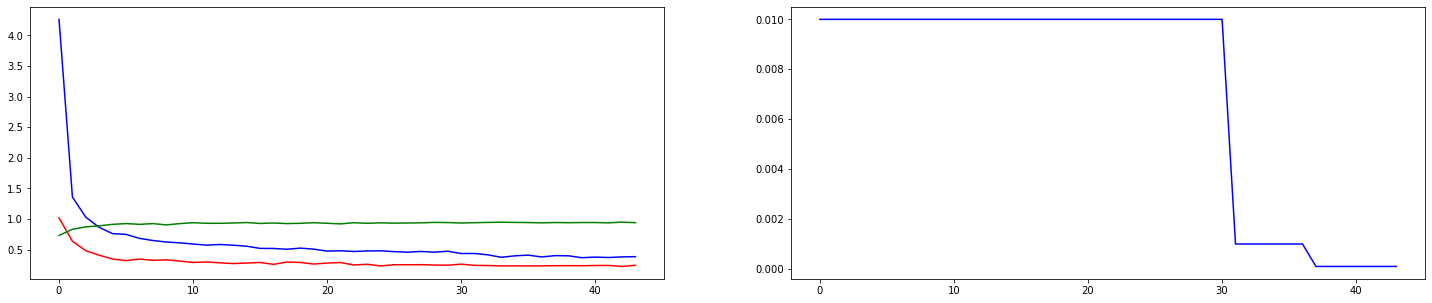

Epoch: 45:                lr: 0.00010000	               Training Loss: 0.370659	               Validation Loss: 0.232904	               Validation accuracy: 94.87%	               Elapsed time: 1204.11


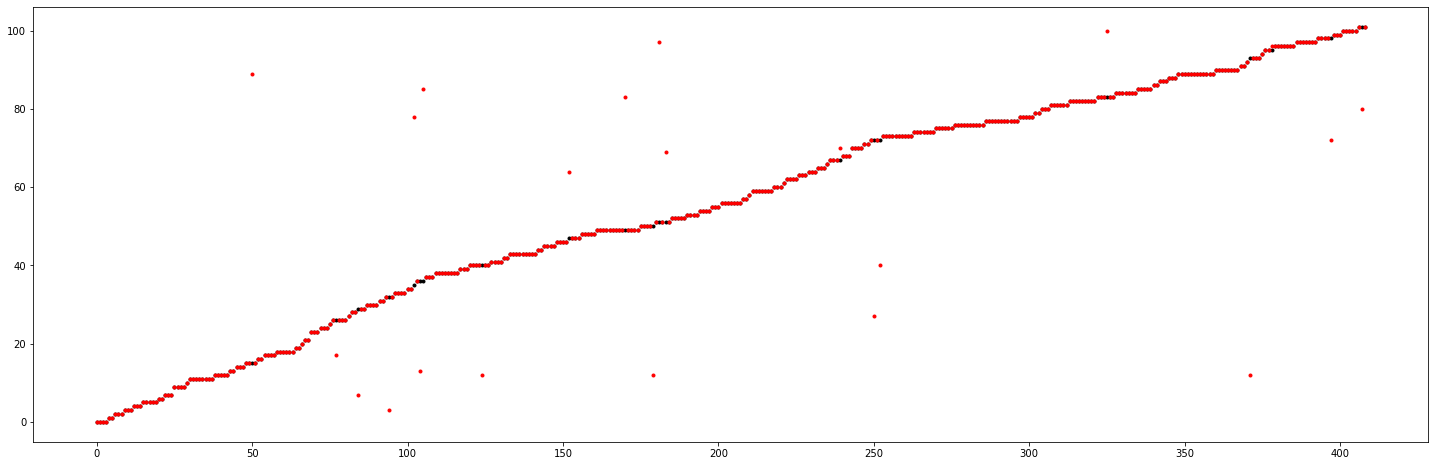

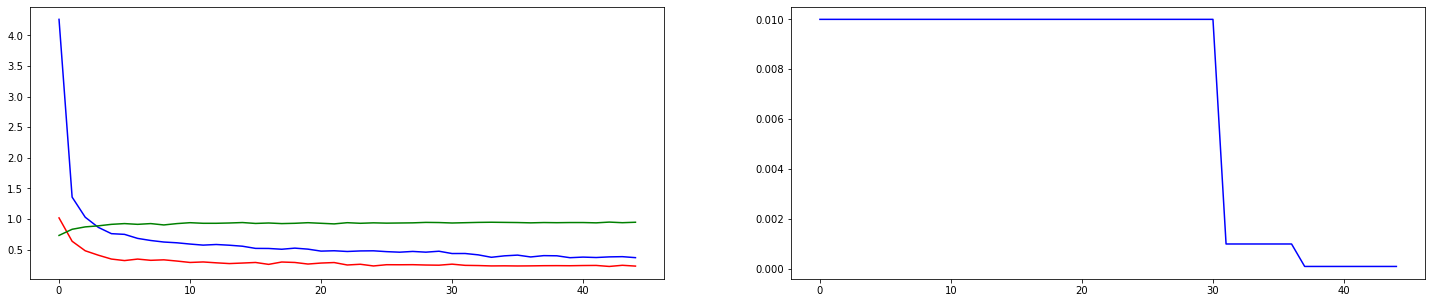

Epoch: 46:                lr: 0.00010000	               Training Loss: 0.386751	               Validation Loss: 0.230984	               Validation accuracy: 94.38%	               Elapsed time: 1226.23


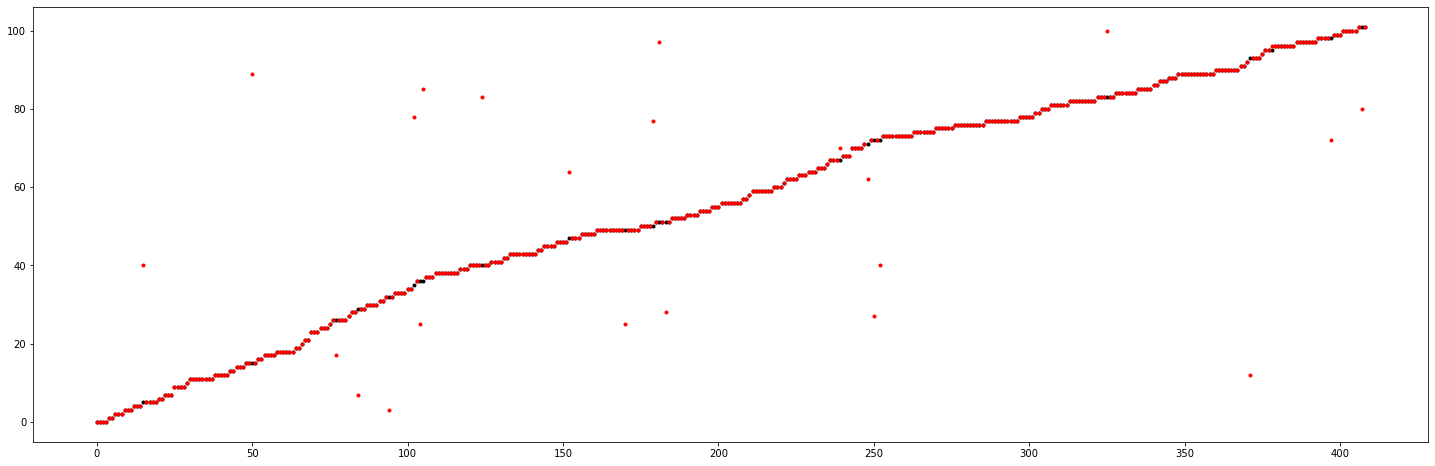

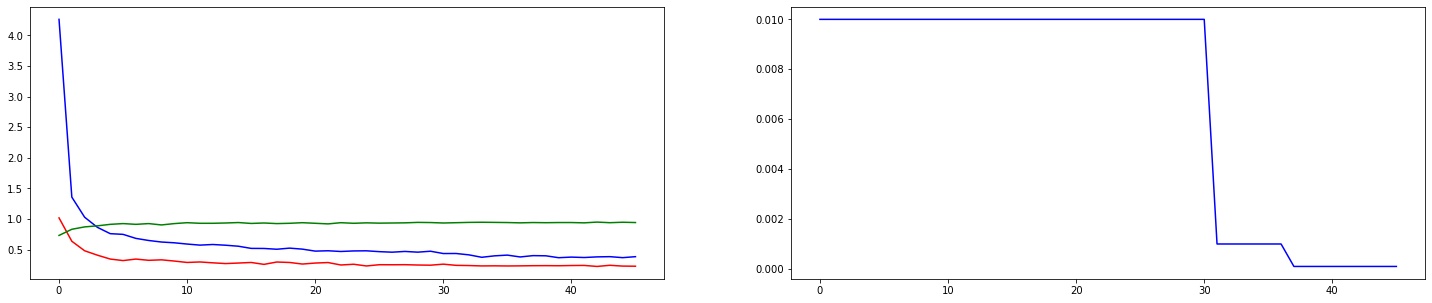

Epoch: 47:                lr: 0.00010000	               Training Loss: 0.379719	               Validation Loss: 0.230145	               Validation accuracy: 94.62%	               Elapsed time: 1247.52


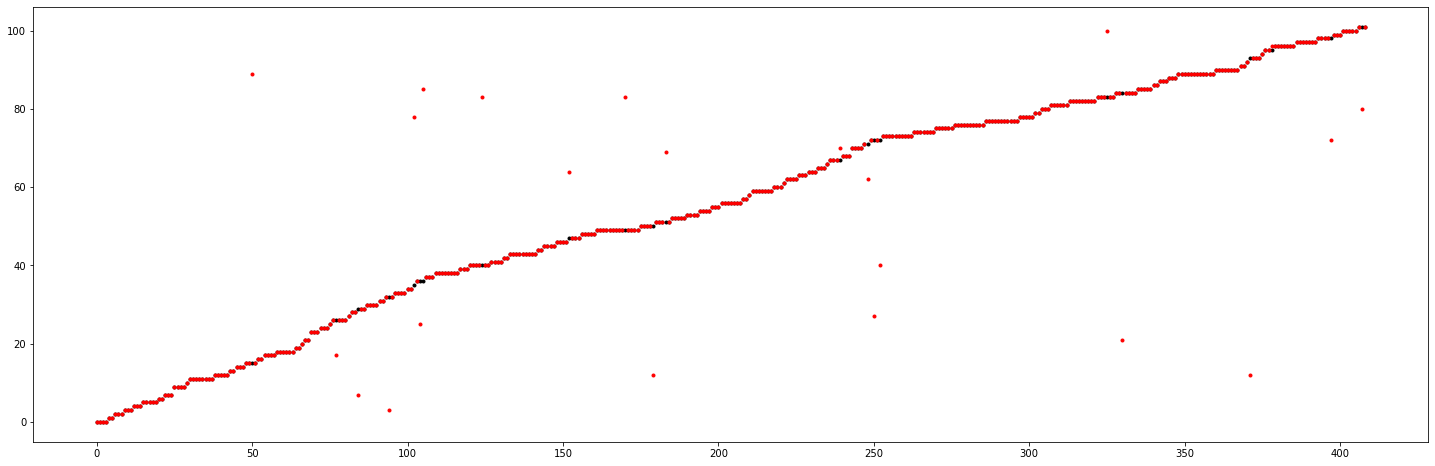

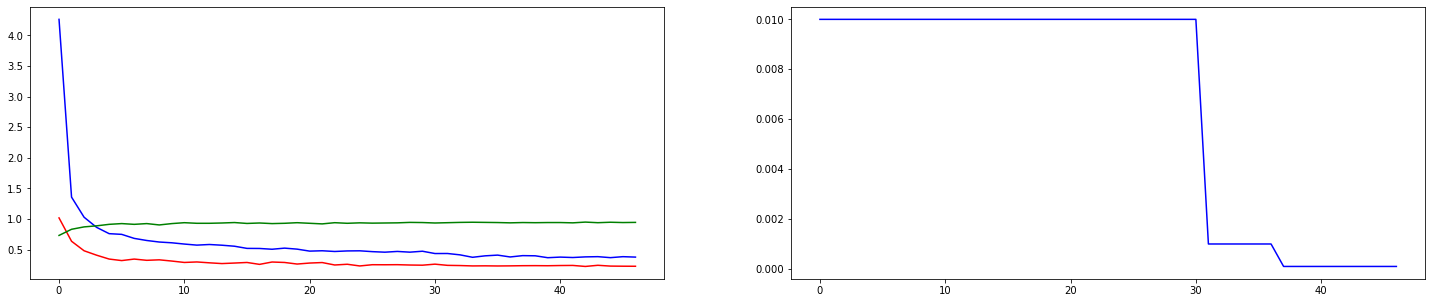

Epoch: 48:                lr: 0.00010000	               Training Loss: 0.371911	               Validation Loss: 0.237141	               Validation accuracy: 94.38%	               Elapsed time: 1271.11


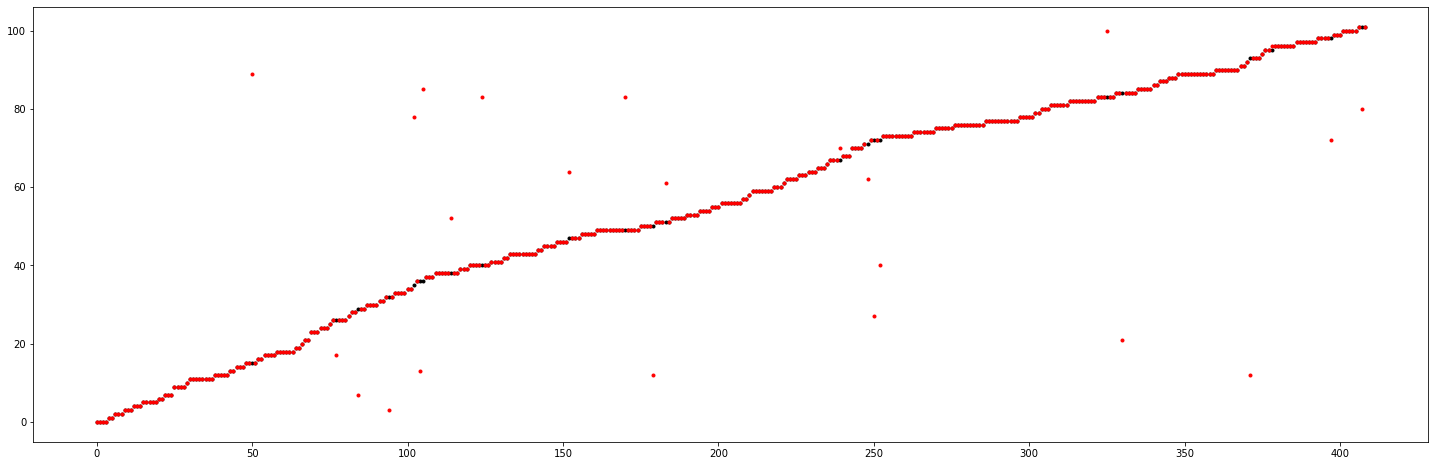

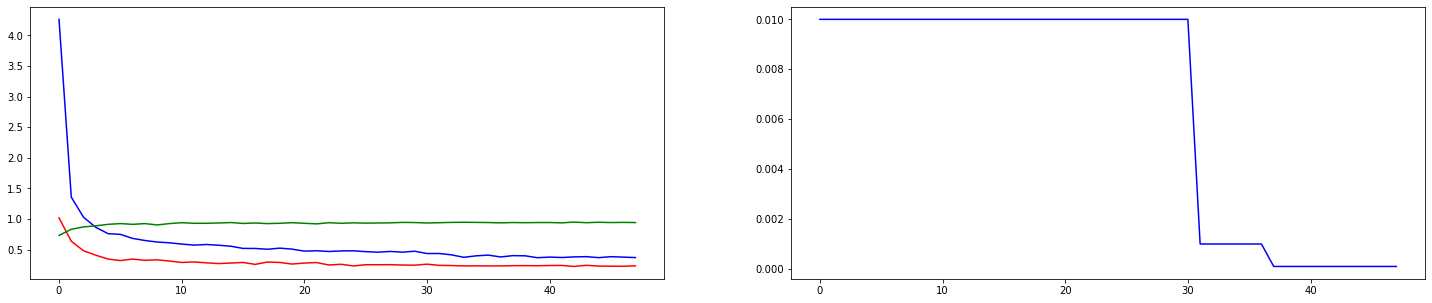

Epoch: 49:                lr: 0.00010000	               Training Loss: 0.390904	               Validation Loss: 0.245531	               Validation accuracy: 93.89%	               Elapsed time: 1295.13


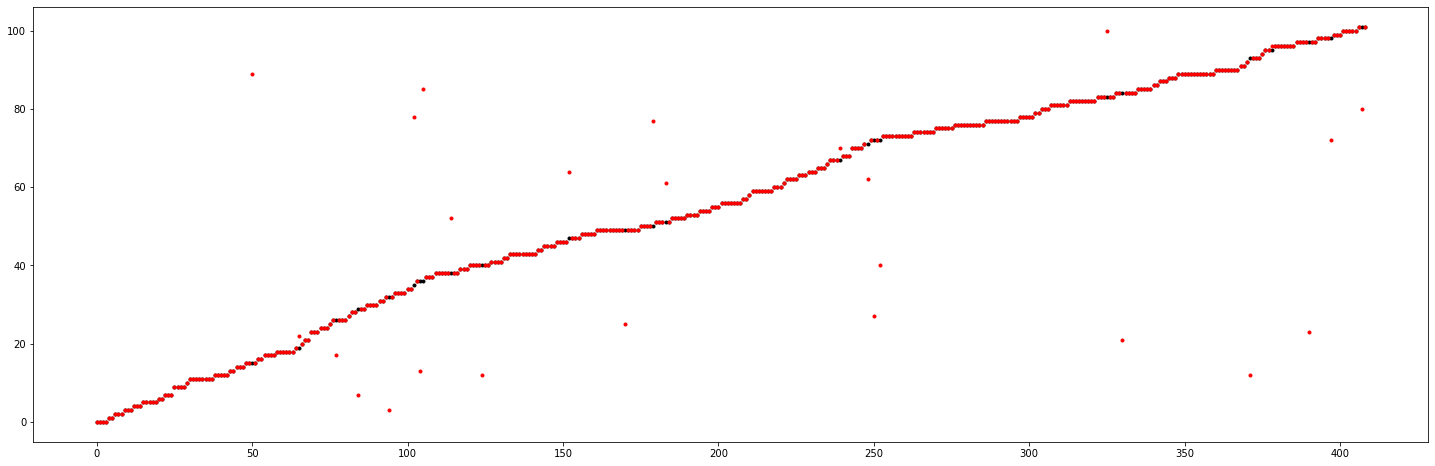

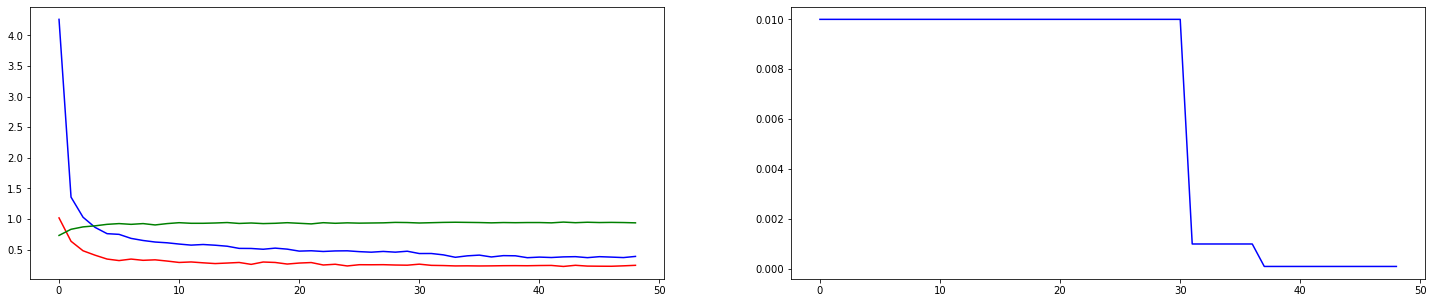

Epoch: 50:                lr: 0.00001000	               Training Loss: 0.395135	               Validation Loss: 0.238743	               Validation accuracy: 94.38%	               Elapsed time: 1319.40


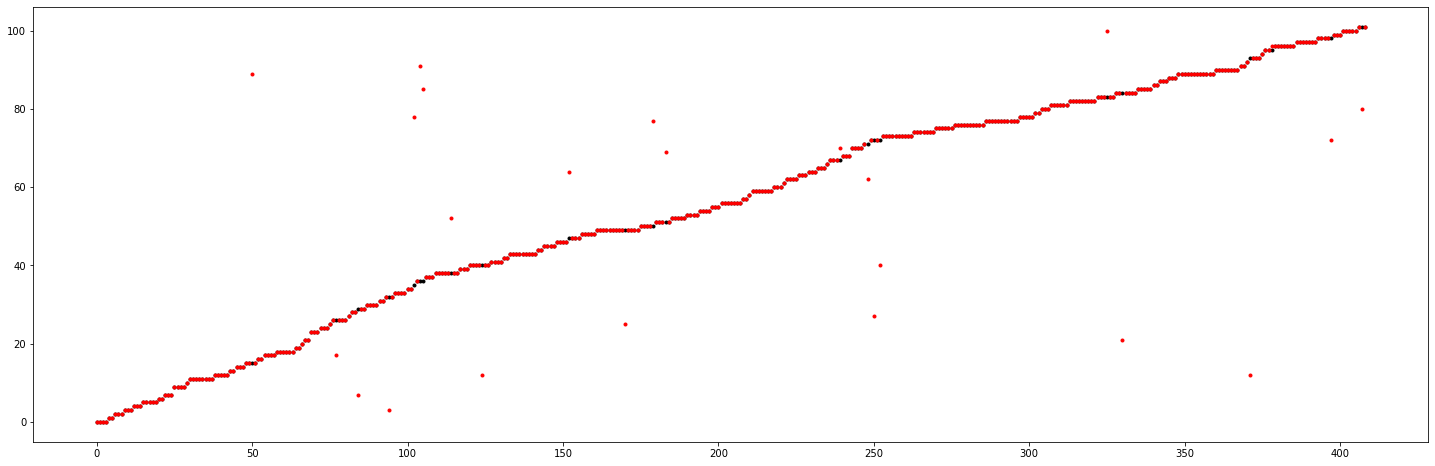

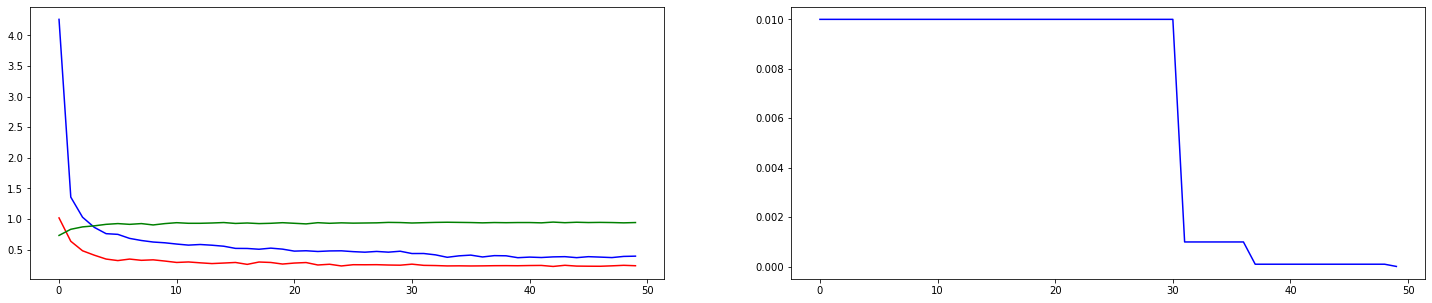

PHASE ONE
Epoch: 1:                lr: 0.01000000	               Training Loss: 4.260430	               Validation Loss: 1.019443	               Validation accuracy: 73.35%	               Elapsed time: 124.77
Epoch: 2:                lr: 0.01000000	               Training Loss: 1.358664	               Validation Loss: 0.638249	               Validation accuracy: 83.37%	               Elapsed time: 151.39
Epoch: 3:                lr: 0.01000000	               Training Loss: 1.030567	               Validation Loss: 0.482966	               Validation accuracy: 87.29%	               Elapsed time: 176.04
Epoch: 4:                lr: 0.01000000	               Training Loss: 0.865001	               Validation Loss: 0.410841	               Validation accuracy: 89.00%	               Elapsed time: 217.54
Epoch: 5:                lr: 0.01000000	               Training Loss: 0.762243	               Validation Loss: 0.347781	               Validation accuracy: 91.44%	               Elapsed time: 24

Epoch: 44:                lr: 0.00010000	               Training Loss: 0.338770	               Validation Loss: 0.193715	               Validation accuracy: 95.60%	               Elapsed time: 1212.41
Validation loss decreased:                   (0.234960 --> 0.193715).   Saving model ...


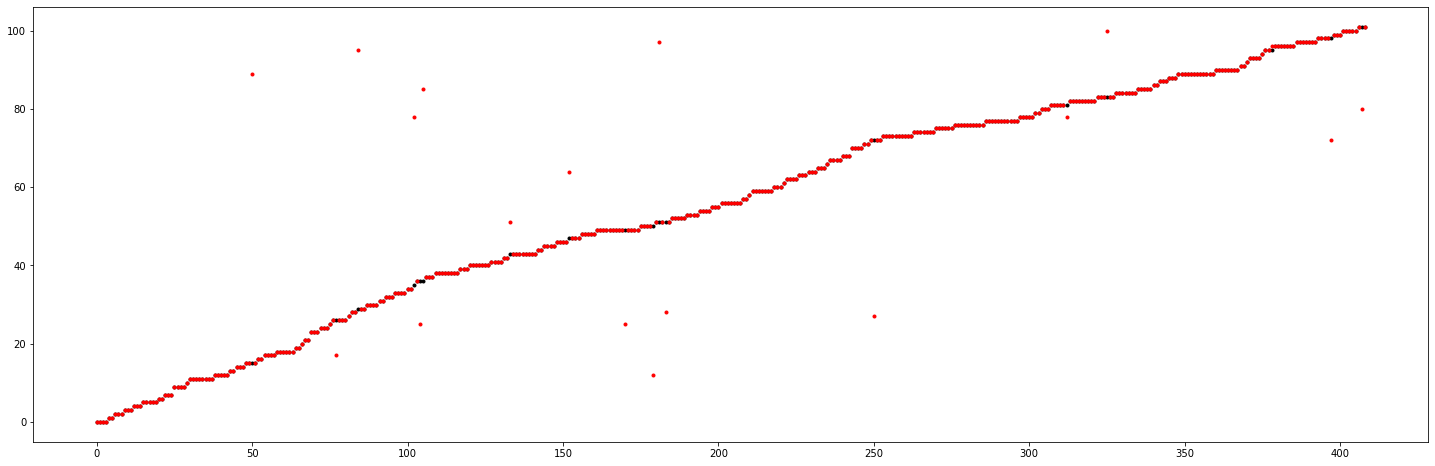

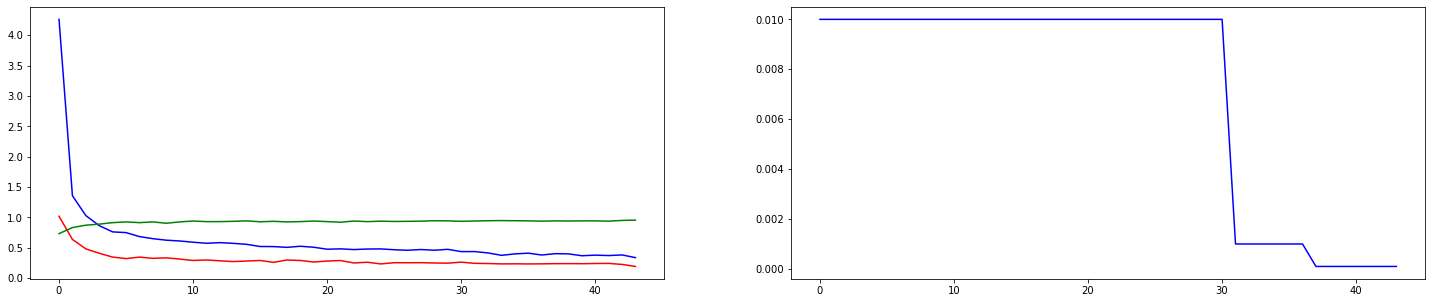

Epoch: 45:                lr: 0.00010000	               Training Loss: 0.321421	               Validation Loss: 0.190917	               Validation accuracy: 96.09%	               Elapsed time: 1264.79
Validation loss decreased:                   (0.193715 --> 0.190917).   Saving model ...


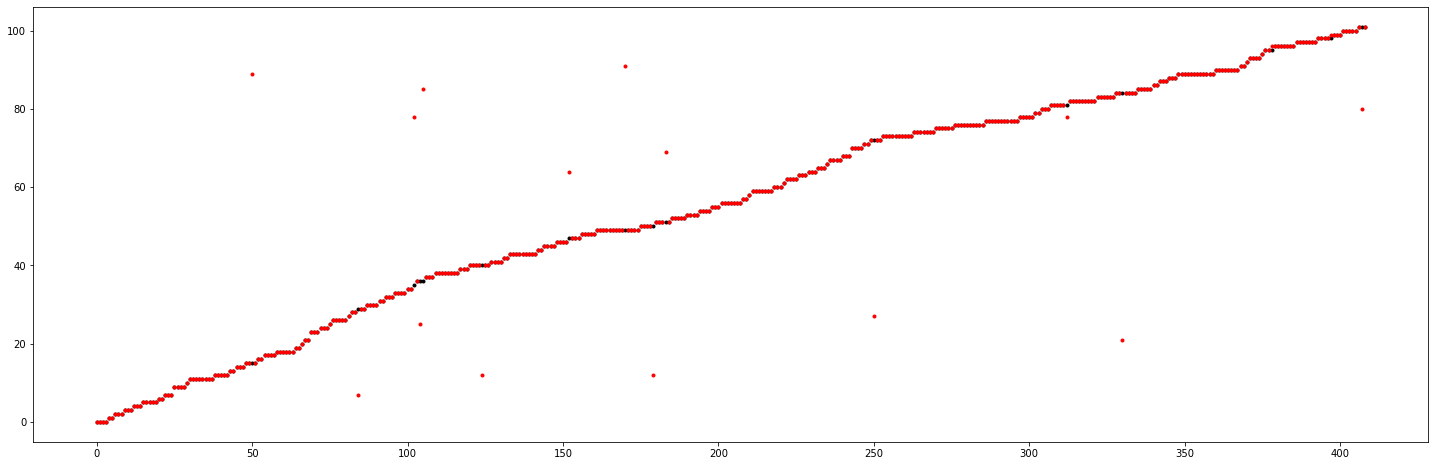

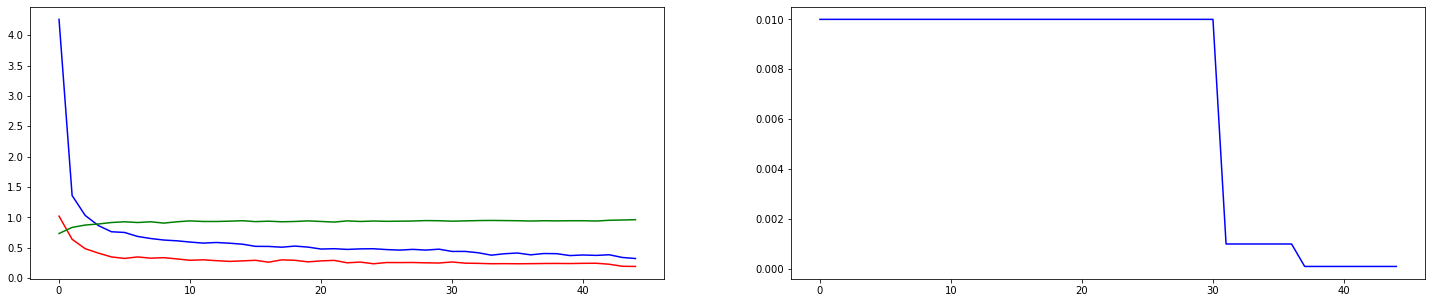

Epoch: 46:                lr: 0.00010000	               Training Loss: 0.257842	               Validation Loss: 0.181063	               Validation accuracy: 96.09%	               Elapsed time: 1316.18
Validation loss decreased:                   (0.190917 --> 0.181063).   Saving model ...


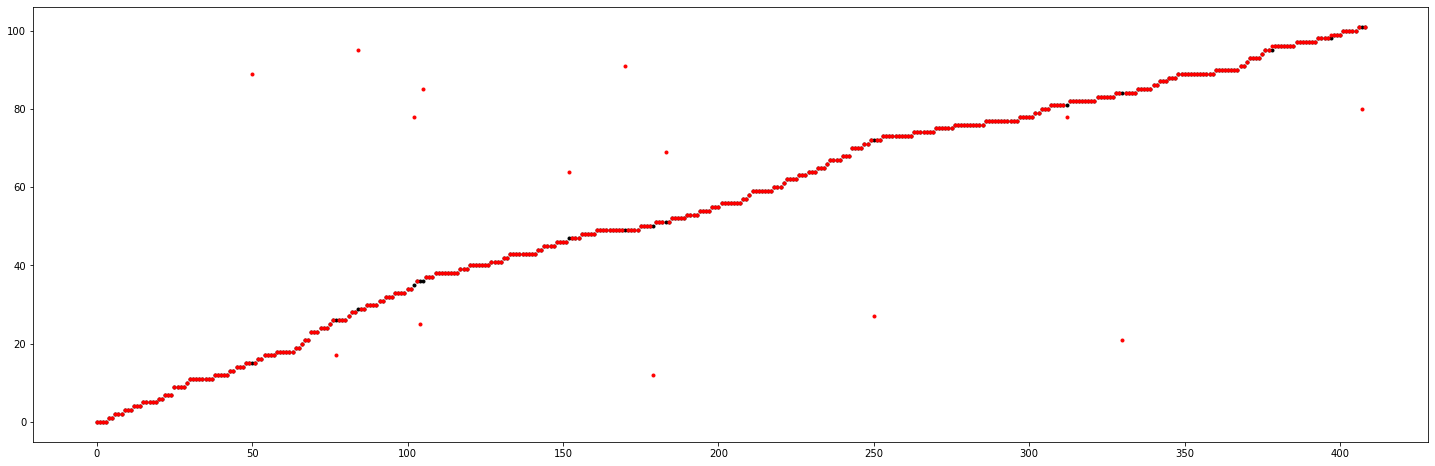

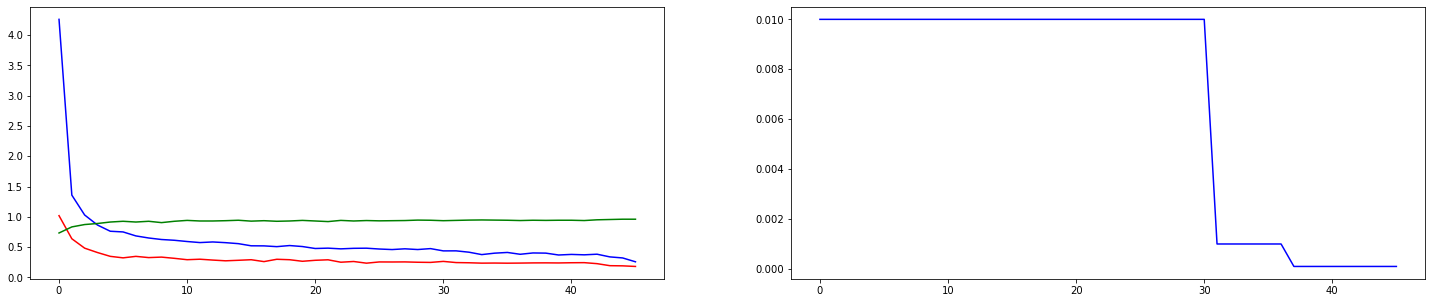

Epoch: 47:                lr: 0.00010000	               Training Loss: 0.265832	               Validation Loss: 0.184594	               Validation accuracy: 96.09%	               Elapsed time: 1367.24


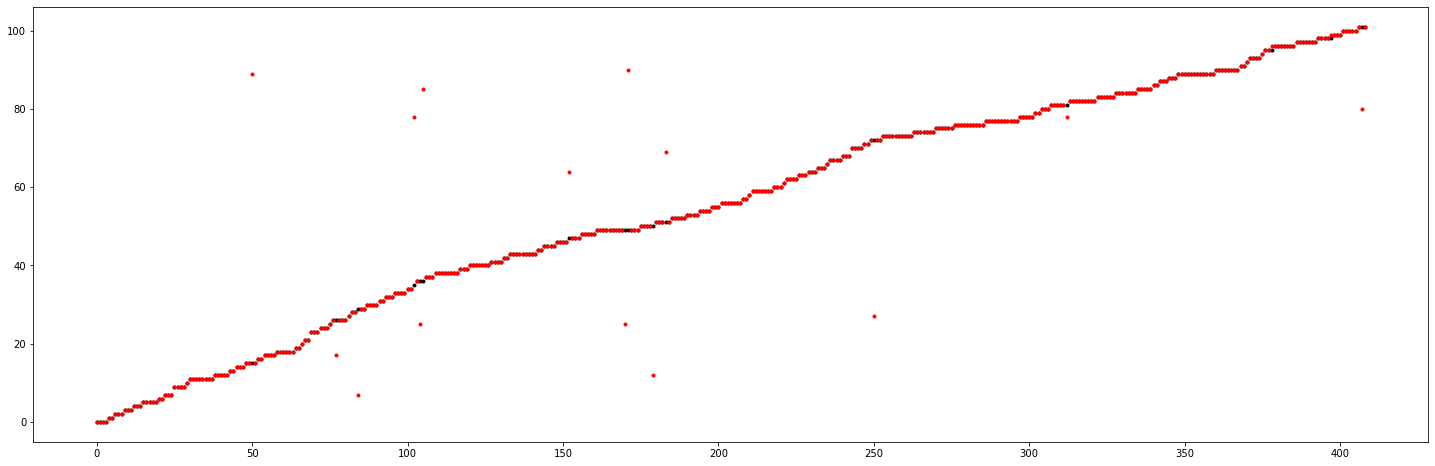

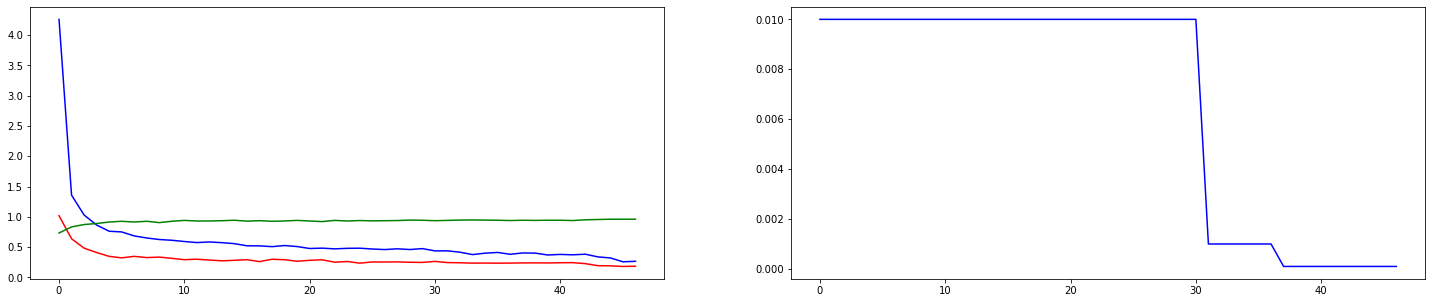

Epoch: 48:                lr: 0.00010000	               Training Loss: 0.256243	               Validation Loss: 0.175522	               Validation accuracy: 96.33%	               Elapsed time: 1418.79
Validation loss decreased:                   (0.181063 --> 0.175522).   Saving model ...


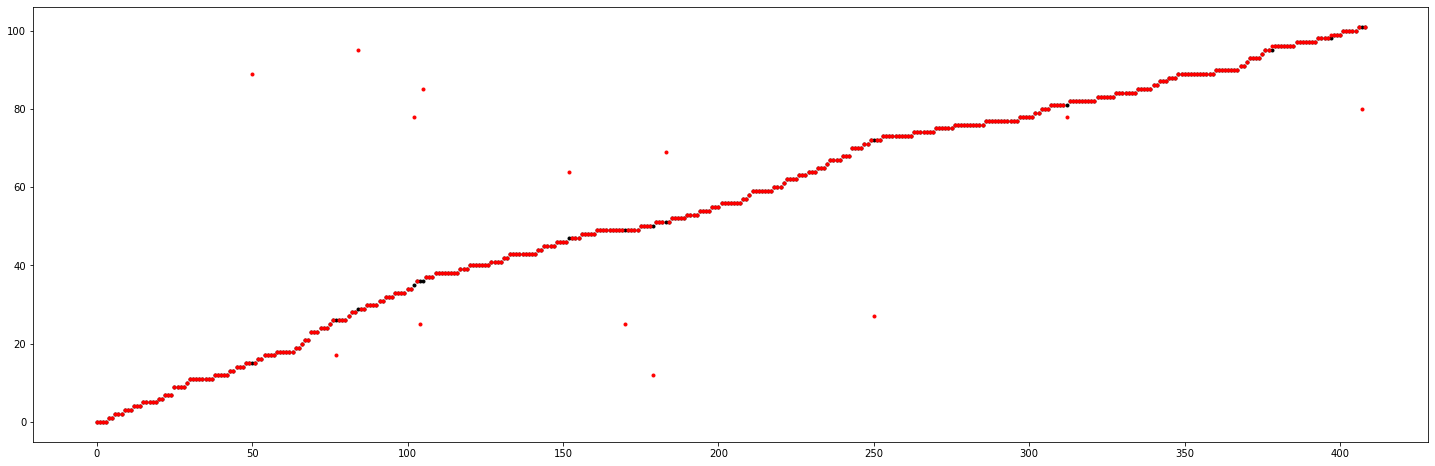

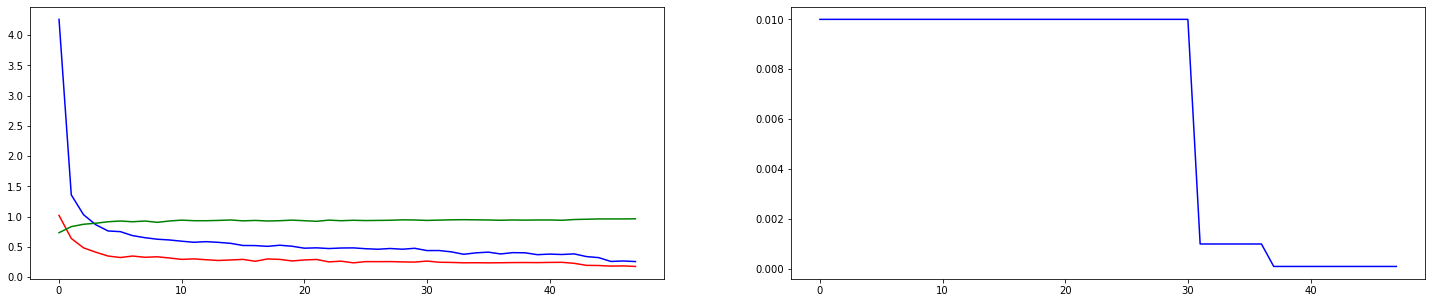

Epoch: 49:                lr: 0.00010000	               Training Loss: 0.260748	               Validation Loss: 0.173334	               Validation accuracy: 96.33%	               Elapsed time: 1465.20
Validation loss decreased:                   (0.175522 --> 0.173334).   Saving model ...


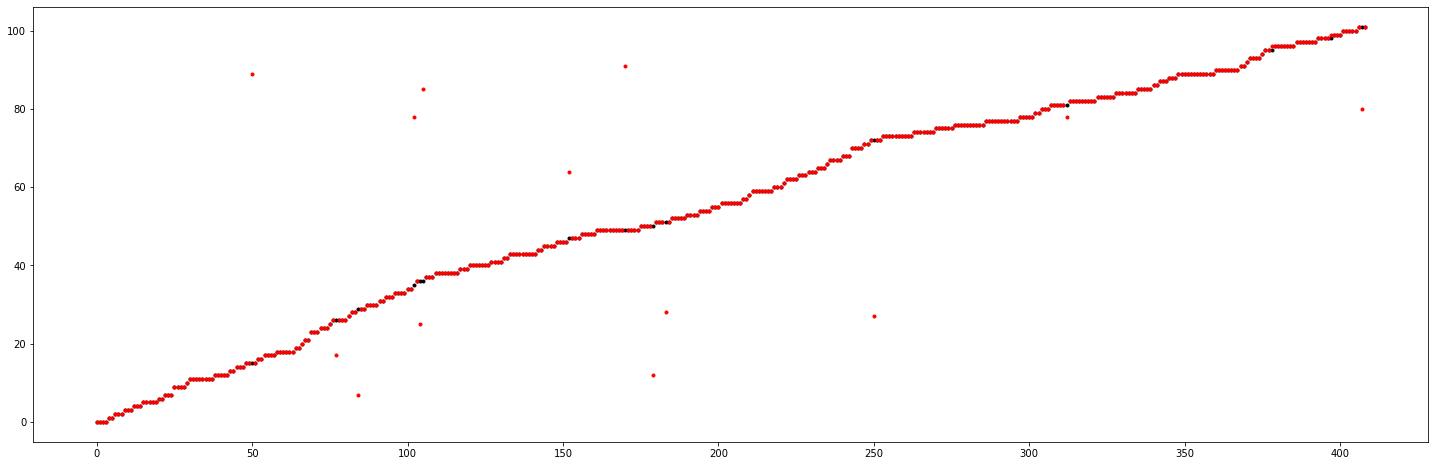

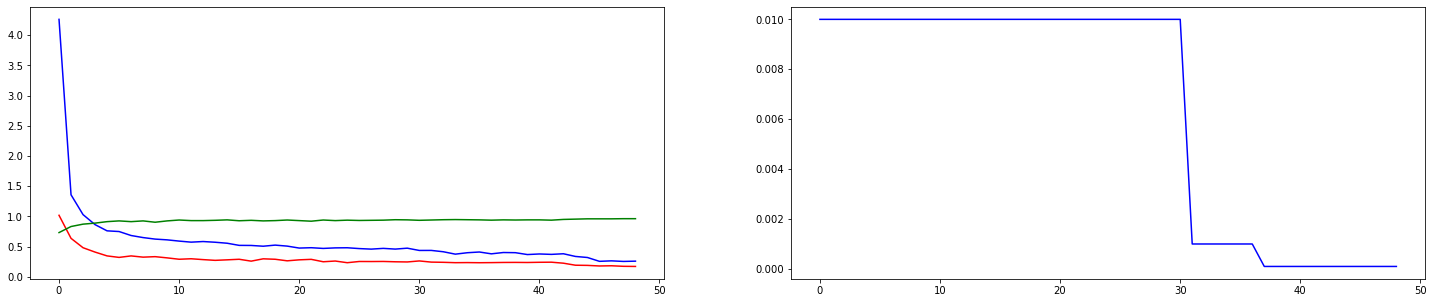

Epoch: 50:                lr: 0.00010000	               Training Loss: 0.239045	               Validation Loss: 0.163806	               Validation accuracy: 96.82%	               Elapsed time: 1512.17
Validation loss decreased:                   (0.173334 --> 0.163806).   Saving model ...


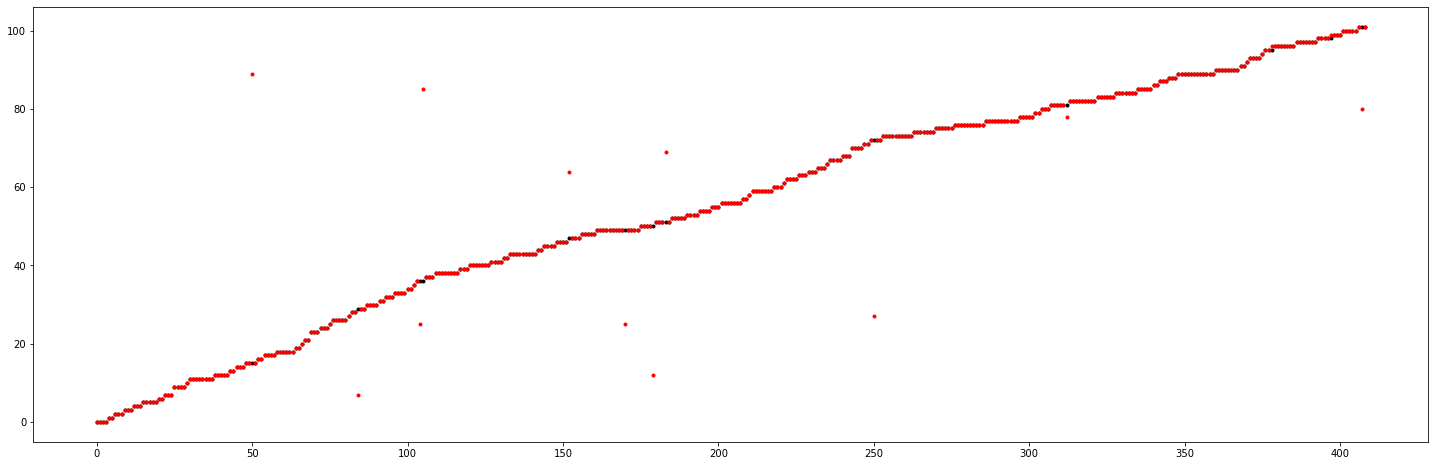

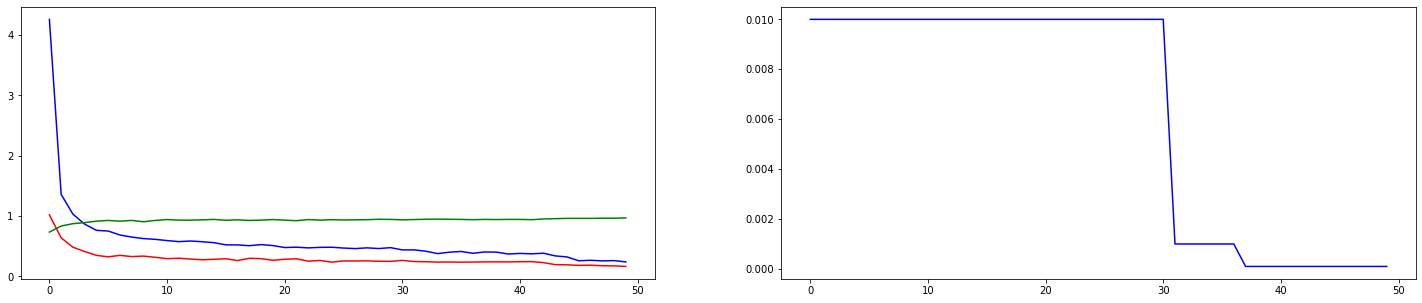

Epoch: 51:                lr: 0.00010000	               Training Loss: 0.232028	               Validation Loss: 0.164495	               Validation accuracy: 96.58%	               Elapsed time: 1558.63


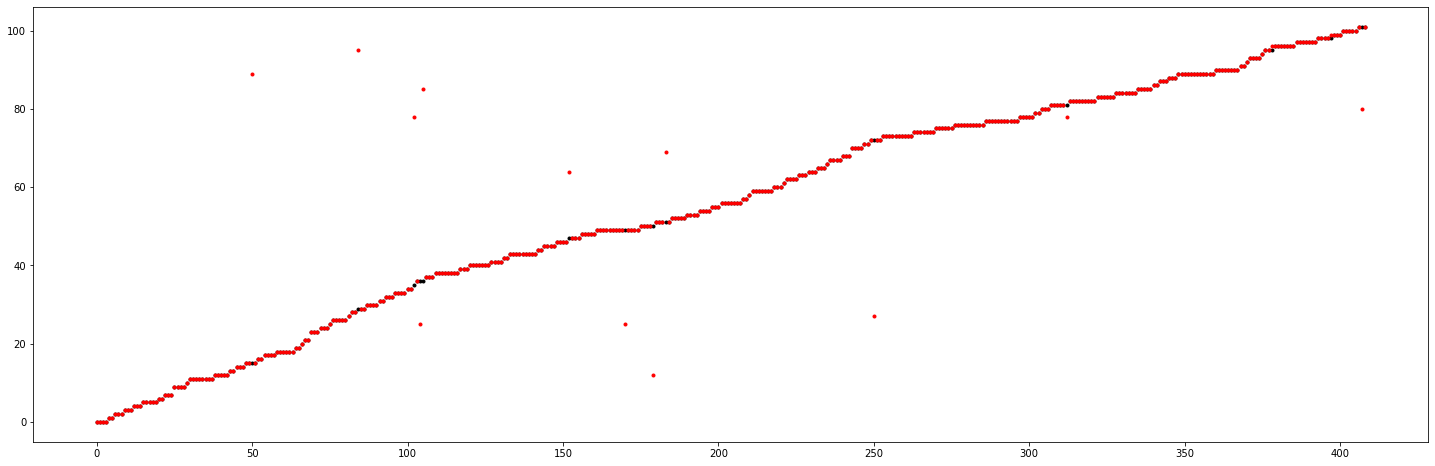

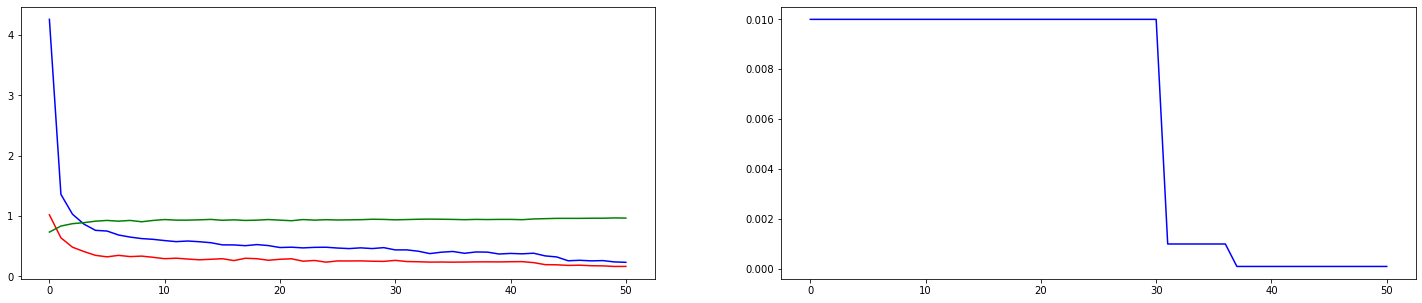

Epoch: 52:                lr: 0.00010000	               Training Loss: 0.224767	               Validation Loss: 0.166844	               Validation accuracy: 96.82%	               Elapsed time: 1606.35


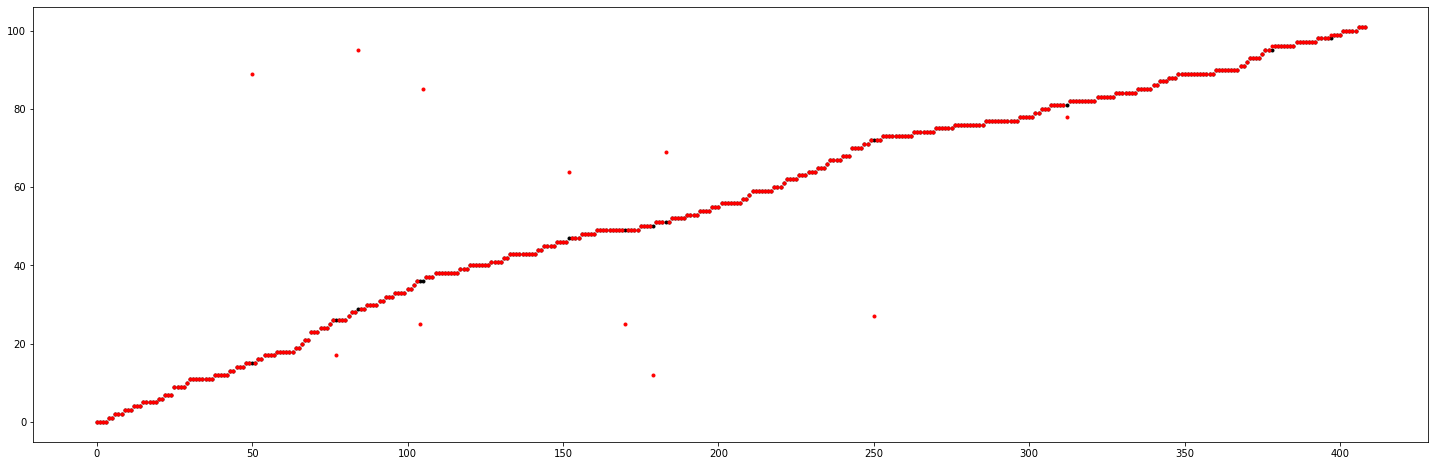

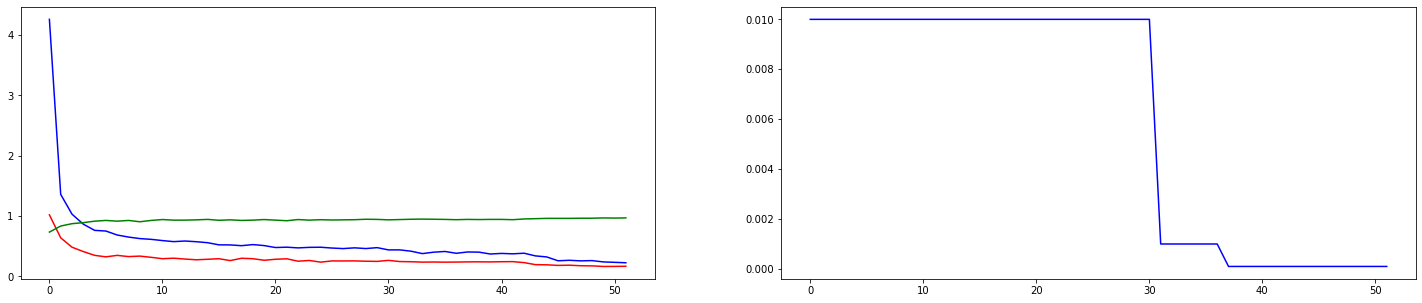

Epoch: 53:                lr: 0.00010000	               Training Loss: 0.211670	               Validation Loss: 0.155171	               Validation accuracy: 96.82%	               Elapsed time: 1657.08
Validation loss decreased:                   (0.163806 --> 0.155171).   Saving model ...


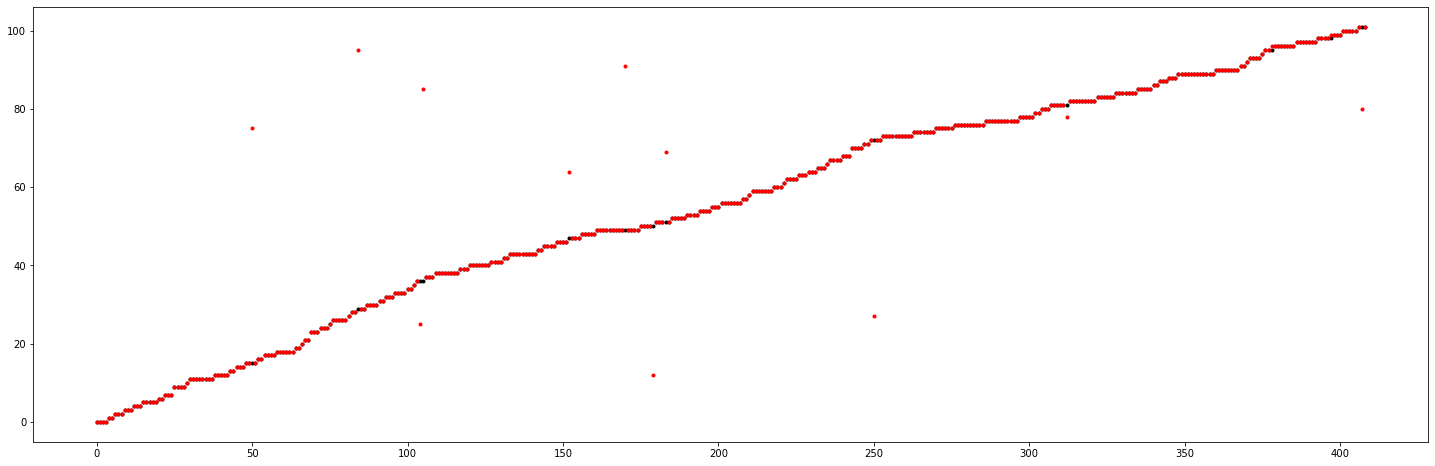

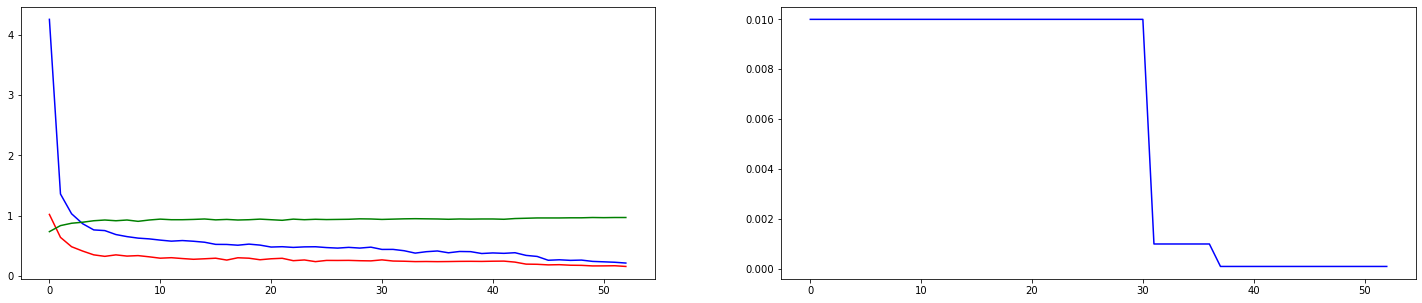

Epoch: 54:                lr: 0.00010000	               Training Loss: 0.205632	               Validation Loss: 0.161209	               Validation accuracy: 96.58%	               Elapsed time: 1706.13


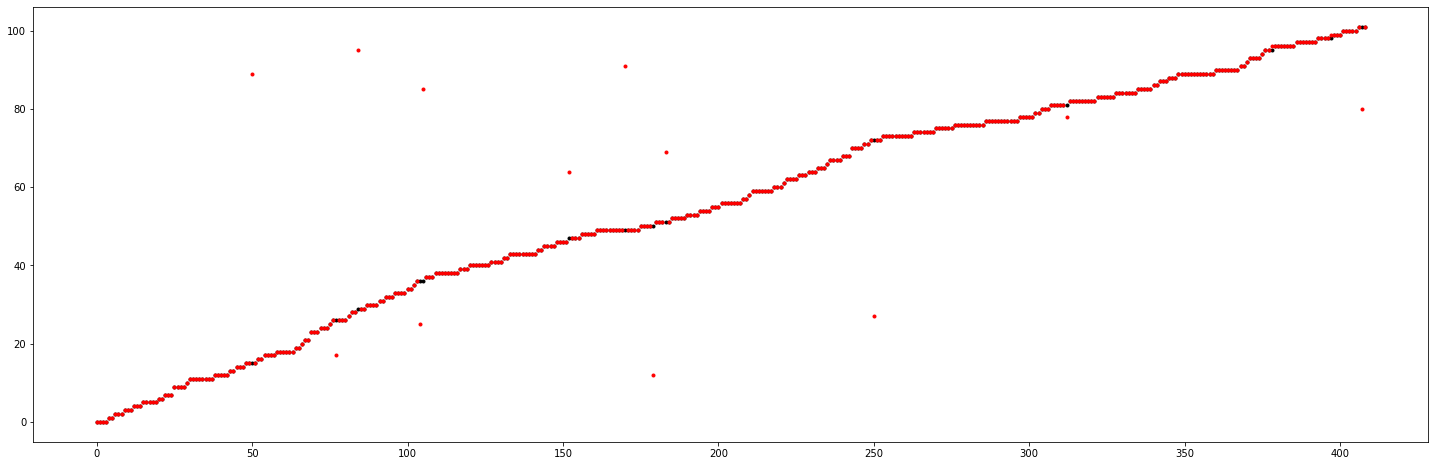

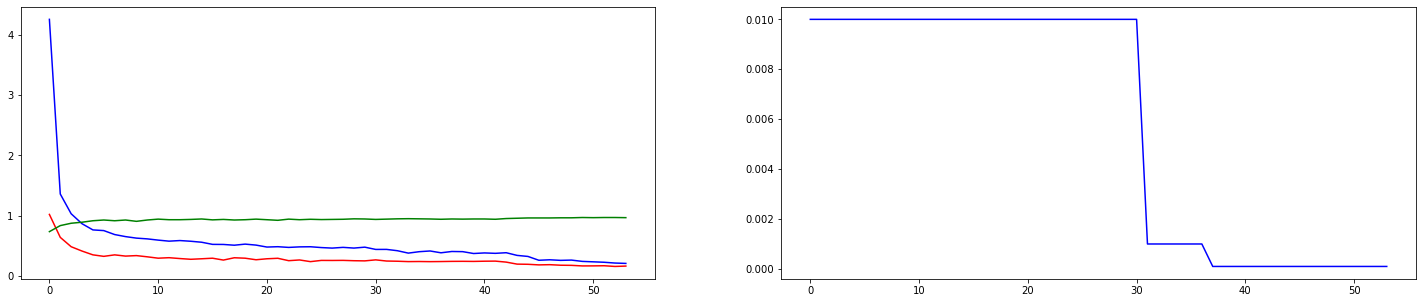

Epoch: 55:                lr: 0.00010000	               Training Loss: 0.210803	               Validation Loss: 0.162529	               Validation accuracy: 96.09%	               Elapsed time: 1755.13


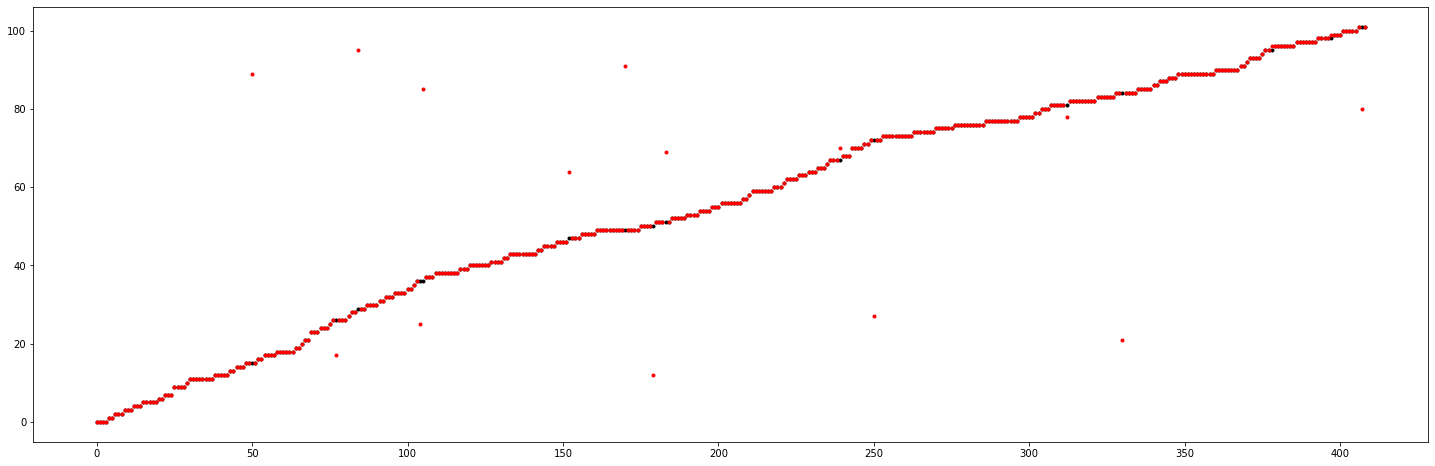

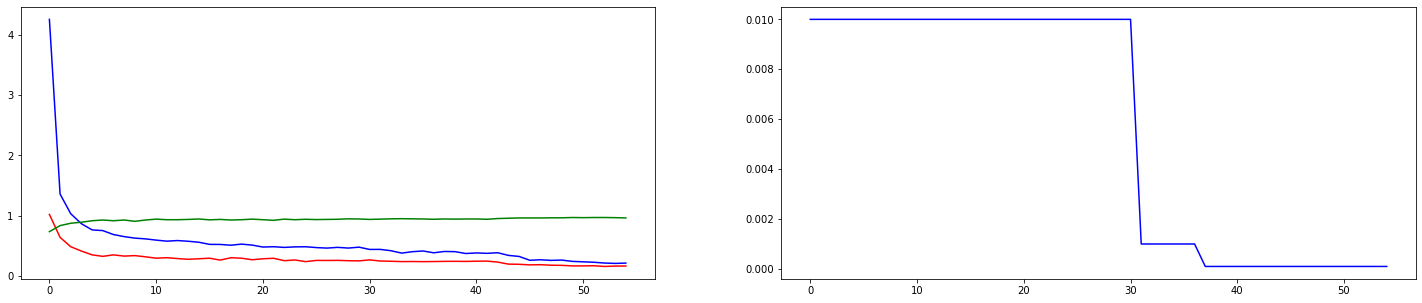

Epoch: 56:                lr: 0.00010000	               Training Loss: 0.196338	               Validation Loss: 0.152665	               Validation accuracy: 96.82%	               Elapsed time: 1804.44
Validation loss decreased:                   (0.155171 --> 0.152665).   Saving model ...


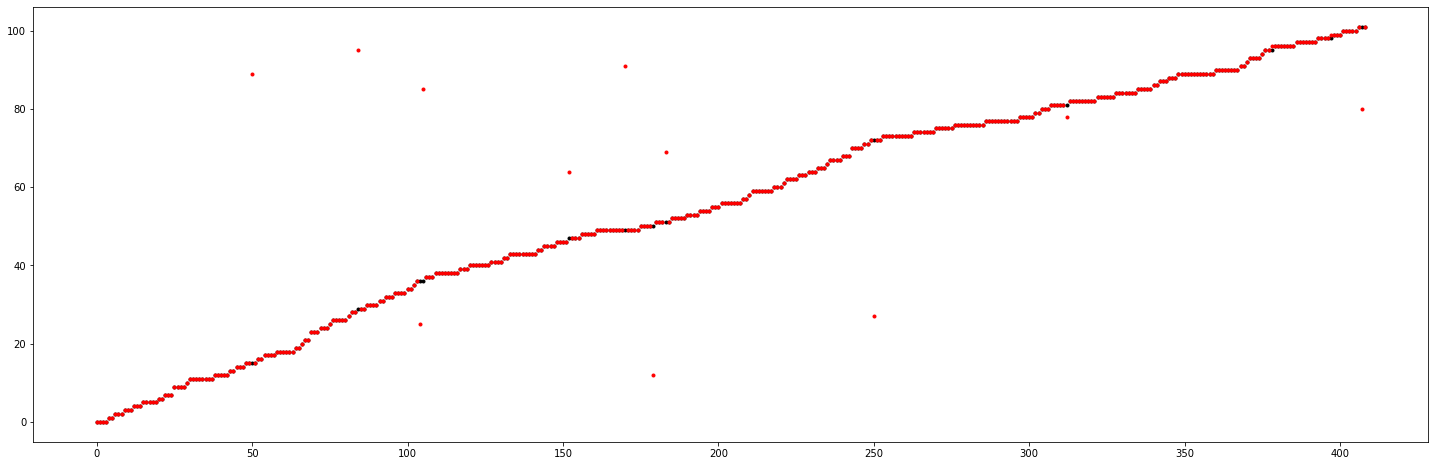

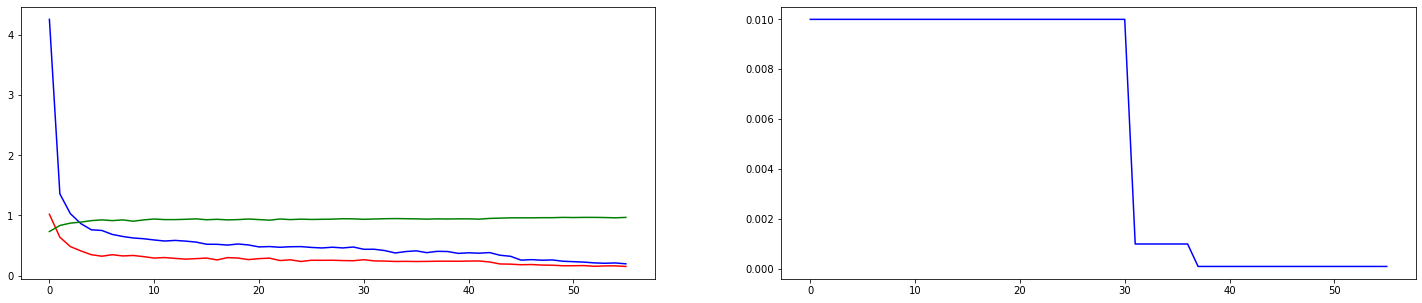

Epoch: 57:                lr: 0.00010000	               Training Loss: 0.216859	               Validation Loss: 0.158616	               Validation accuracy: 96.58%	               Elapsed time: 1853.29


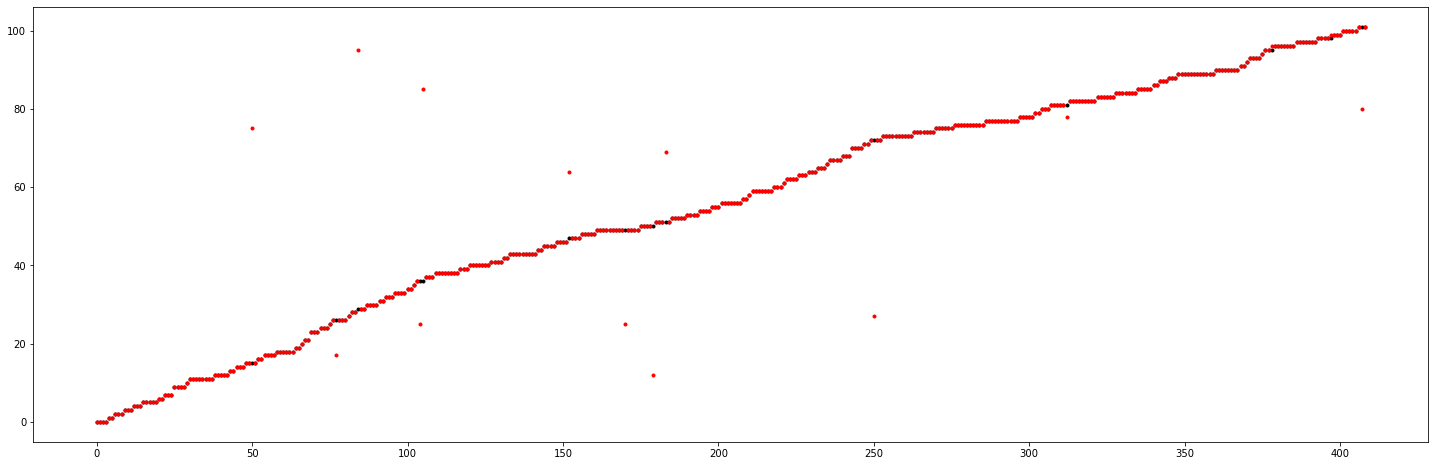

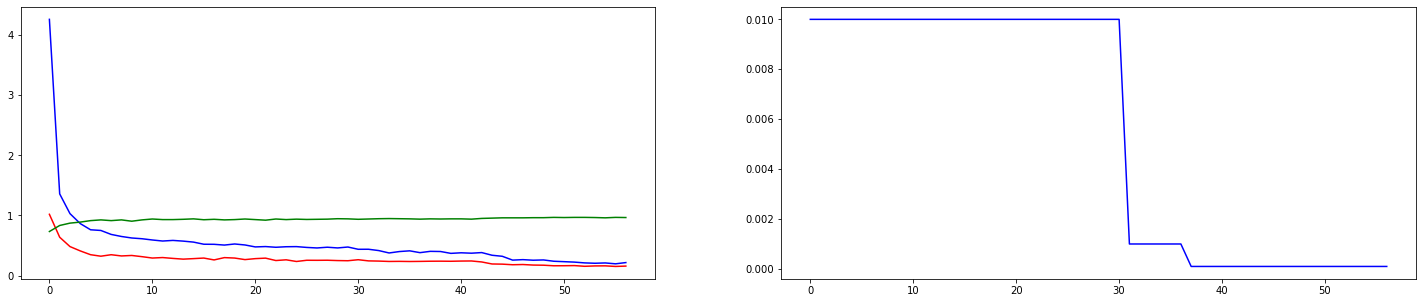

Epoch: 58:                lr: 0.00010000	               Training Loss: 0.194593	               Validation Loss: 0.153605	               Validation accuracy: 96.58%	               Elapsed time: 1899.01


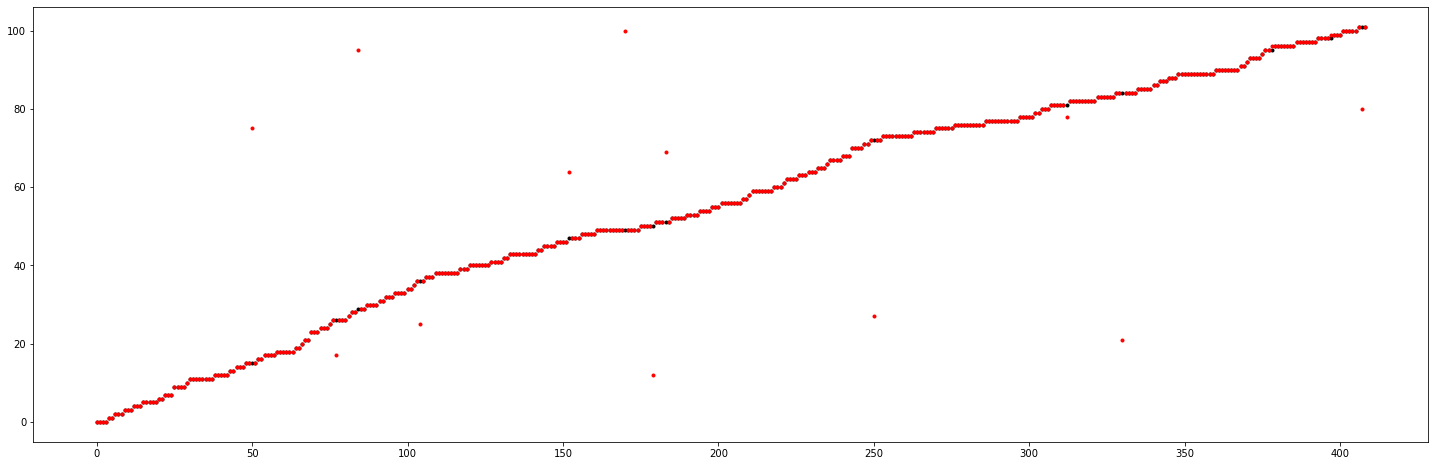

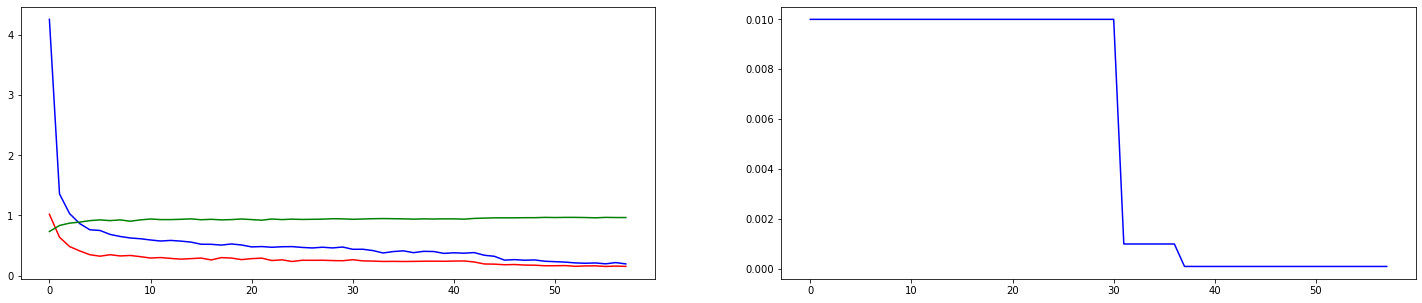

Epoch: 59:                lr: 0.00010000	               Training Loss: 0.188077	               Validation Loss: 0.147638	               Validation accuracy: 96.82%	               Elapsed time: 1944.94
Validation loss decreased:                   (0.152665 --> 0.147638).   Saving model ...


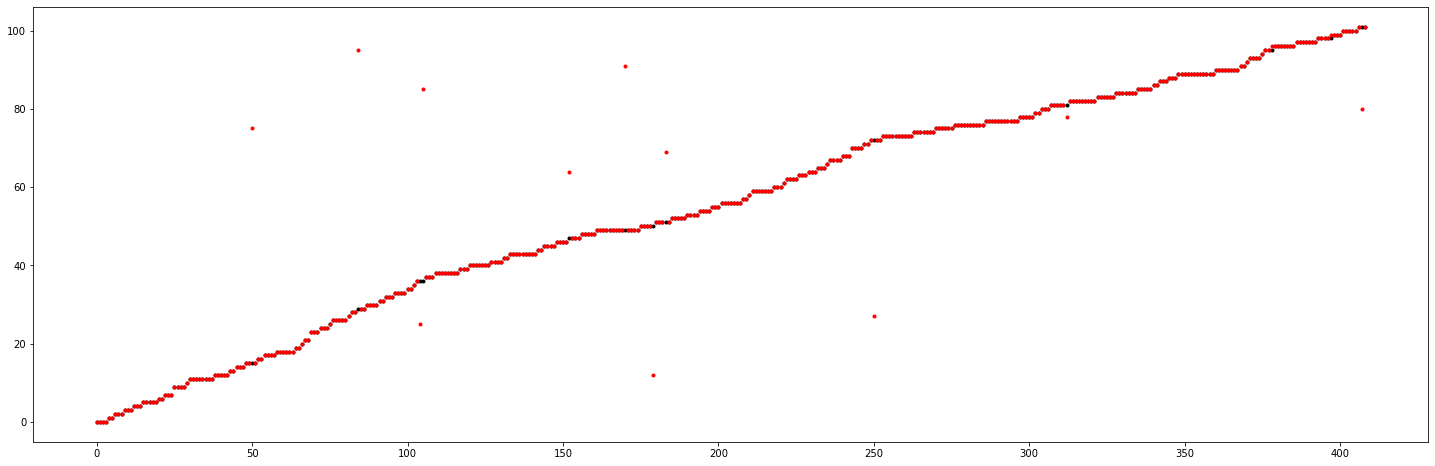

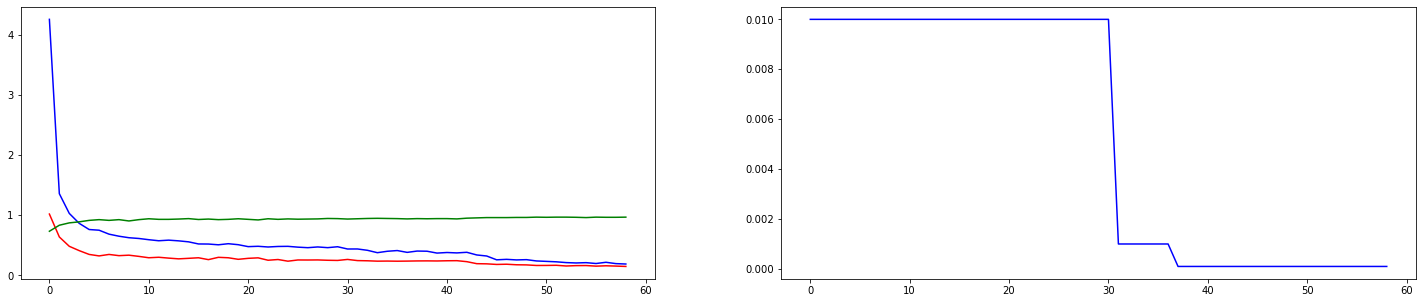

Epoch: 60:                lr: 0.00010000	               Training Loss: 0.192541	               Validation Loss: 0.151224	               Validation accuracy: 97.07%	               Elapsed time: 1992.35


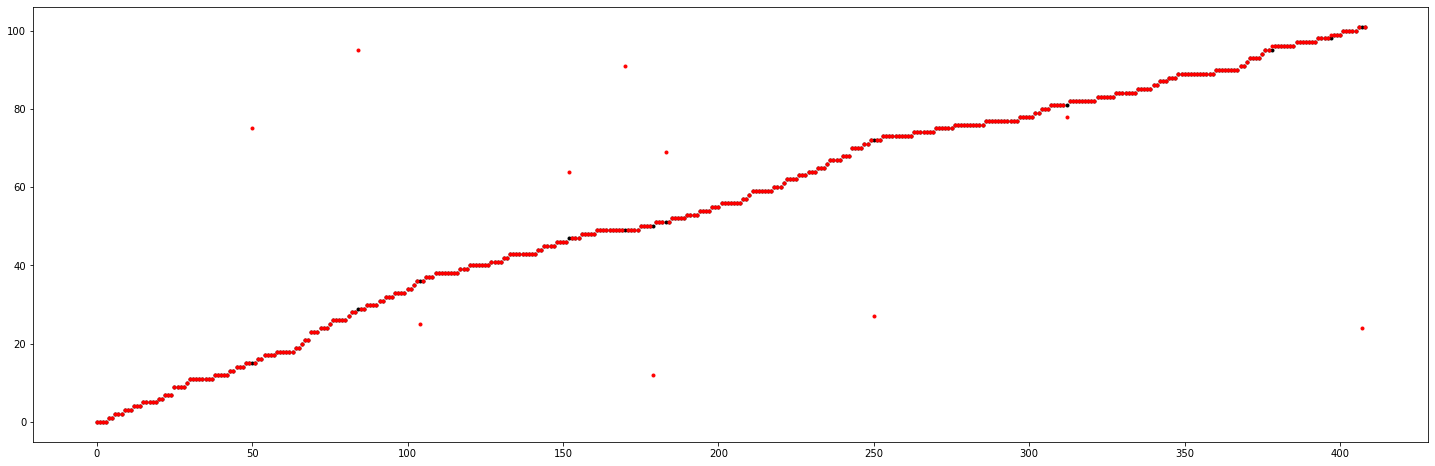

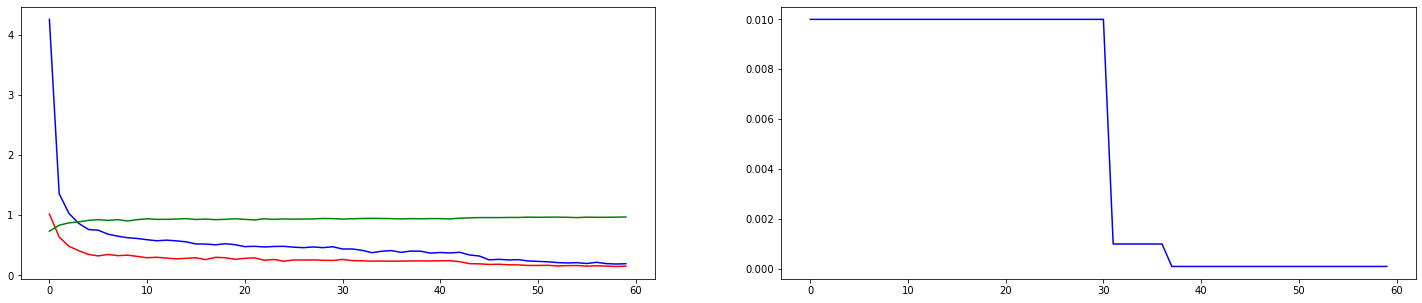

Epoch: 61:                lr: 0.00010000	               Training Loss: 0.203831	               Validation Loss: 0.148678	               Validation accuracy: 96.82%	               Elapsed time: 2042.13


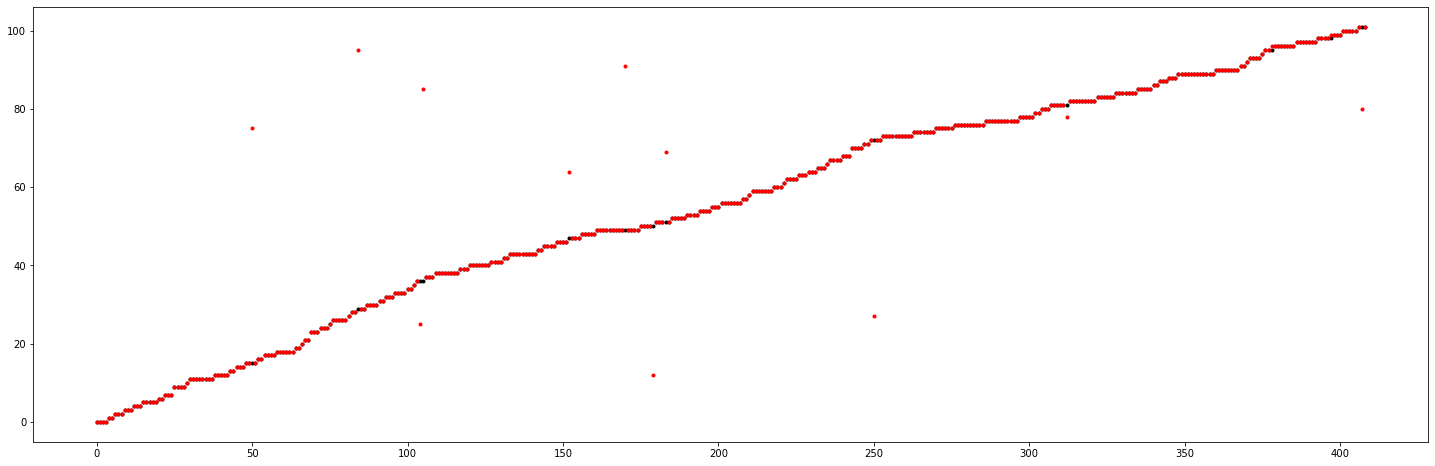

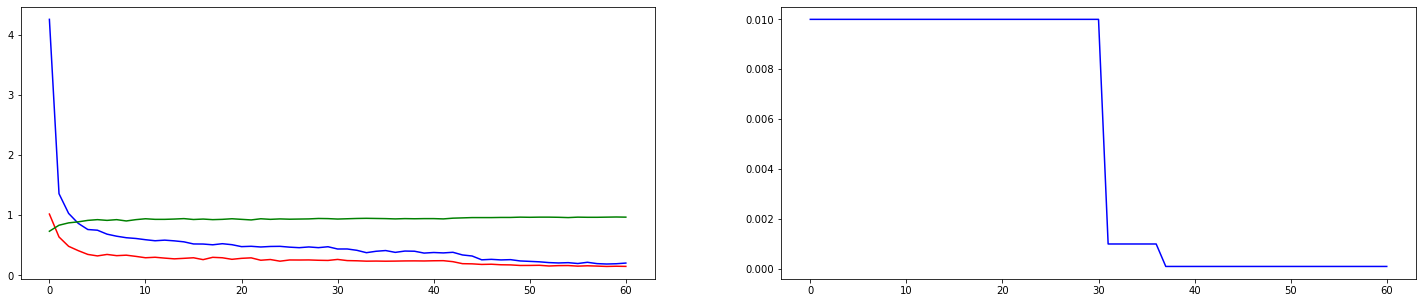

Epoch: 62:                lr: 0.00010000	               Training Loss: 0.193430	               Validation Loss: 0.153942	               Validation accuracy: 96.58%	               Elapsed time: 2091.33


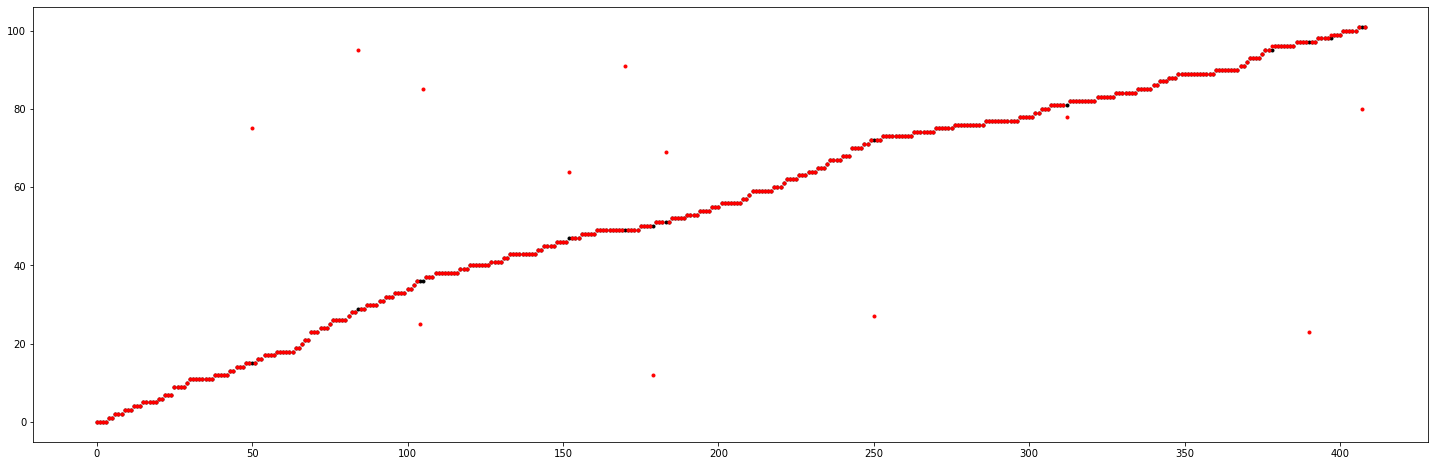

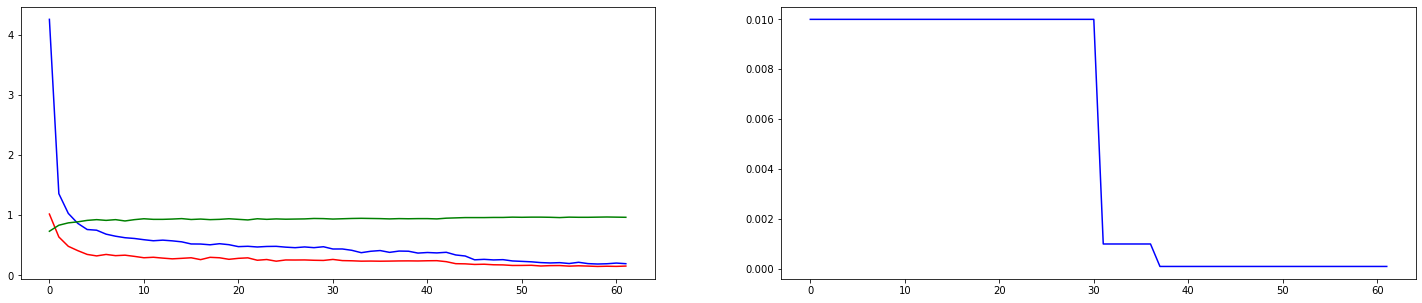

Epoch: 63:                lr: 0.00010000	               Training Loss: 0.194070	               Validation Loss: 0.147344	               Validation accuracy: 96.82%	               Elapsed time: 2141.87
Validation loss decreased:                   (0.147638 --> 0.147344).   Saving model ...


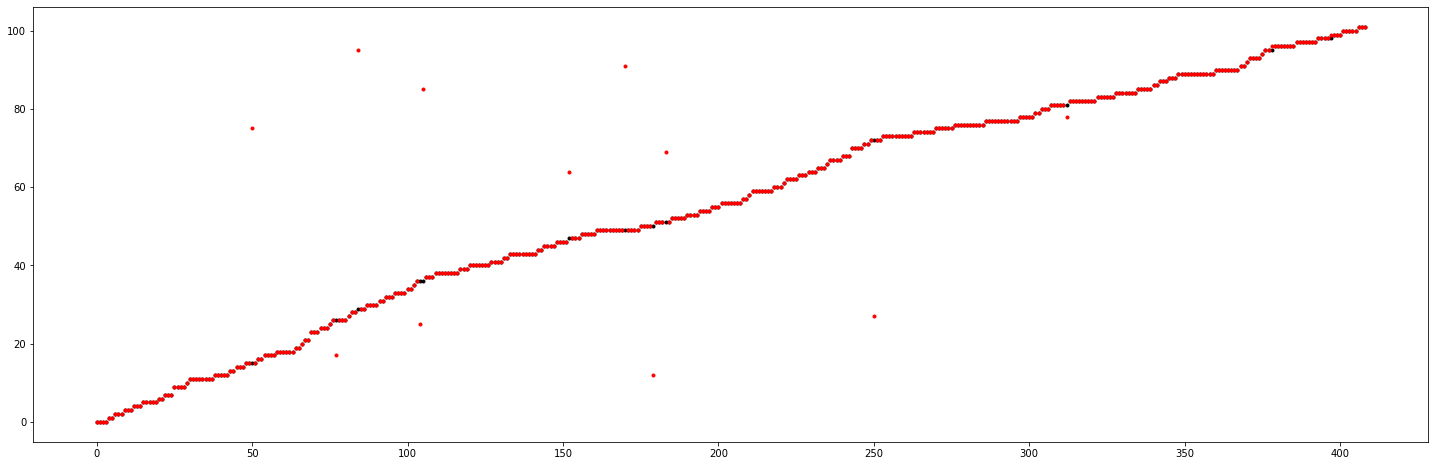

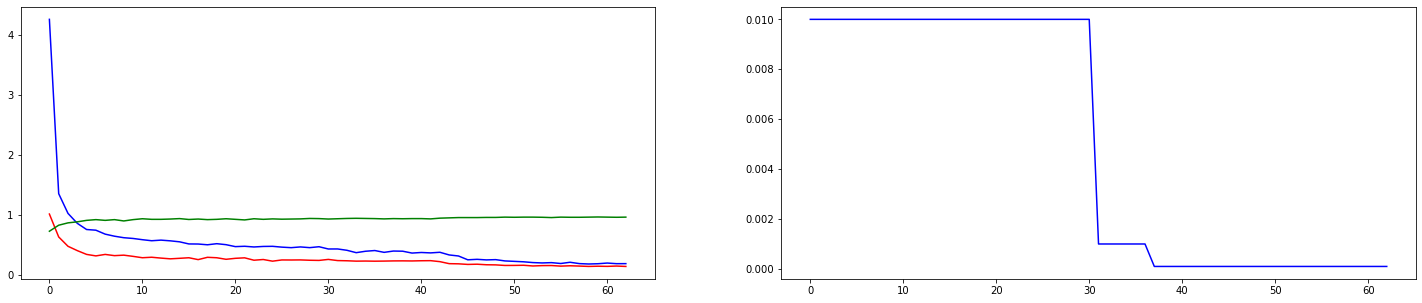

PHASE ONE
Epoch: 1:                lr: 0.01000000	               Training Loss: 4.260430	               Validation Loss: 1.019443	               Validation accuracy: 73.35%	               Elapsed time: 124.77
Epoch: 2:                lr: 0.01000000	               Training Loss: 1.358664	               Validation Loss: 0.638249	               Validation accuracy: 83.37%	               Elapsed time: 151.39
Epoch: 3:                lr: 0.01000000	               Training Loss: 1.030567	               Validation Loss: 0.482966	               Validation accuracy: 87.29%	               Elapsed time: 176.04
Epoch: 4:                lr: 0.01000000	               Training Loss: 0.865001	               Validation Loss: 0.410841	               Validation accuracy: 89.00%	               Elapsed time: 217.54
Epoch: 5:                lr: 0.01000000	               Training Loss: 0.762243	               Validation Loss: 0.347781	               Validation accuracy: 91.44%	               Elapsed time: 24

E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 64:                lr: 0.00000100	               Training Loss: 0.203603	               Validation Loss: 0.145280	               Validation accuracy: 96.82%	               Elapsed time: 2164.49
Validation loss decreased:                   (0.147638 --> 0.145280).   Saving model ...


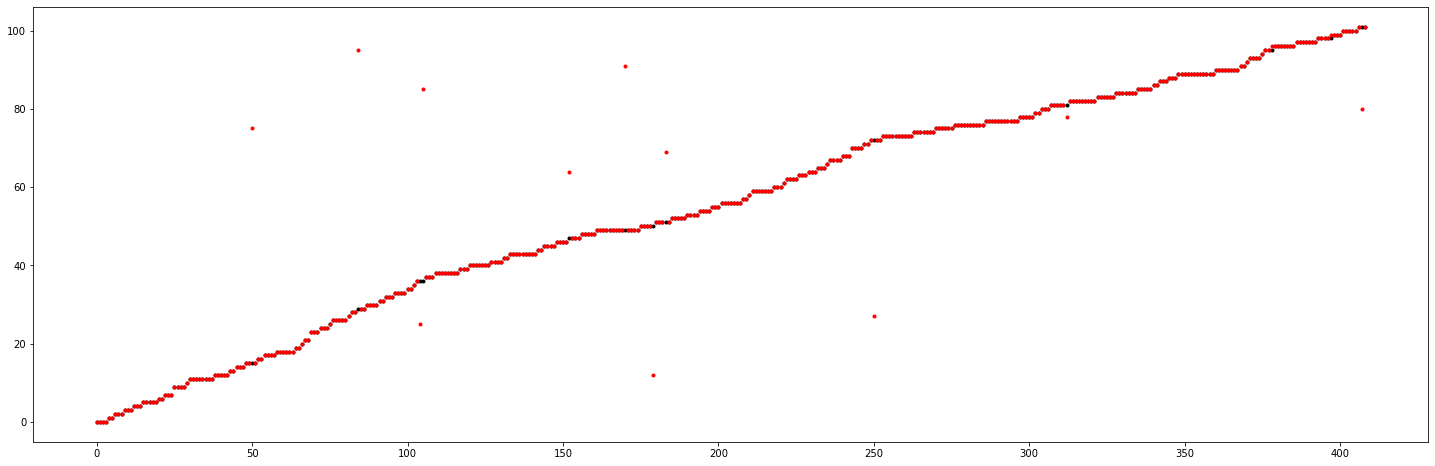

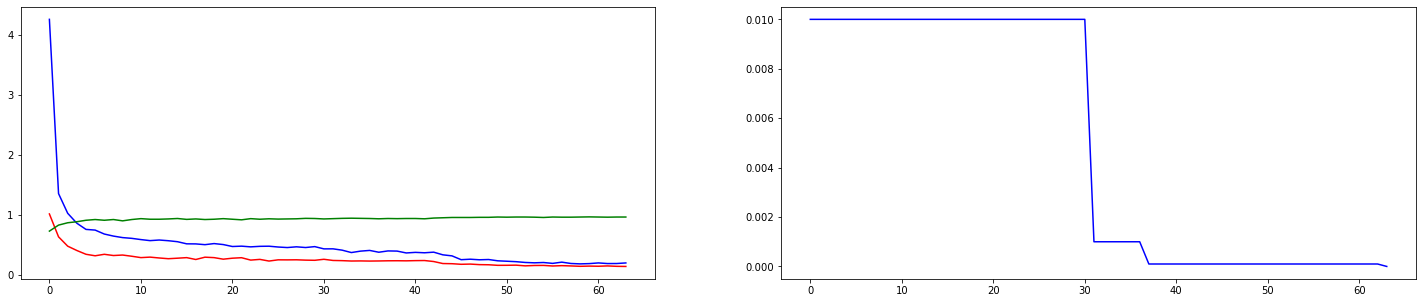

Epoch: 65:                lr: 0.00000100	               Training Loss: 0.177832	               Validation Loss: 0.149311	               Validation accuracy: 96.82%	               Elapsed time: 2188.75


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


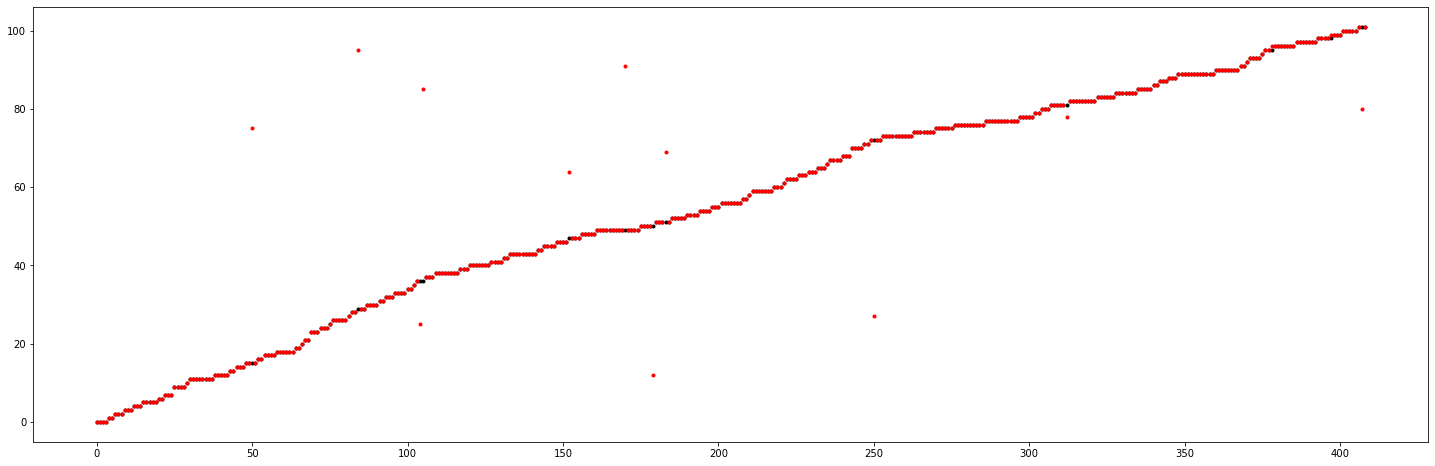

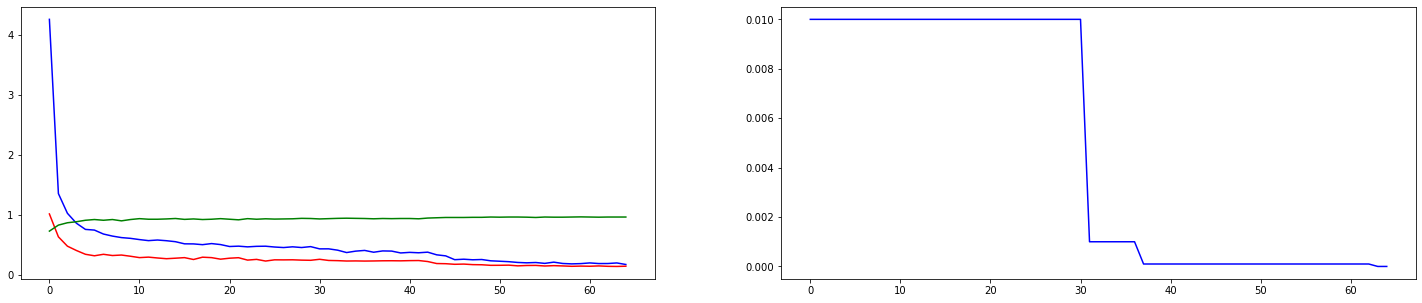

Epoch: 66:                lr: 0.00000100	               Training Loss: 0.199568	               Validation Loss: 0.148543	               Validation accuracy: 96.82%	               Elapsed time: 2213.50


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


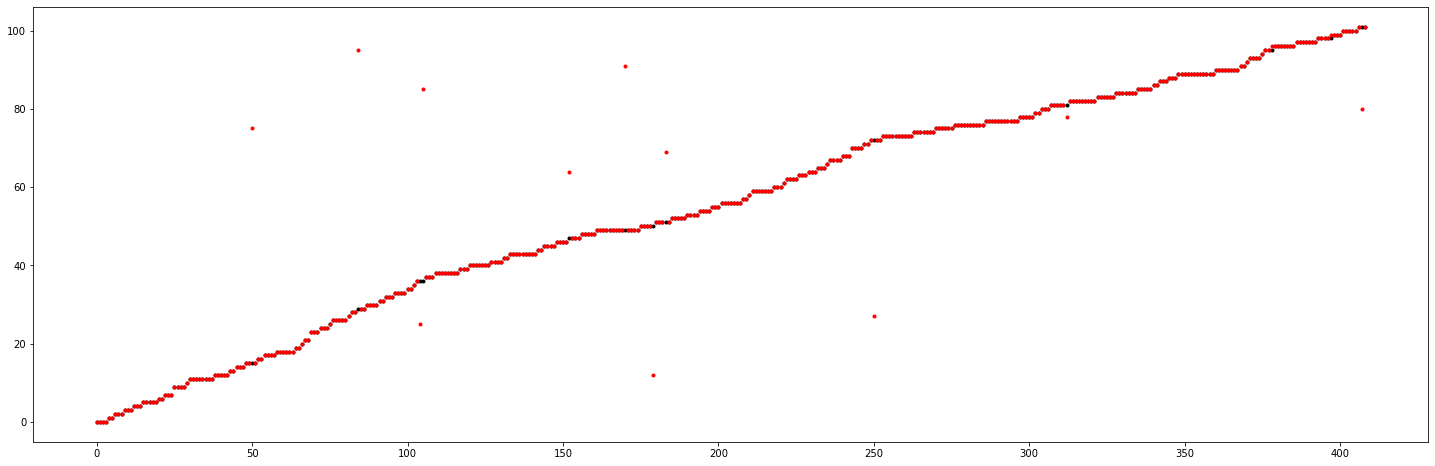

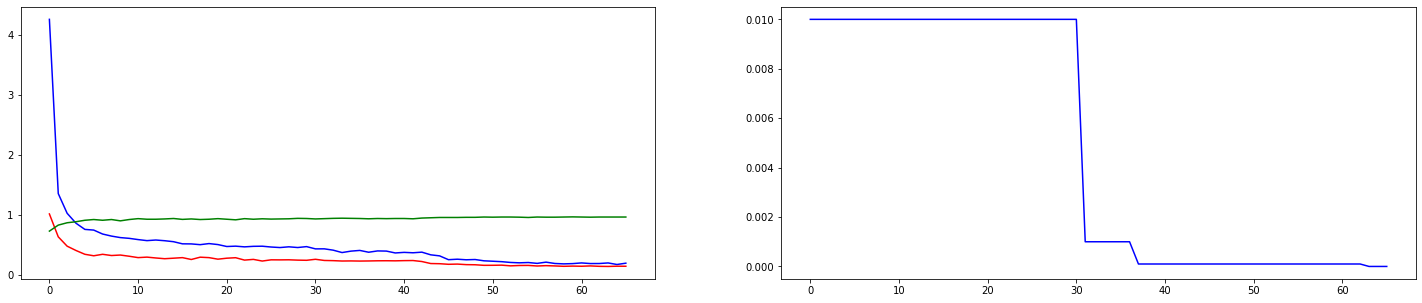

Epoch: 67:                lr: 0.00000100	               Training Loss: 0.196556	               Validation Loss: 0.146767	               Validation accuracy: 96.82%	               Elapsed time: 2235.33


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


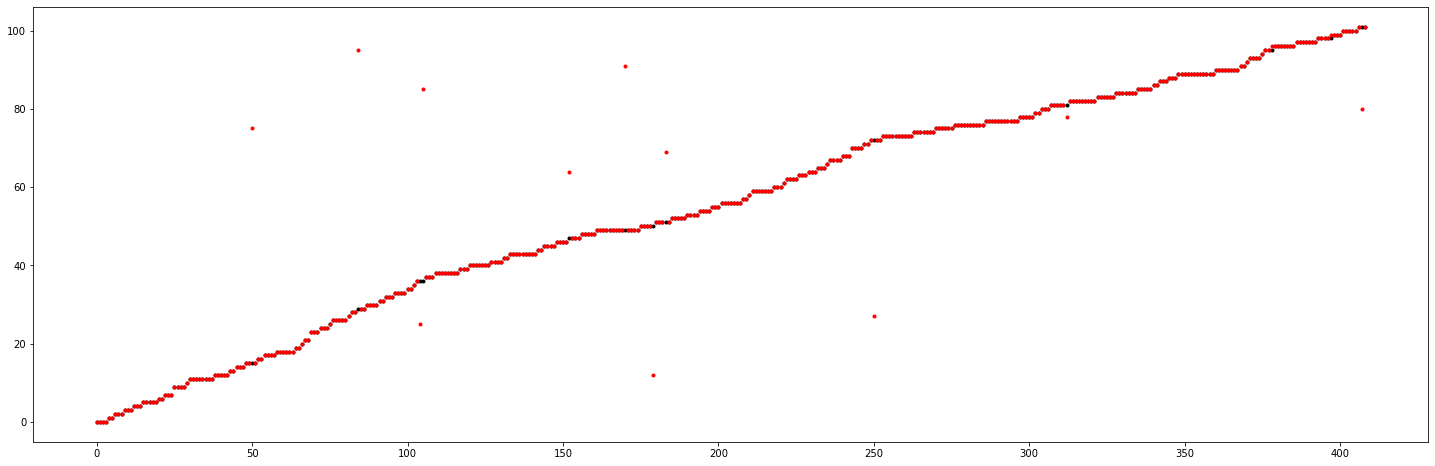

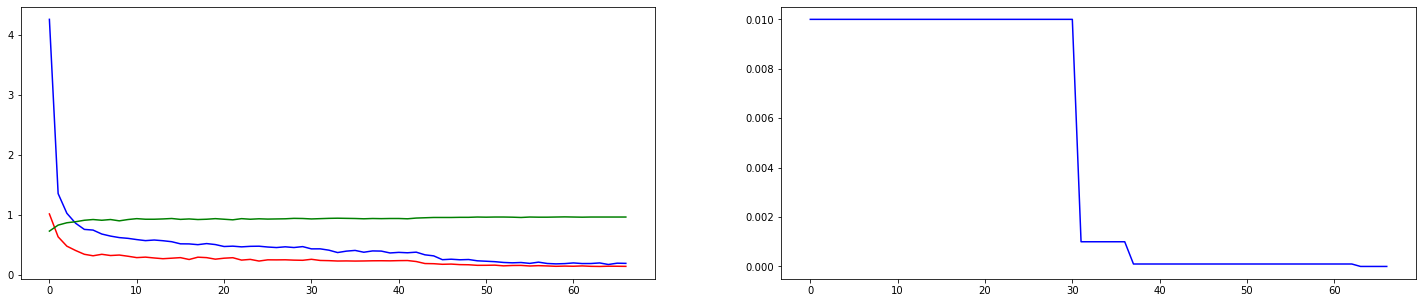

Epoch: 68:                lr: 0.00000100	               Training Loss: 0.179998	               Validation Loss: 0.148119	               Validation accuracy: 97.07%	               Elapsed time: 2257.16


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


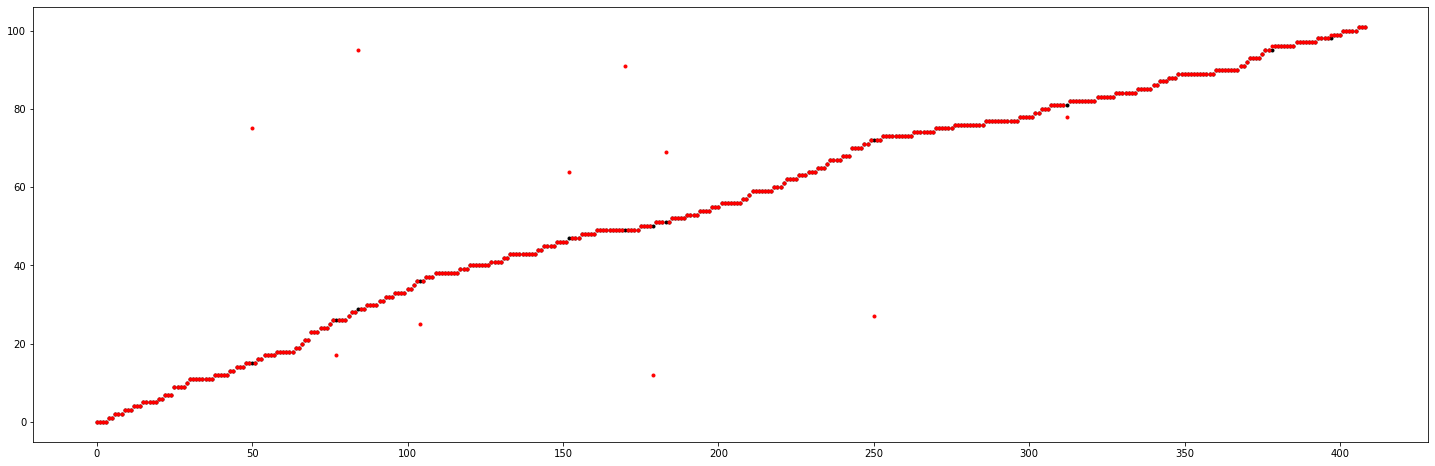

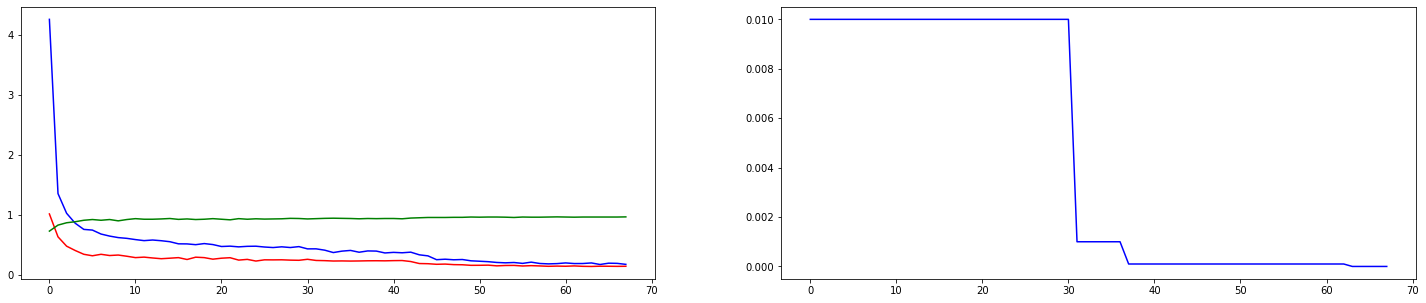

Epoch: 69:                lr: 0.00000100	               Training Loss: 0.184922	               Validation Loss: 0.155797	               Validation accuracy: 96.58%	               Elapsed time: 2278.17


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


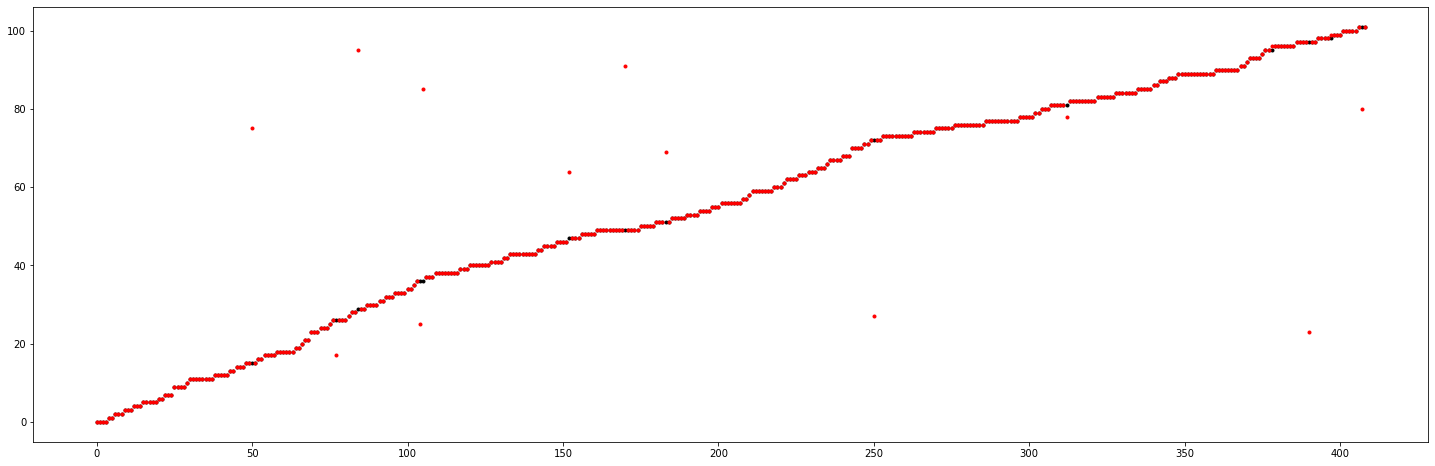

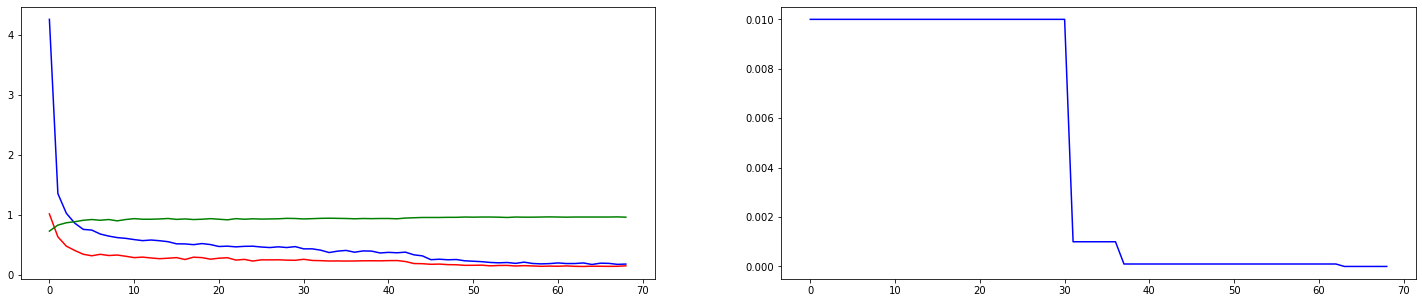

E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 70:                lr: 0.00000100	               Training Loss: 0.175349	               Validation Loss: 0.141407	               Validation accuracy: 97.07%	               Elapsed time: 2298.24
Validation loss decreased:                   (0.145280 --> 0.141407).   Saving model ...


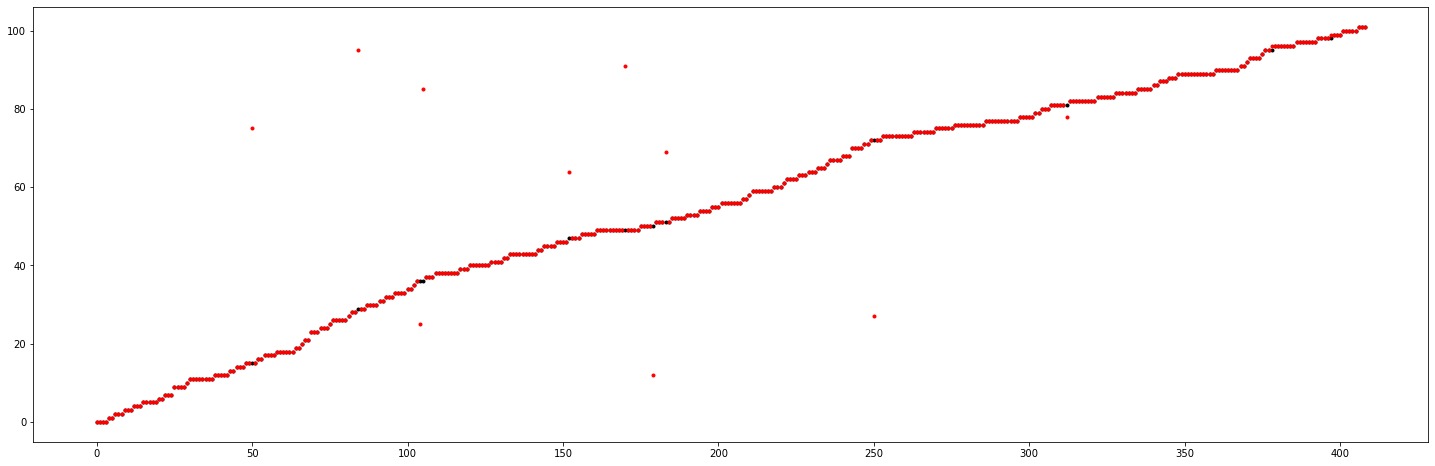

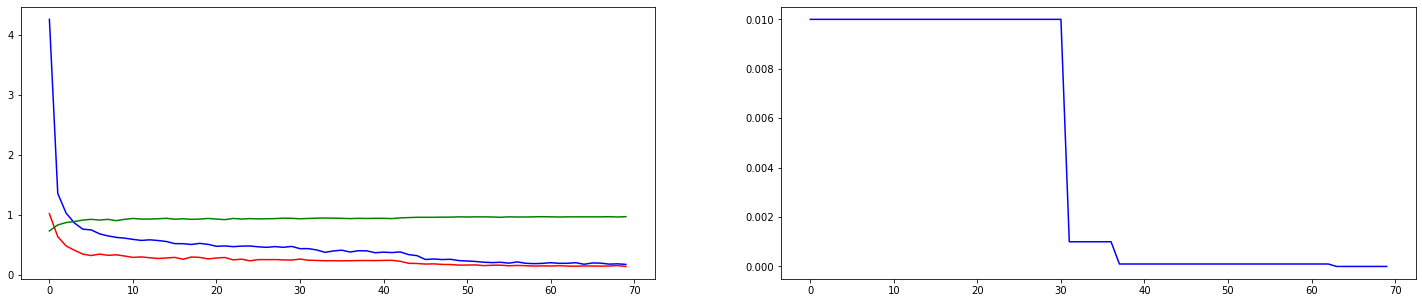

Epoch: 71:                lr: 0.00000100	               Training Loss: 0.187264	               Validation Loss: 0.150828	               Validation accuracy: 96.82%	               Elapsed time: 2318.59


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


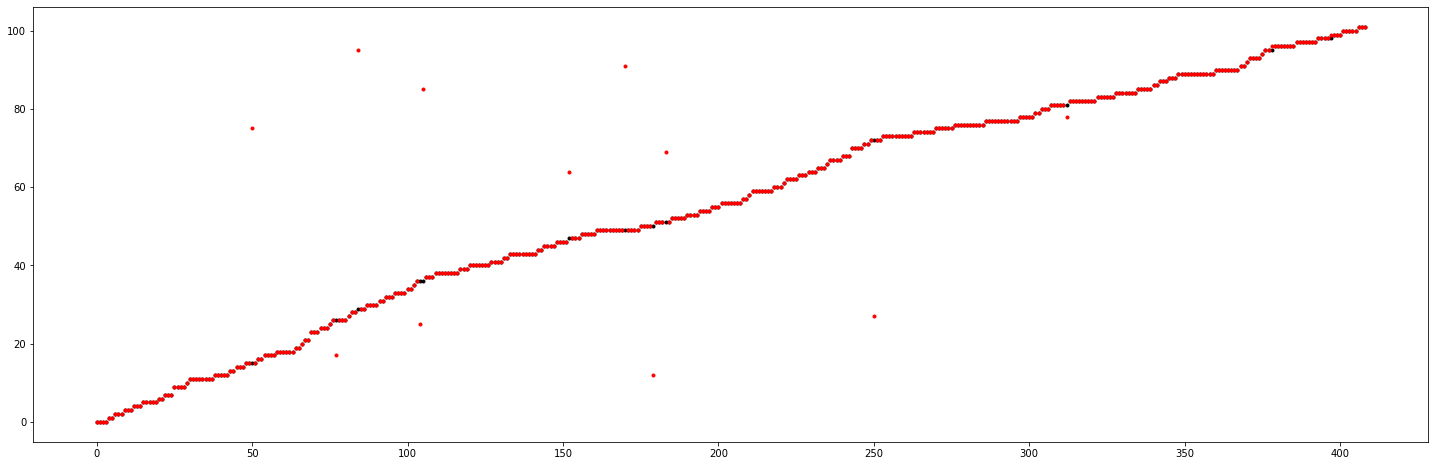

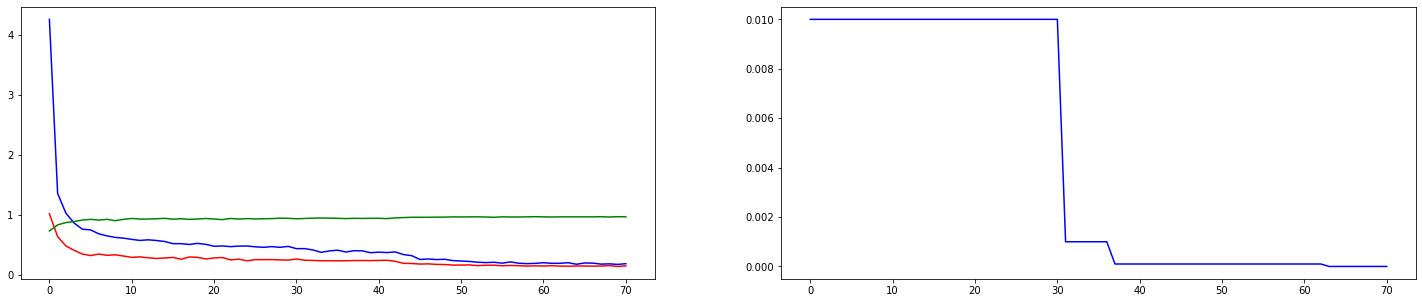

Epoch: 72:                lr: 0.00000100	               Training Loss: 0.179795	               Validation Loss: 0.149927	               Validation accuracy: 96.82%	               Elapsed time: 2341.64


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


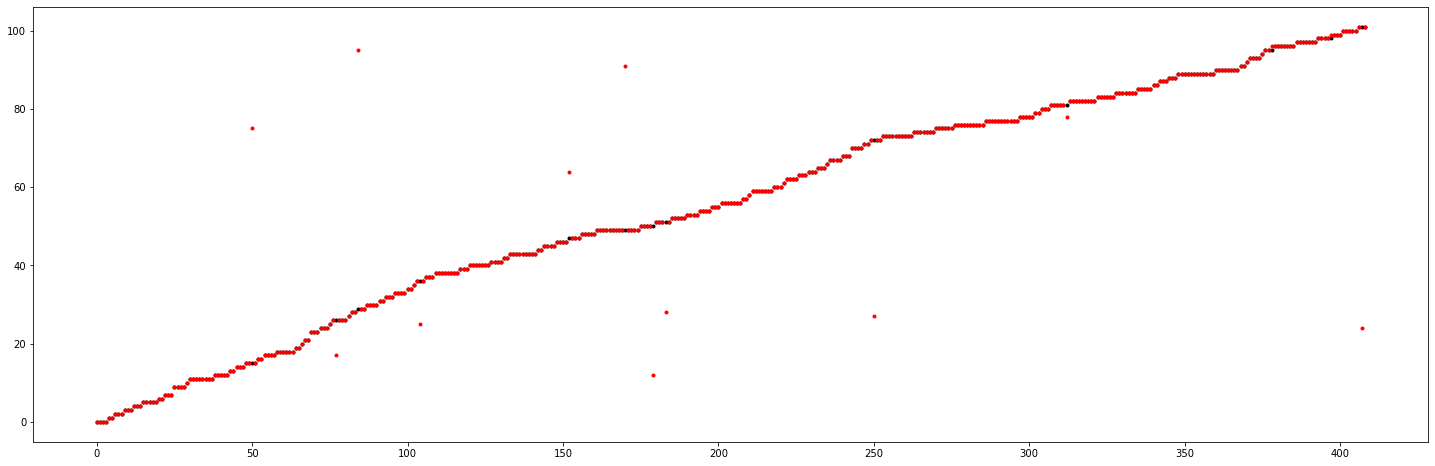

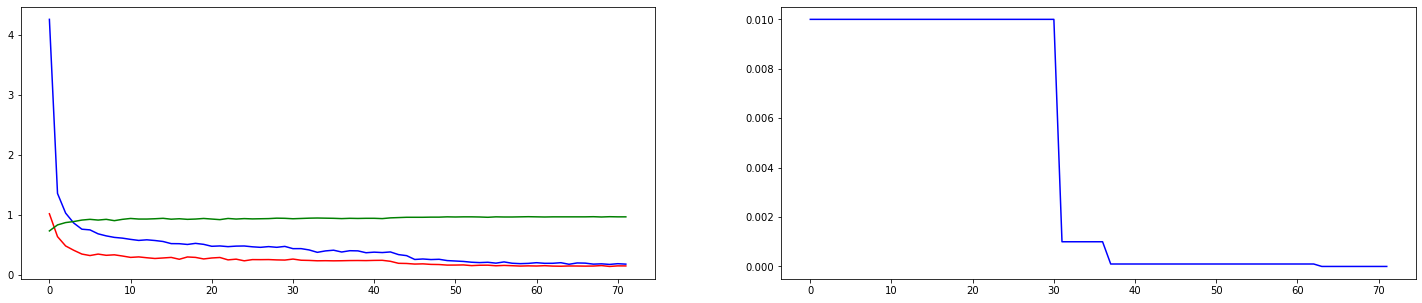

Epoch: 73:                lr: 0.00000100	               Training Loss: 0.190730	               Validation Loss: 0.154061	               Validation accuracy: 96.82%	               Elapsed time: 2364.14


E:\Programming\Anaconda\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


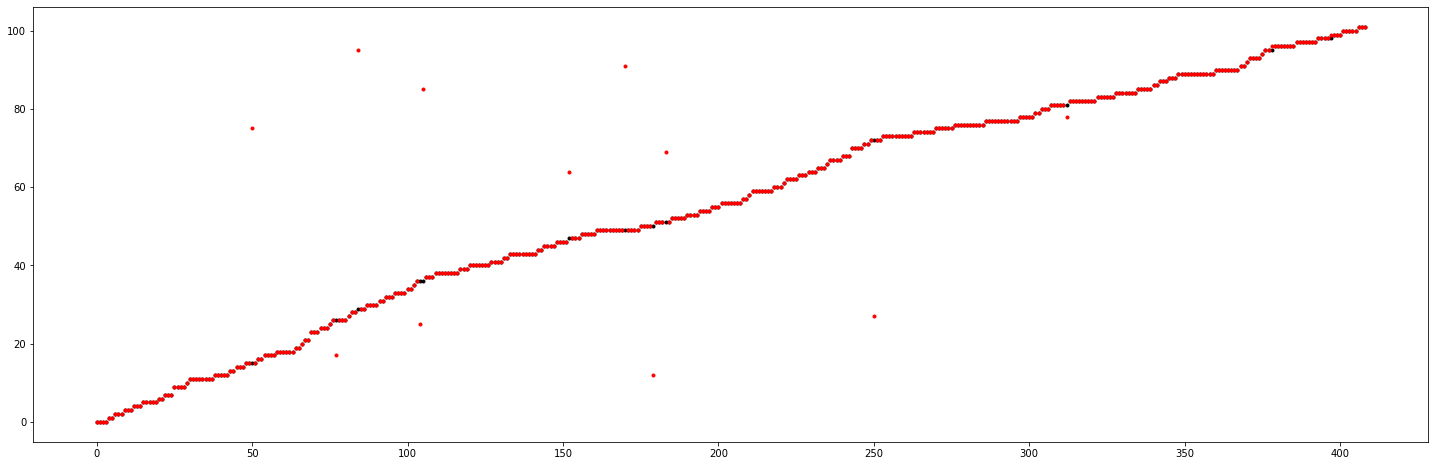

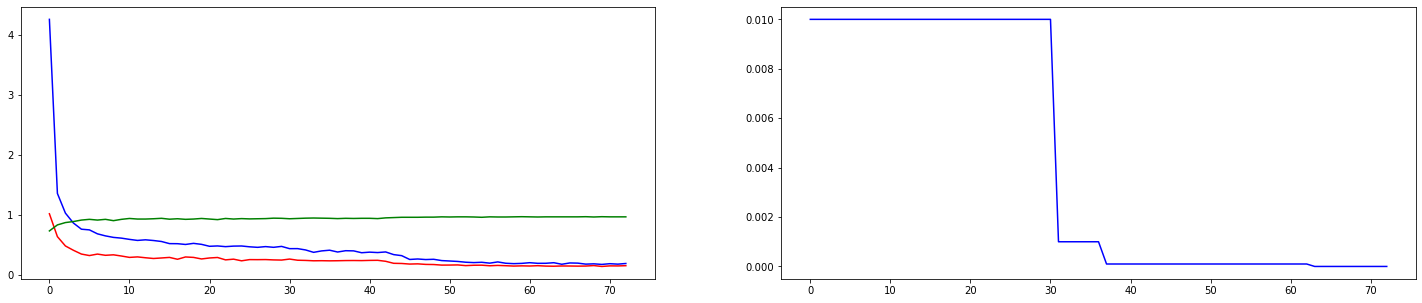

PHASE ONE
Epoch: 1:                lr: 0.01000000	               Training Loss: 4.260430	               Validation Loss: 1.019443	               Validation accuracy: 73.35%	               Elapsed time: 124.77
Epoch: 2:                lr: 0.01000000	               Training Loss: 1.358664	               Validation Loss: 0.638249	               Validation accuracy: 83.37%	               Elapsed time: 151.39
Epoch: 3:                lr: 0.01000000	               Training Loss: 1.030567	               Validation Loss: 0.482966	               Validation accuracy: 87.29%	               Elapsed time: 176.04
Epoch: 4:                lr: 0.01000000	               Training Loss: 0.865001	               Validation Loss: 0.410841	               Validation accuracy: 89.00%	               Elapsed time: 217.54
Epoch: 5:                lr: 0.01000000	               Training Loss: 0.762243	               Validation Loss: 0.347781	               Validation accuracy: 91.44%	               Elapsed time: 24

Test Loss: 0.056561	           Test accuracy: 98.04%


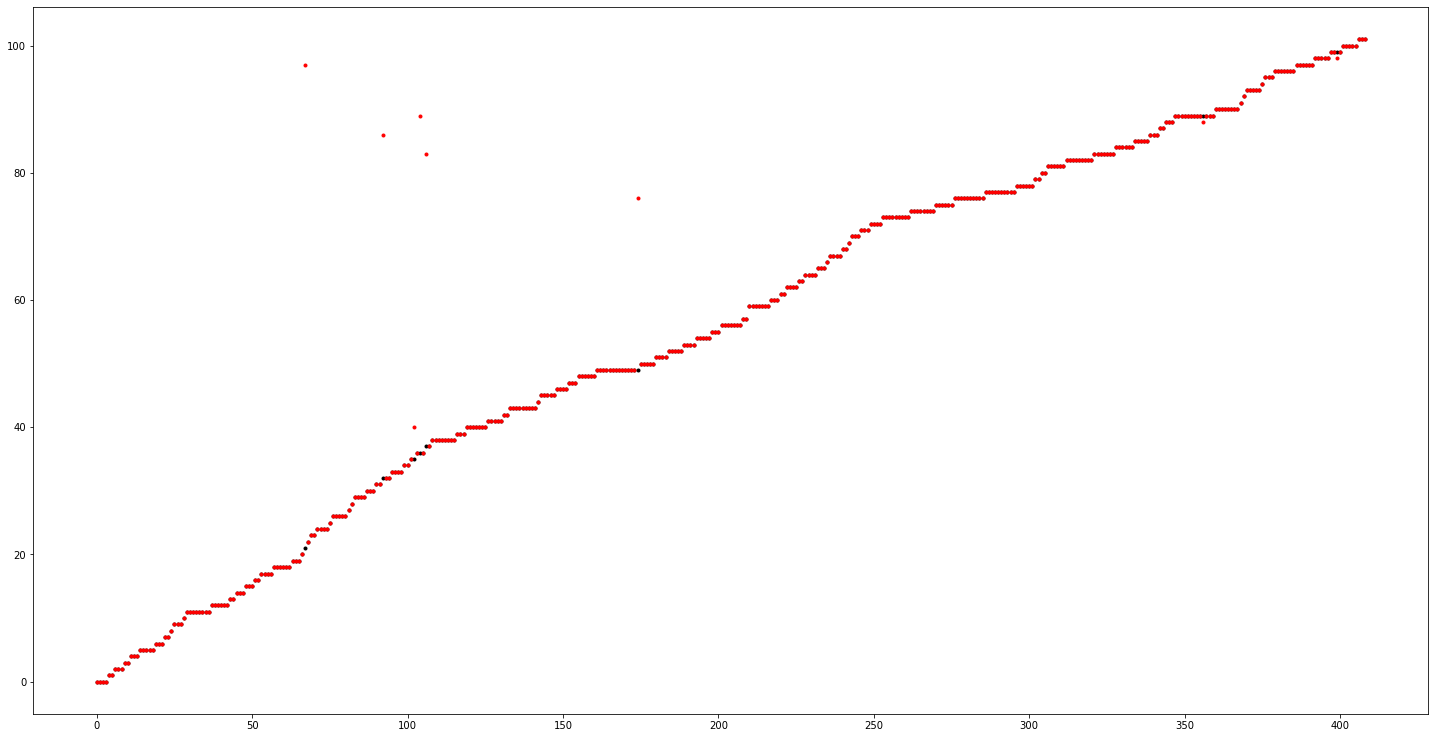

In [14]:
# Training strategy

# Define a loss function
criterion = nn.NLLLoss() # Cross-Entropy (LogSoftmax and NLLLoss)

# Define how many times each phase will be running
PHASE_ONE = 100
PHASE_TWO = 20
PHASE_THREE = 10

TEST = True

# Define the phases
if PHASE_ONE > 0:
    freeze_parameters(model)
    freeze_parameters(model.fc, False)

    fc_optimizer = optim.Adagrad(model.fc.parameters(), lr=0.01, weight_decay=0.001)
    optimizers = [fc_optimizer]

    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(fc_optimizer, mode='min',
                                                   factor=0.1, patience=5,
                                                   threshold=0.01, min_lr=0.00001)
                                                           
    checkpoint_path = "checkpoint_phase_one.pt"
    
    state_dict = train(PHASE_ONE, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=None, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")
    
    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_TWO > 0:
    state_dict['trace_log'].append('PHASE TWO')

    freeze_parameters(model, False)

    conv_optimizer = optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=0.001)
    optimizers = [fc_optimizer, conv_optimizer]

    checkpoint_path = "checkpoint_phase_two.pt"
    
    state_dict = train(PHASE_TWO, model, optimizers, lr_scheduler=None,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if PHASE_THREE > 0:
    state_dict['trace_log'].append('PHASE THREE')

    freeze_parameters(model)
    freeze_parameters(model.fc, False)

    optimizers = [fc_optimizer]
    
    lr_scheduler = optim.lr_scheduler.MultiStepLR(fc_optimizer, milestones=[0], gamma=0.01)
        
    checkpoint_path = "checkpoint_phase_three.pt"
    
    state_dict = train(PHASE_THREE, model, optimizers, lr_scheduler=lr_scheduler,
                       state_dict=state_dict, accuracy_target=None,
                       checkpoint_path=checkpoint_path)

    print(*state_dict['trace_log'], sep="\n")

    state_dict = load_model(checkpoint_path, state_dict)

if TEST:
    test_model()

In [15]:

# Save the checkpoint 
def save_checkpoint(checkpoint_path='checkpoint.pt'):
    model.to('cpu')
    checkpoint = {'model_name': model_name,
                  'output_size': output_size,
                  'hidden_layers': hidden_layers,
                  'model_state_dict': model.state_dict(),
                  'class_to_idx': class_to_idx,
                  'cat_label_to_name': cat_label_to_name}

    torch.save(checkpoint, checkpoint_path)

In [16]:
save_checkpoint('checkpoint.pt')

In [17]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path='checkpoint.pt'):
    checkpoint = torch.load(checkpoint_path)

    model_name = checkpoint['model_name']
    output_size = checkpoint['output_size']
    hidden_layers = checkpoint['hidden_layers']
    
    model = create_network(model_name=model_name,
                         output_size=output_size, hidden_layers=hidden_layers)
   
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.cat_label_to_name = checkpoint['cat_label_to_name']
    
    return model

Test Loss: 0.056561	           Test accuracy: 98.04%


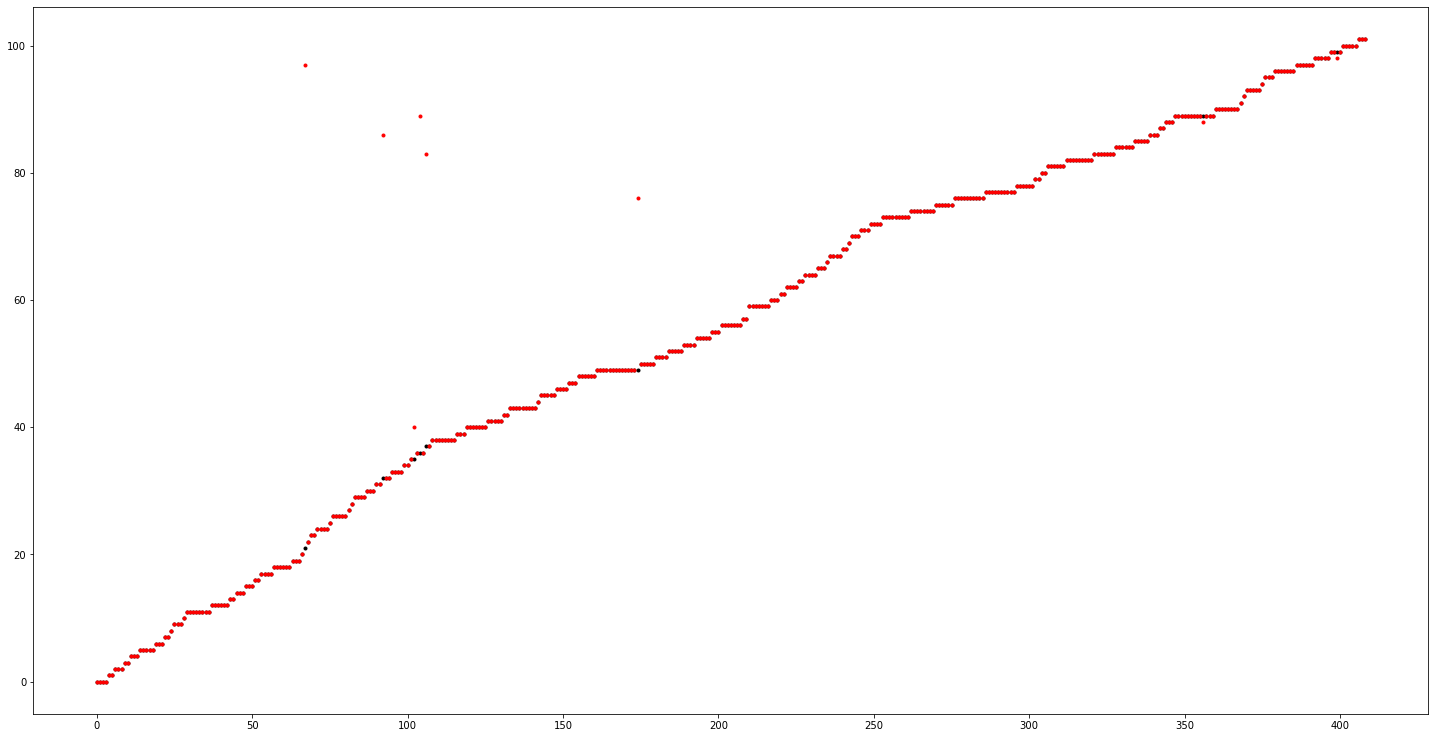

In [19]:
model = load_checkpoint('checkpoint.pt')

model.to(device)

test_model(show_graphs=True)

In [22]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    image = TF.resize(image, 256)
    
    upper_pixel = (image.height - 224) // 2
    left_pixel = (image.width - 224) // 2
    image = TF.crop(image, upper_pixel, left_pixel, 224, 224)
    
    image = TF.to_tensor(image)
    image = TF.normalize(image, normalize_mean, normalize_std)
    
    return image

In [23]:

def imshow(image, ax=None, title=None, titlecolor='k'):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.grid(False)
    if title:
        ax.set_title(title, color=titlecolor)
    
    return ax

<AxesSubplot:>

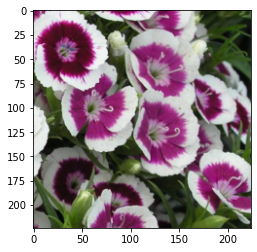

In [24]:
category = 30
image_name = 'image_03475.jpg'
image_path = data_dir + f'/valid/{category}/{image_name}'

#image_path = gdrive_dir+'images/20181221_142343.jpg'

image = Image.open(image_path)
image = process_image(image)
imshow(image)

In [25]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    image = Image.open(image_path)
    image = process_image(image)
    
    with torch.no_grad():
        model.eval()
        
        image = image.view(1,3,224,224)
        image = image.to(device)
        
        predictions = model.forward(image)
        
        predictions = torch.exp(predictions)
        top_ps, top_class = predictions.topk(topk, dim=1)
    
    return top_ps, top_class

In [26]:
probs, classes = predict(image_path, model)
print(probs)
print(classes)

tensor([[9.9948e-01, 2.6385e-04, 1.1762e-04, 3.1261e-05, 2.7520e-05]],
       device='cuda:0')
tensor([[26, 27, 28, 49, 77]], device='cuda:0')


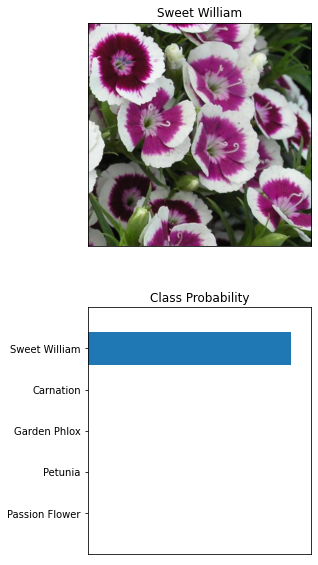

In [27]:
# Display an image along with the top 5 classes
probs, classes = predict(image_path, model)

probs = probs.data.cpu()
probs = probs.numpy().squeeze()

classes = classes.data.cpu()
classes = classes.numpy().squeeze()
classes = [cat_label_to_name[clazz].title() for clazz in classes]

label = class_to_idx[str(category)]
title = f'{cat_label_to_name[label].title()}'

fig = plt.figure(figsize=(4, 10))

ax1 = fig.add_subplot(2, 1, 1, xticks=[], yticks=[])

image = Image.open(image_path)
image = process_image(image)
imshow(image, ax1, title)

ax2 = fig.add_subplot(2, 1, 2, xticks=[], yticks=[])
ax2.barh(np.arange(5), probs)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(classes)
ax2.set_ylim(-1, 5)
ax2.invert_yaxis()
ax2.set_xlim(0, 1.1)
ax2.set_title('Class Probability')

plt.show()

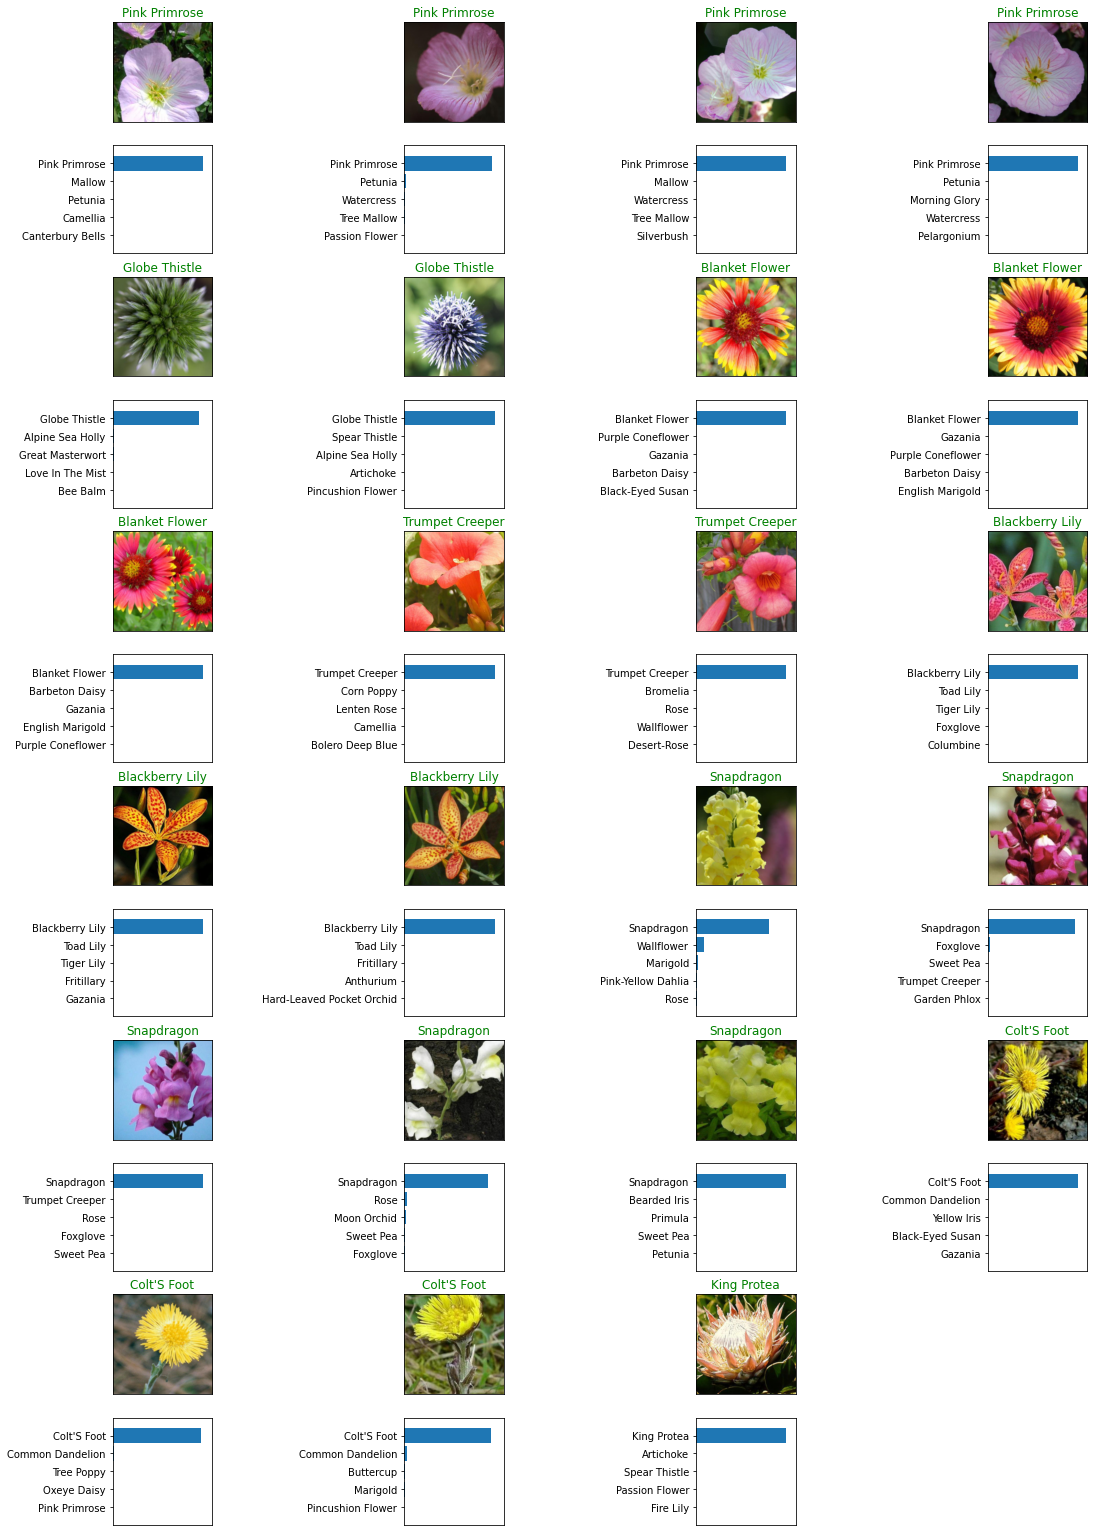

In [31]:

model.eval()
with torch.no_grad():
    for images, labels in dataloaders['test_data']:

        # Move tensors to device
        images, labels = images.to(device), labels.to(device)

        # Get predictions for this test batch
        output = model(images)

        output = torch.exp(output)
        probs, classes = output.topk(5, dim=1)
        
        # Display an image along with the top 5 classes
        
        images = images.cpu()
        probs = probs.data.cpu()
        classes = classes.data.cpu()
        fig = plt.figure(figsize=(15, 28),
                 tight_layout={'pad':0, 'w_pad':5, 'h_pad':0, 'rect':(0,0,1,1)})
        rows = 4
        lines = 16
        line_ctrl = 0
        for index in range(len(images)):
            if index % rows == 0:
                line_ctrl += 1

            prob = probs[index].squeeze()
            
            clazz = [cat_label_to_name[c.item()].title() for c in classes[index]]

            label = labels[index].item()
            title = f'{cat_label_to_name[label].title()}'

            position = index + 1 + (line_ctrl * rows)
            ax1 = fig.add_subplot(lines, rows, position, xticks=[], yticks=[])
            titlecolor = 'g'
            if title != clazz[0]:
                titlecolor = 'r'

            imshow(images[index], ax1, title, titlecolor=titlecolor)

            ax2 = fig.add_subplot(lines, rows, position+rows, xticks=[], yticks=[])
            ax2.barh(np.arange(5), prob)
            ax2.set_yticks(np.arange(5))
            ax2.set_yticklabels(clazz)
            ax2.set_ylim(-1, 5)
            ax2.invert_yaxis()
            ax2.set_xlim(0, 1.1)

        break
        plt.show()